##GAN&CLIP - WITH CALLBACKS

See how the model is training...

Overview:
This notebook is handling the pipeline of 


Authors: Maciej Domagała, Adam Komorowski

### GENERATING IMAGES

In [ ]:
#@title Initialization (Installation, Imports) - check github branch!
%%capture
import subprocess
import re

nvcc = subprocess.check_output(["nvcc", "--version"]).decode("utf-8")
version = re.findall("release (\d+\.\d+)", nvcc)[0]

pytorch_suffix = {
    "10.0": "+cu100",
    "10.1": "+cu101",
    "10.2": "",
}

pytorch_version = "1.7.1" + (pytorch_suffix[version] if version in pytorch_suffix else "+cu110")
torchvision_version = "0.8.2" + (pytorch_suffix[version] if version in pytorch_suffix else "+cu110")

!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt #imagenet_classes

!git clone https://github.com/maciejdomagala/clip_gans.git
%cd clip_gans
!git checkout main ### WARNING!!!

try:
  import torch
except:
  !pip install torch=={pytorch_version} -f https://download.pytorch.org/whl/torch_stable.html

try:
  import torchvision
except:
  !pip install torchvision=={torchvision_version} -f https://download.pytorch.org/whl/torch_stable.html

# !pip install pytorch_pretrained_biggan pymoo kornia ftfy tensorboard
!pip install pytorch_pretrained_biggan kornia ftfy tensorboard
# !pip install -e git+github.com/maciejdomagala/pymoo.git

!git clone https://github.com/maciejdomagala/pymoo.git
%cd pymoo
!git checkout master ### WARNING!!!
!pip install .

%cd ..

# IMPORTS
import warnings

import argparse
import os
import torch
import numpy as np
import pickle
import math

from tqdm import tqdm_notebook
from pymoo.optimize import minimize
from pymoo.algorithms.so_genetic_algorithm import GA
from pymoo.factory import get_algorithm, get_decision_making, get_decomposition
from pymoo.visualization.scatter import Scatter
import torchvision
from IPython.display import Image, display
import urllib.request
import cv2

from config import get_config
from problem import GenerationProblem
from operators import get_operators
from operators import get_algo


warnings.filterwarnings('ignore')

In [ ]:
#for experiments later

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title Input Parameters
target = "a dog in the fog" #@param {type:"string"}
config = "DeepMindBigGAN256_ga" #@param ["DeepMindBigGAN256_ga","DeepMindBigGAN256_de", "StyleGAN2_ffhq_ga","StyleGAN2_ffhq_de", "StyleGAN2_car_ga", "StyleGAN2_car_de","StyleGAN2_church_ga", "StyleGAN2_church_de","StyleGAN2_cat_ga", "StyleGAN2_cat_de"]
generations =   200#@param {type:"number"}
callbacks_each =  10 #@param {type: "number"}
population_size =  64#@param {type:"number"}
#number_of_loops =  1 #@param {type:"number"}
# algorithm_param = 'ga' #@param ['ga', 'de']

In [ ]:
#@title Download weights for given model
!chmod +x ./download-weights.sh
if "ffhq" in config:
  ! ./download-weights.sh StyleGAN2-ffhq
if "church" in config:
  ! ./download-weights.sh StyleGAN2-church
if "car" in config:
  ! ./download-weights.sh StyleGAN2-car
if "cat" in config:
  ! ./download-weights.sh StyleGAN2-cat

In [ ]:
#@title Config 
config = argparse.Namespace(
    config=config,
    target=target,
    device="cuda",
    generations=generations,
    tmp_folder="./results"
)
vars(config).update(get_config(config.config))
config.pop_size = population_size
# config.algorithm = algorithm_param
config.generations = generations
config.callbacks_each = callbacks_each

if not os.path.exists(config.tmp_folder): os.mkdir(config.tmp_folder)
if not os.path.exists(f'{config.tmp_folder}/{config.target}'): os.mkdir(f'{config.tmp_folder}/{config.target}')


In [ ]:
#@title Support methods
def callback(algorithm):
    global config, iteration, loop, target

    iteration += 1

    sortedpop = sorted(algorithm.pop, key=lambda p: p.F)
    X = np.stack([p.X for p in sortedpop])      
    ls = config.latent(config)
    ls.set_from_population(X)
    if (iteration%config.callbacks_each == 0) or (iteration==config.generations):
      with torch.no_grad():
        generated = algorithm.problem.generator.generate(ls)
        name = f'batch_iteration_{iteration}.jpg'
        algorithm.problem.generator.save(generated, f"./{config.tmp_folder}/{config.target}/{name}")
        print(f'After {iteration} iterations...')
        display(Image(f"./{config.tmp_folder}/{config.target}/{name}"))

def generate_image(loop: int):
  problem = GenerationProblem(config)

  kwargs = get_algo(config)

  algorithm = get_algorithm(
      config.algorithm,
      callback=callback,
      **kwargs
  )

  res = minimize(
      problem,
      algorithm,
      ("n_gen", config.generations),
      save_history=False,
      verbose=True,
  )


  X = np.atleast_2d(res.X)
  ls = config.latent(config)
  ls.set_from_population(X)

  with torch.no_grad():
      generated = problem.generator.generate(ls)
  print(f'Final image for "{config.target}" target.')
  problem.generator.save(generated, f"./{config.tmp_folder}/{config.target}/final.jpg")
  display(Image(f"./{config.tmp_folder}/{config.target}/final.jpg"))

  return res

start optimizing
n_gen |  n_eval |   cv (min)   |   cv (avg)   |     fopt     |     favg    
    1 |      64 |  0.00000E+00 |  0.00000E+00 |      -0.3223 |      -0.2211
    2 |     128 |  0.00000E+00 |  0.00000E+00 |      -0.3223 |      -0.2451
    3 |     192 |  0.00000E+00 |  0.00000E+00 |      -0.3223 |      -0.2563
    4 |     256 |  0.00000E+00 |  0.00000E+00 |      -0.3223 |      -0.2651
    5 |     320 |  0.00000E+00 |  0.00000E+00 |      -0.3242 |       -0.272
    6 |     384 |  0.00000E+00 |  0.00000E+00 |      -0.3503 |      -0.2798
    7 |     448 |  0.00000E+00 |  0.00000E+00 |      -0.3503 |      -0.2844
    8 |     512 |  0.00000E+00 |  0.00000E+00 |      -0.3503 |      -0.2883
    9 |     576 |  0.00000E+00 |  0.00000E+00 |      -0.3503 |      -0.2935
   10 |     640 |  0.00000E+00 |  0.00000E+00 |      -0.3503 |      -0.2976
After 10 iterations...


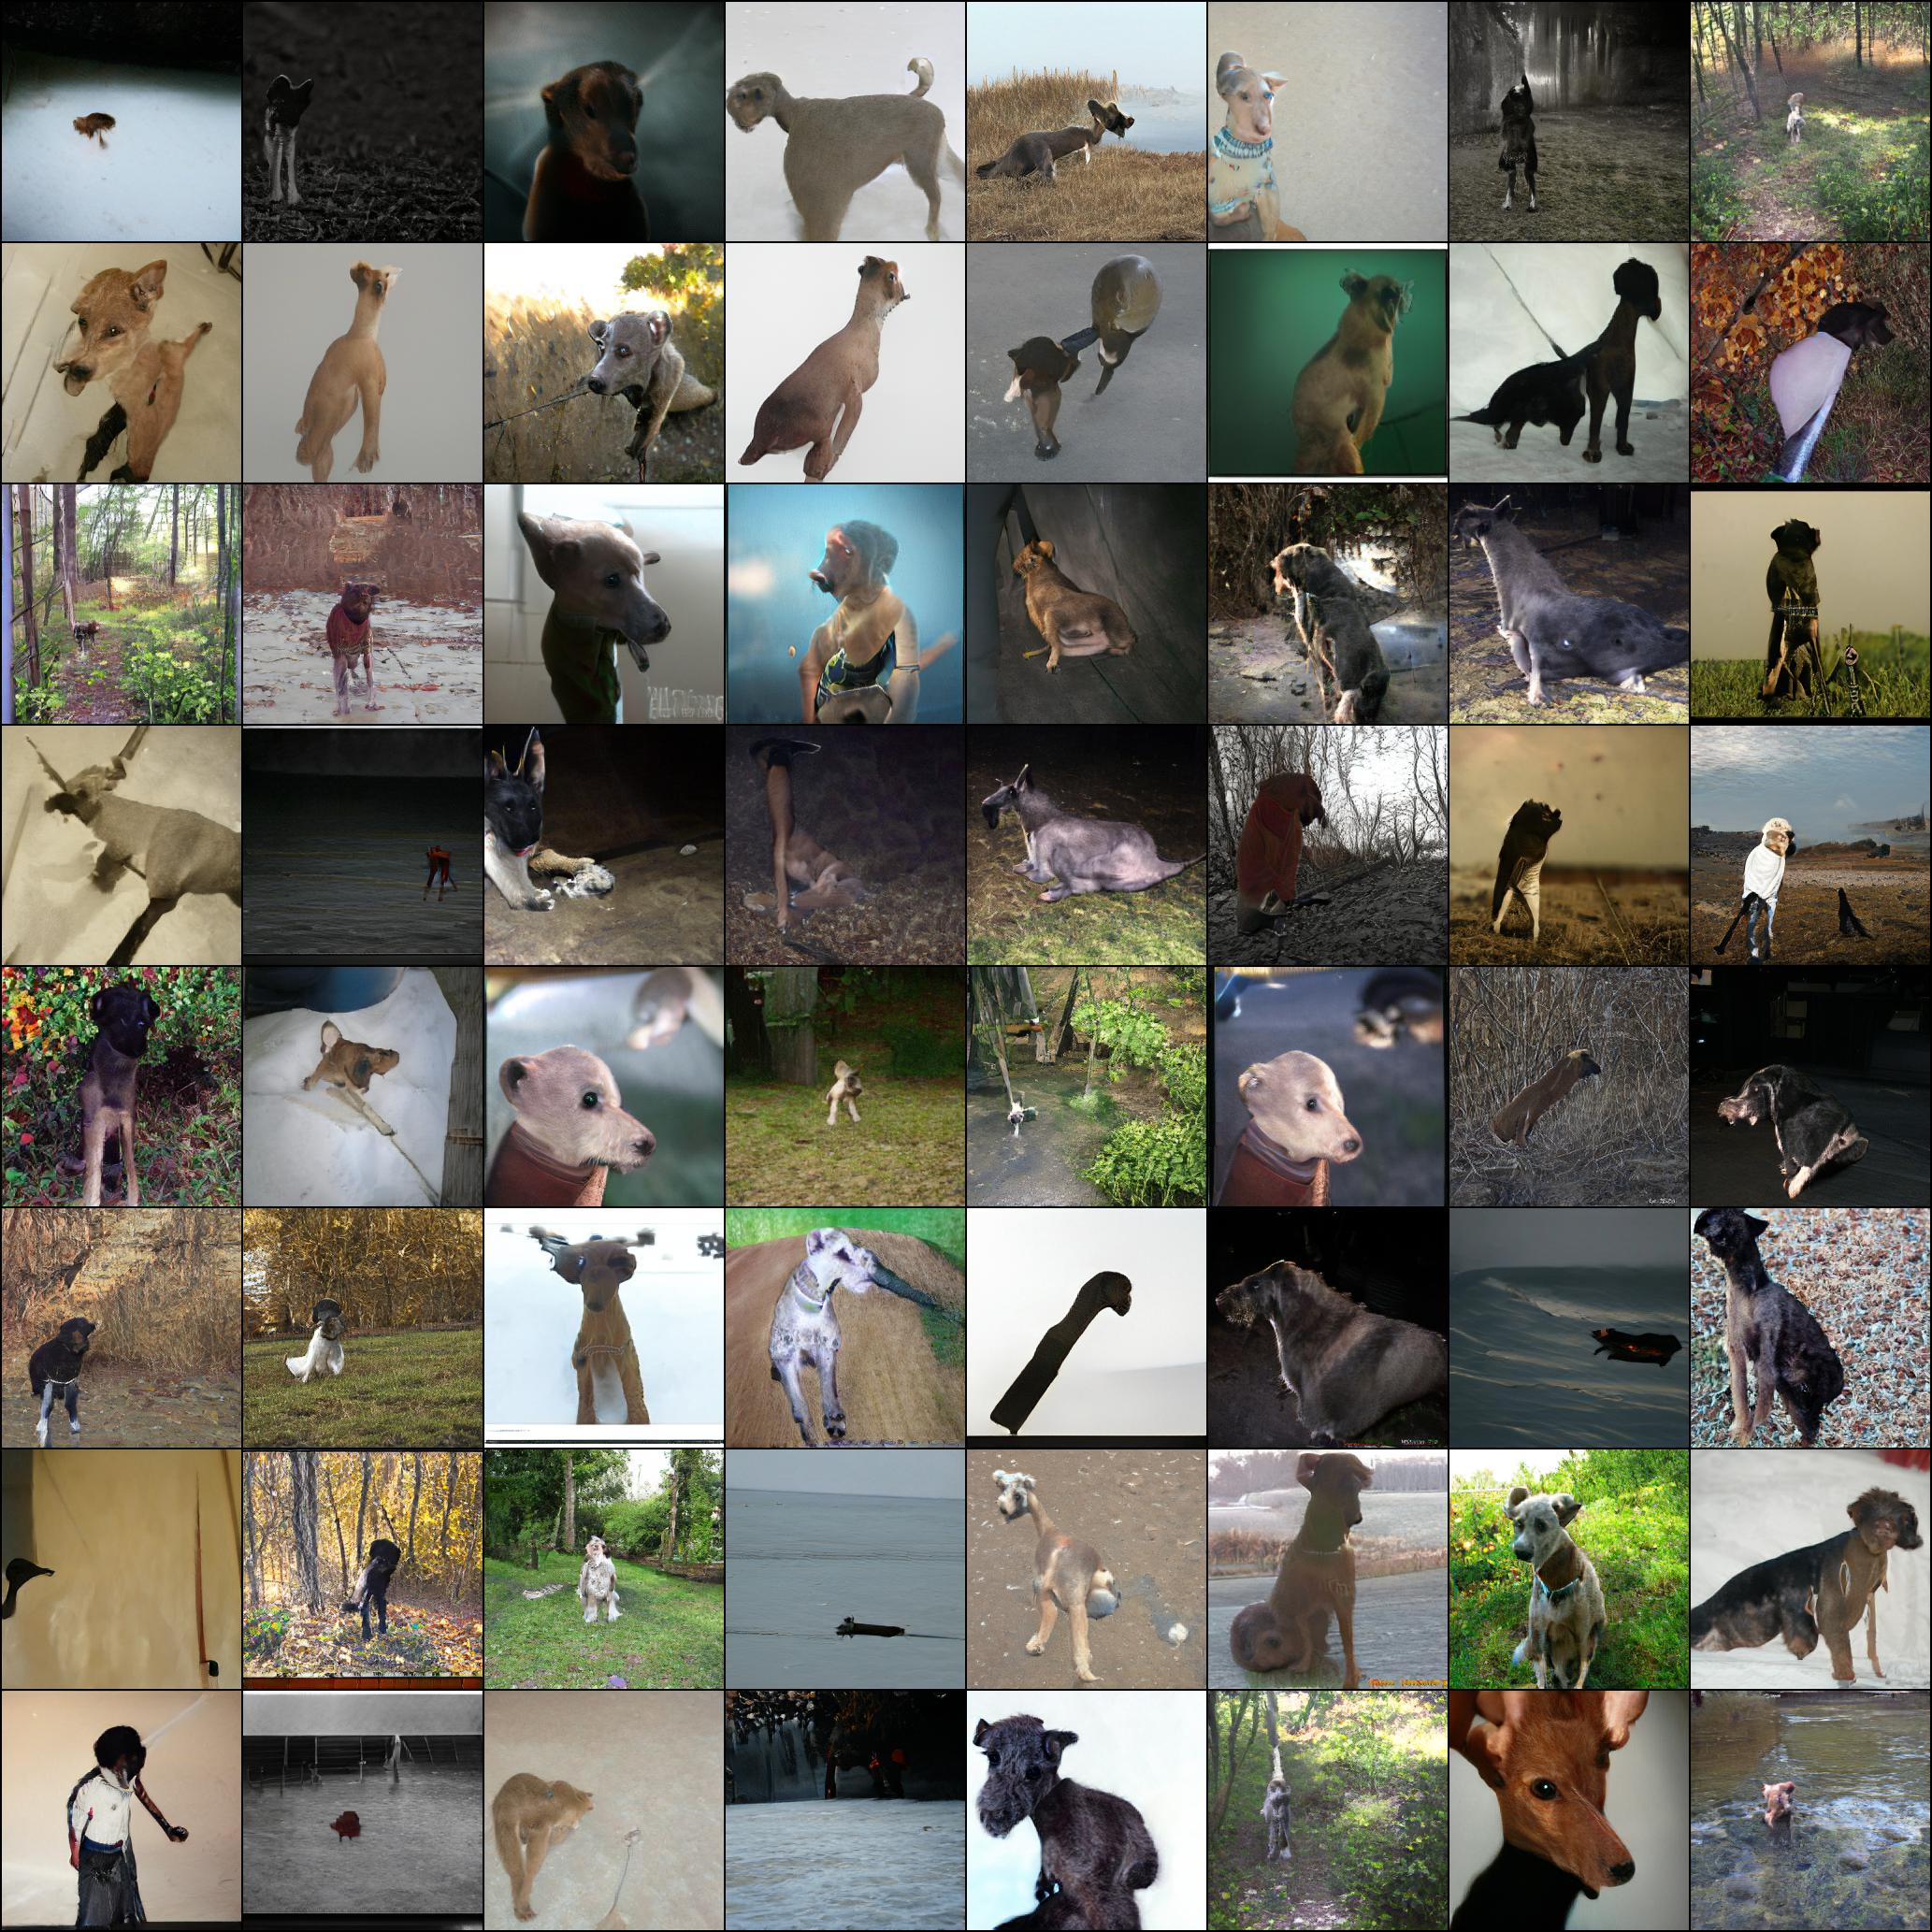

   11 |     704 |  0.00000E+00 |  0.00000E+00 |      -0.3503 |      -0.2998
   12 |     768 |  0.00000E+00 |  0.00000E+00 |      -0.3503 |      -0.3013
   13 |     832 |  0.00000E+00 |  0.00000E+00 |      -0.3503 |      -0.3052
   14 |     896 |  0.00000E+00 |  0.00000E+00 |      -0.3503 |      -0.3086
   15 |     960 |  0.00000E+00 |  0.00000E+00 |      -0.3503 |      -0.3113
   16 |    1024 |  0.00000E+00 |  0.00000E+00 |      -0.3523 |      -0.3145
   17 |    1088 |  0.00000E+00 |  0.00000E+00 |      -0.3552 |       -0.317
   18 |    1152 |  0.00000E+00 |  0.00000E+00 |      -0.3552 |      -0.3179
   19 |    1216 |  0.00000E+00 |  0.00000E+00 |      -0.3552 |      -0.3198
   20 |    1280 |  0.00000E+00 |  0.00000E+00 |      -0.3552 |       -0.322
After 20 iterations...


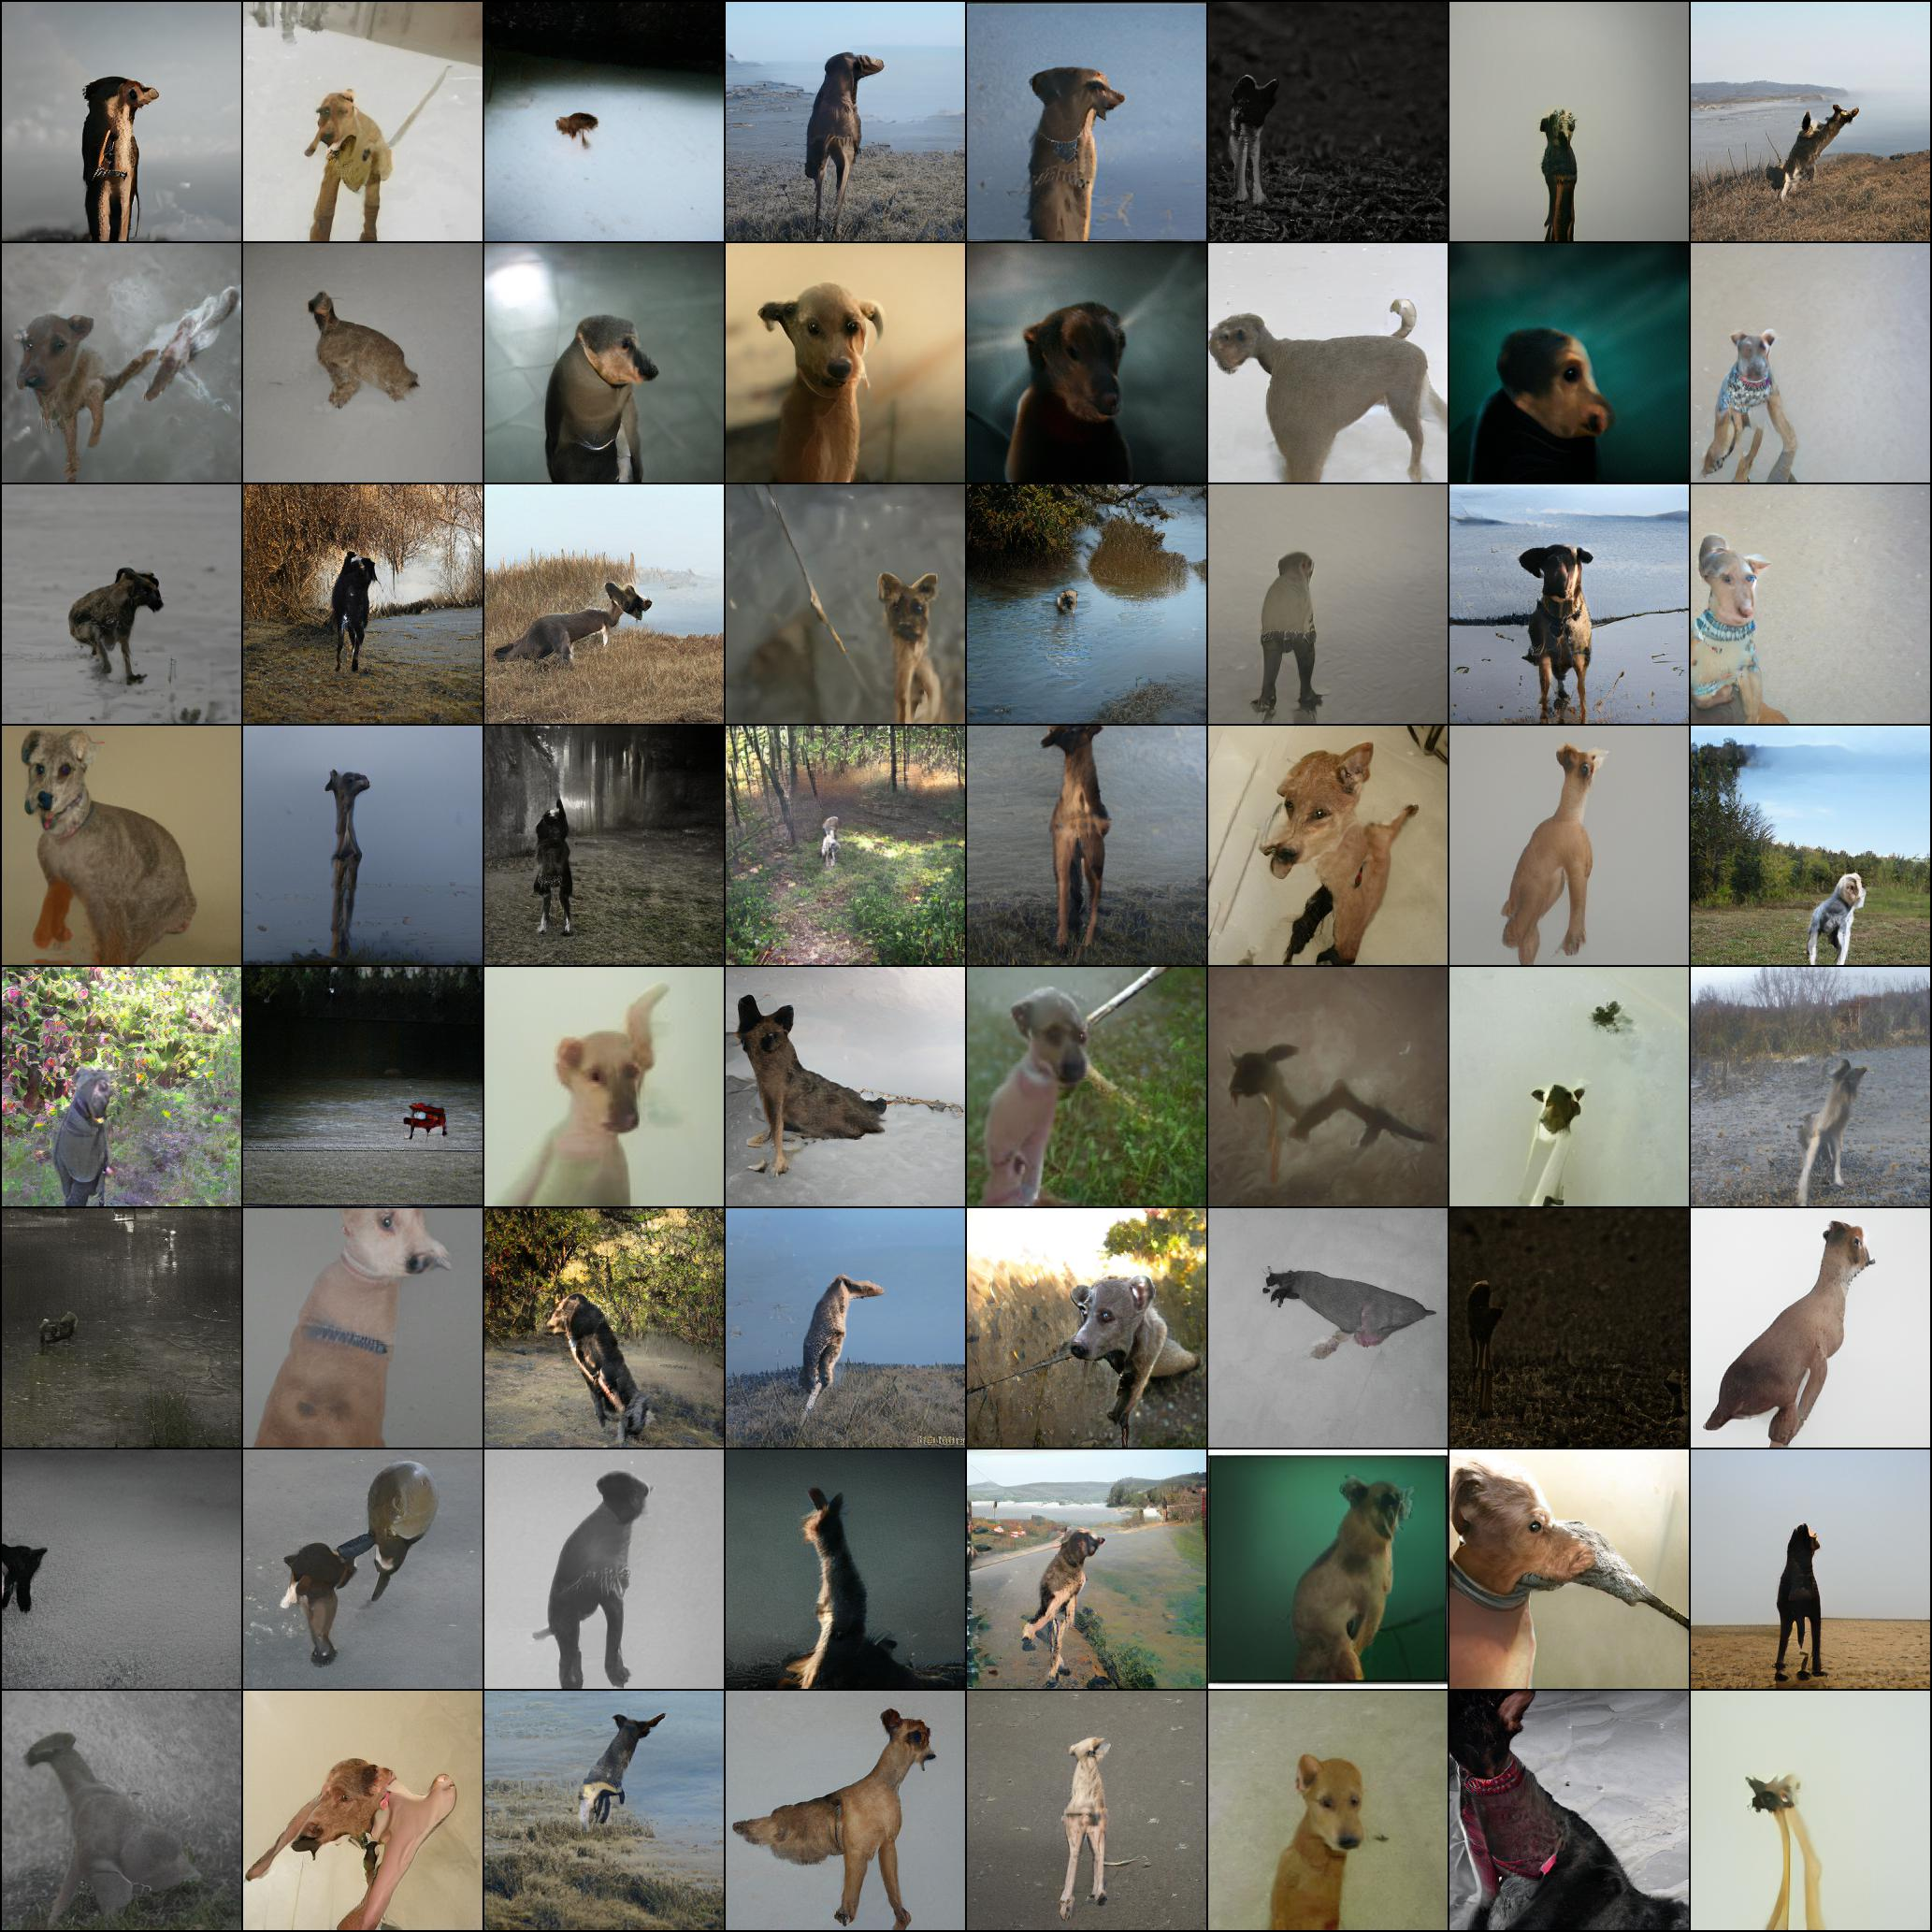

   21 |    1344 |  0.00000E+00 |  0.00000E+00 |      -0.3552 |      -0.3232
   22 |    1408 |  0.00000E+00 |  0.00000E+00 |      -0.3552 |       -0.326
   23 |    1472 |  0.00000E+00 |  0.00000E+00 |      -0.3552 |       -0.328
   24 |    1536 |  0.00000E+00 |  0.00000E+00 |      -0.3552 |      -0.3293
   25 |    1600 |  0.00000E+00 |  0.00000E+00 |      -0.3552 |      -0.3315
   26 |    1664 |  0.00000E+00 |  0.00000E+00 |       -0.356 |      -0.3345
   27 |    1728 |  0.00000E+00 |  0.00000E+00 |       -0.356 |      -0.3347
   28 |    1792 |  0.00000E+00 |  0.00000E+00 |      -0.3662 |      -0.3367
   29 |    1856 |  0.00000E+00 |  0.00000E+00 |      -0.3662 |      -0.3374
   30 |    1920 |  0.00000E+00 |  0.00000E+00 |        -0.37 |      -0.3406
After 30 iterations...


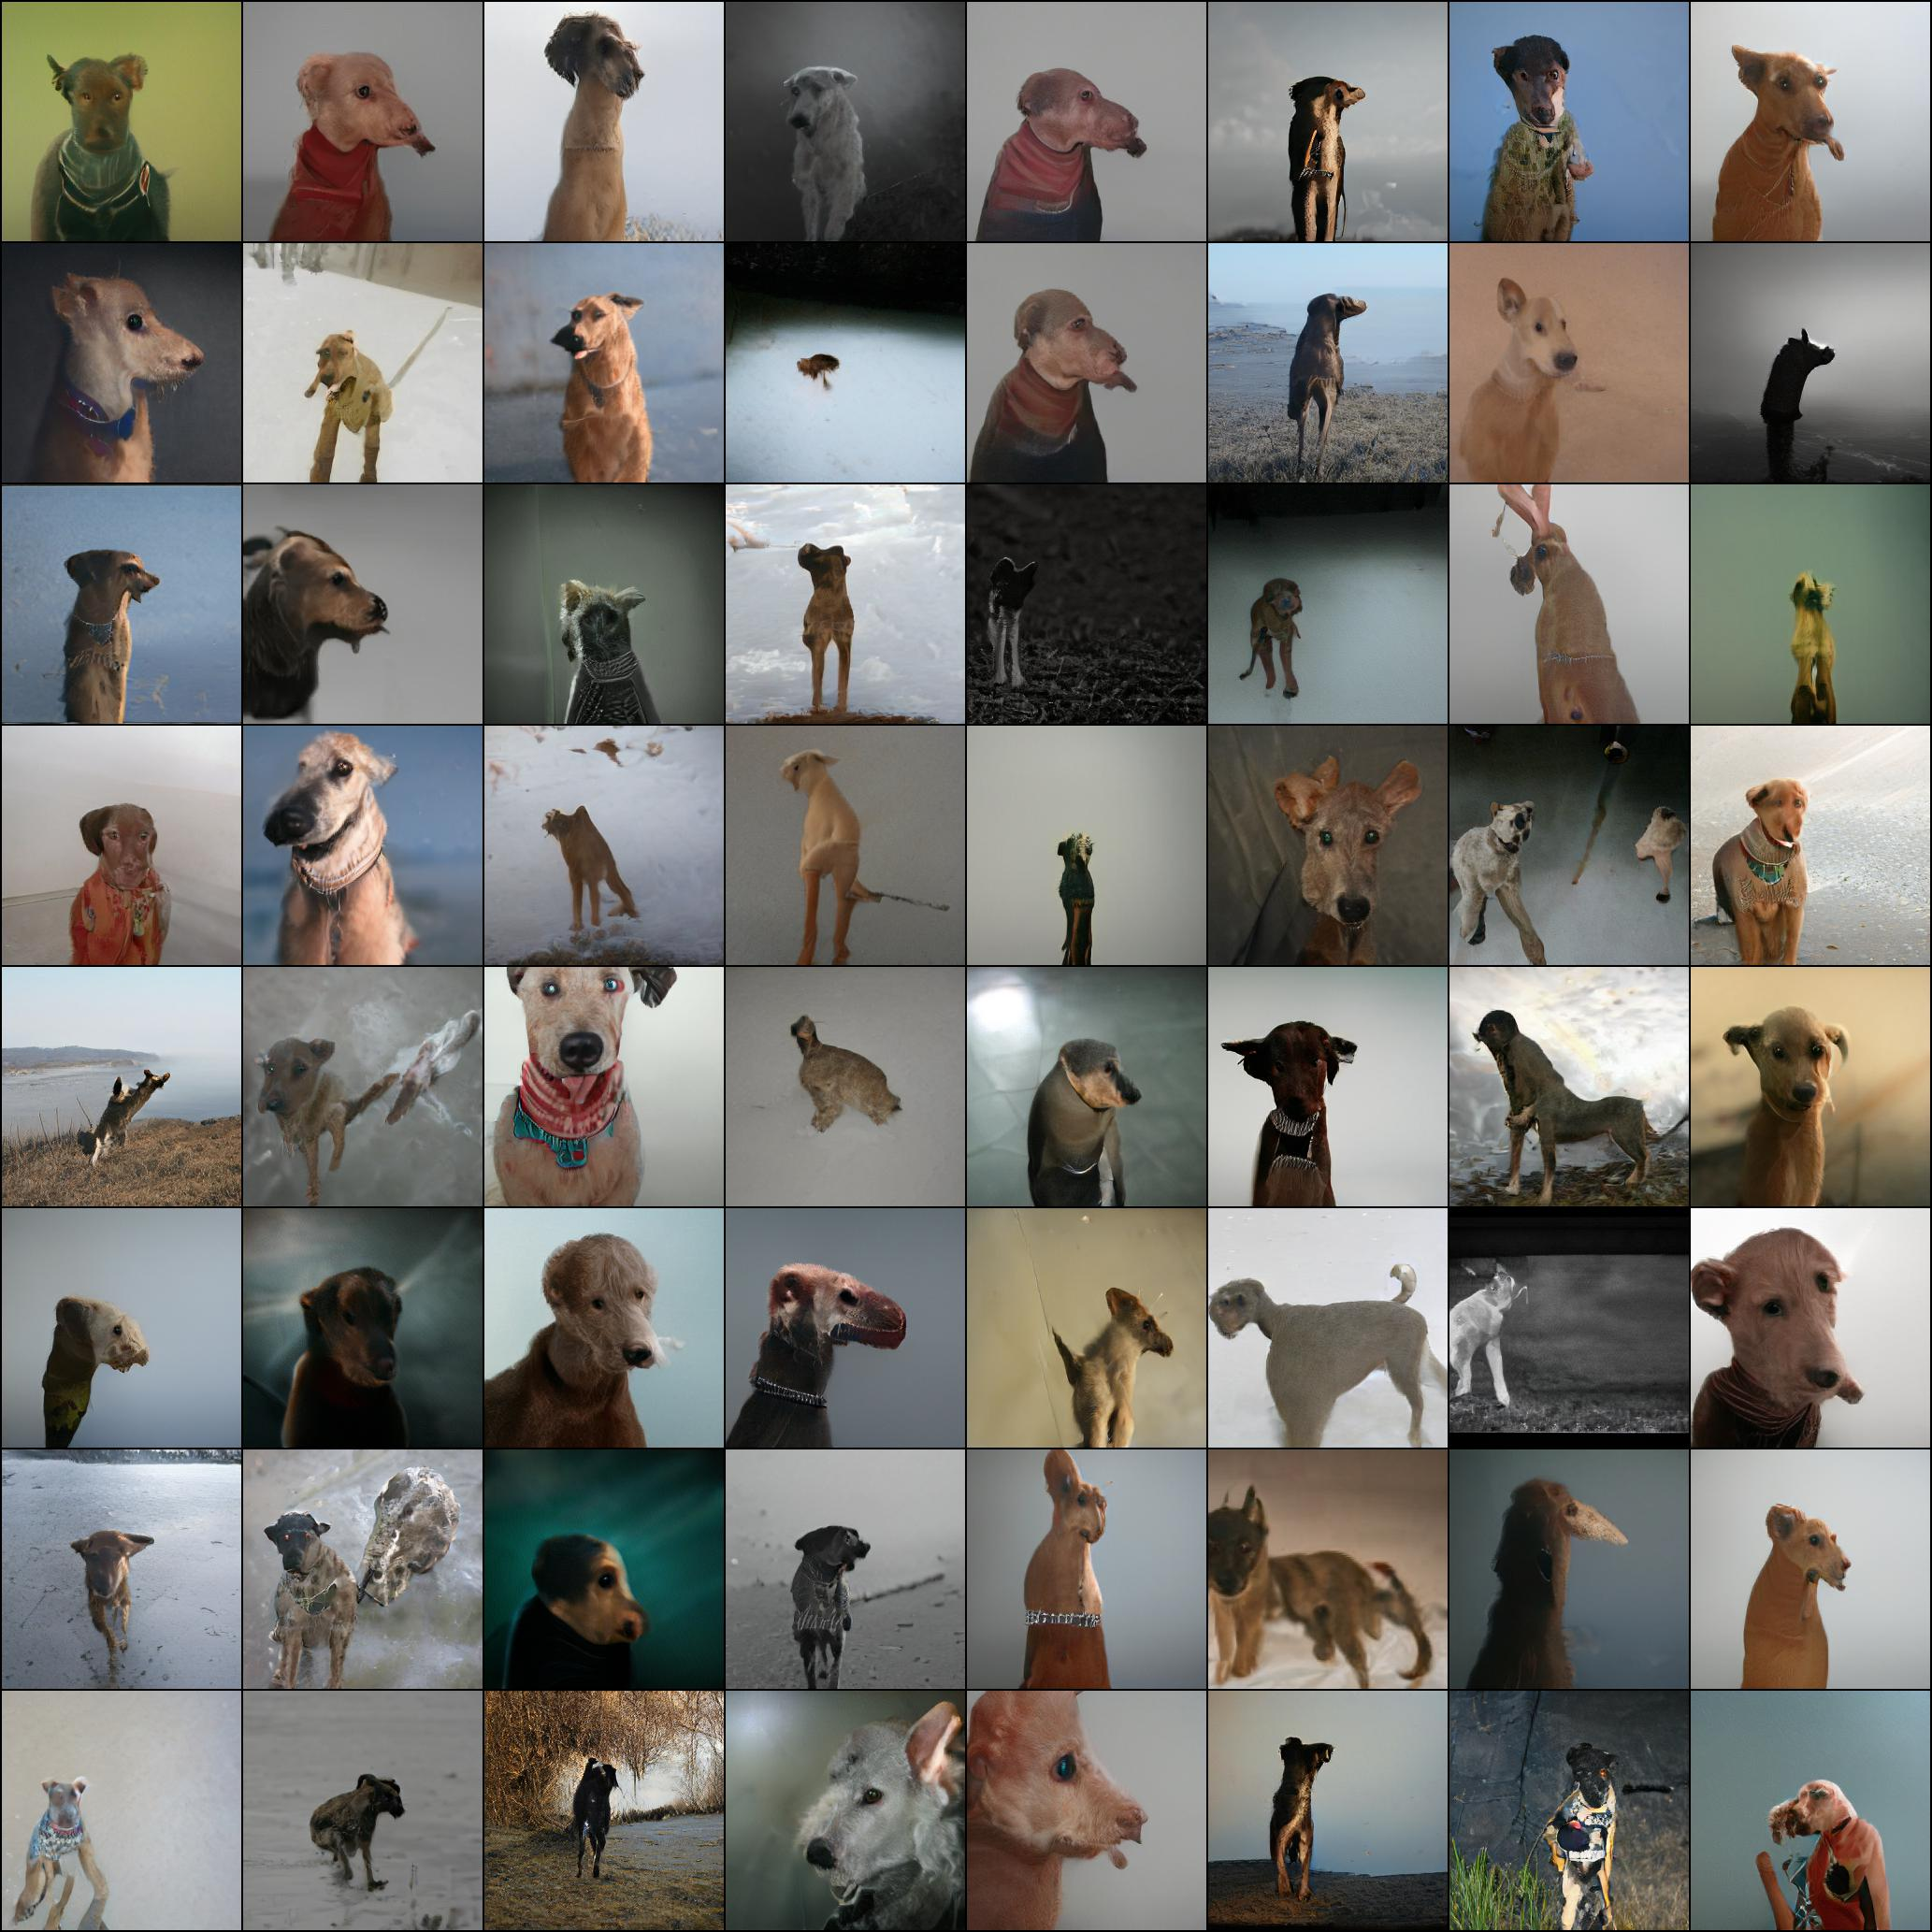

   31 |    1984 |  0.00000E+00 |  0.00000E+00 |        -0.37 |       -0.342
   32 |    2048 |  0.00000E+00 |  0.00000E+00 |        -0.37 |       -0.344
   33 |    2112 |  0.00000E+00 |  0.00000E+00 |        -0.37 |      -0.3452
   34 |    2176 |  0.00000E+00 |  0.00000E+00 |      -0.3748 |      -0.3464
   35 |    2240 |  0.00000E+00 |  0.00000E+00 |      -0.3748 |      -0.3486
   36 |    2304 |  0.00000E+00 |  0.00000E+00 |      -0.3748 |      -0.3503
   37 |    2368 |  0.00000E+00 |  0.00000E+00 |      -0.3748 |      -0.3523
   38 |    2432 |  0.00000E+00 |  0.00000E+00 |       -0.379 |      -0.3538
   39 |    2496 |  0.00000E+00 |  0.00000E+00 |       -0.379 |      -0.3545
   40 |    2560 |  0.00000E+00 |  0.00000E+00 |       -0.379 |      -0.3547
After 40 iterations...


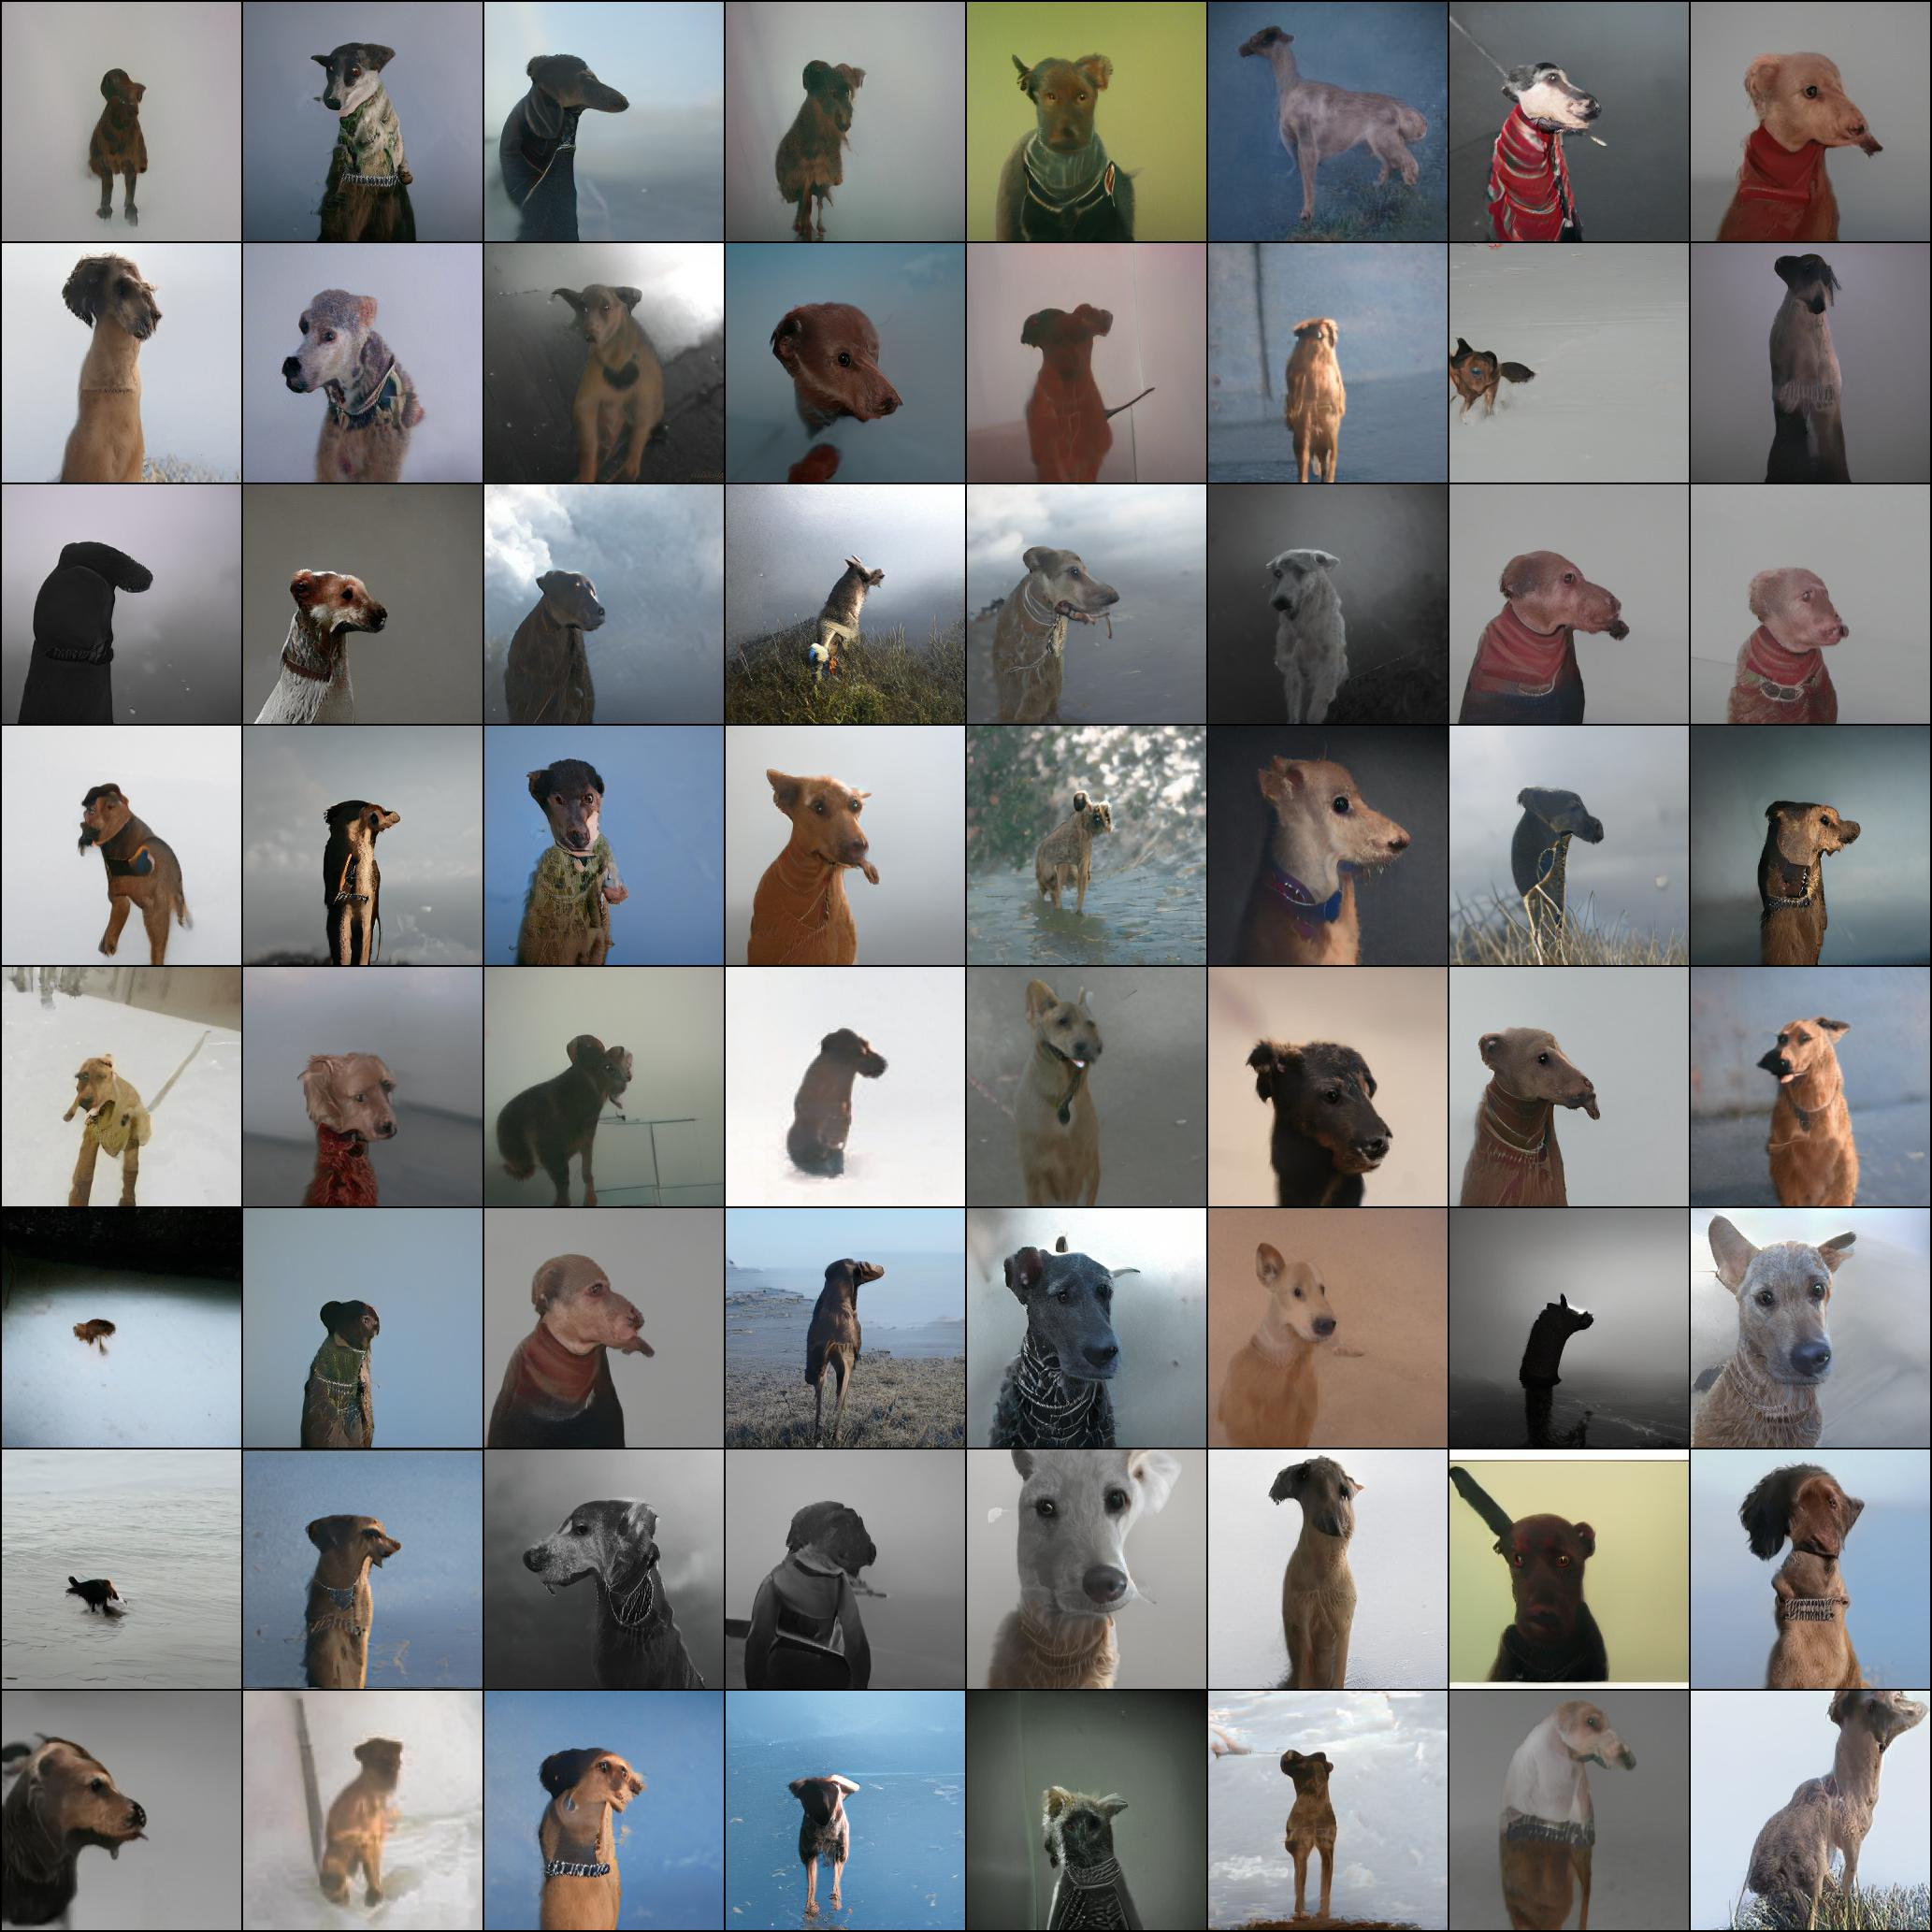

   41 |    2624 |  0.00000E+00 |  0.00000E+00 |       -0.379 |      -0.3557
   42 |    2688 |  0.00000E+00 |  0.00000E+00 |       -0.379 |       -0.356
   43 |    2752 |  0.00000E+00 |  0.00000E+00 |       -0.379 |       -0.357
   44 |    2816 |  0.00000E+00 |  0.00000E+00 |       -0.379 |      -0.3577
   45 |    2880 |  0.00000E+00 |  0.00000E+00 |       -0.379 |      -0.3584
   46 |    2944 |  0.00000E+00 |  0.00000E+00 |       -0.379 |       -0.359
   47 |    3008 |  0.00000E+00 |  0.00000E+00 |       -0.379 |      -0.3596
   48 |    3072 |  0.00000E+00 |  0.00000E+00 |       -0.379 |      -0.3606
   49 |    3136 |  0.00000E+00 |  0.00000E+00 |       -0.379 |      -0.3613
   50 |    3200 |  0.00000E+00 |  0.00000E+00 |       -0.379 |      -0.3618
After 50 iterations...


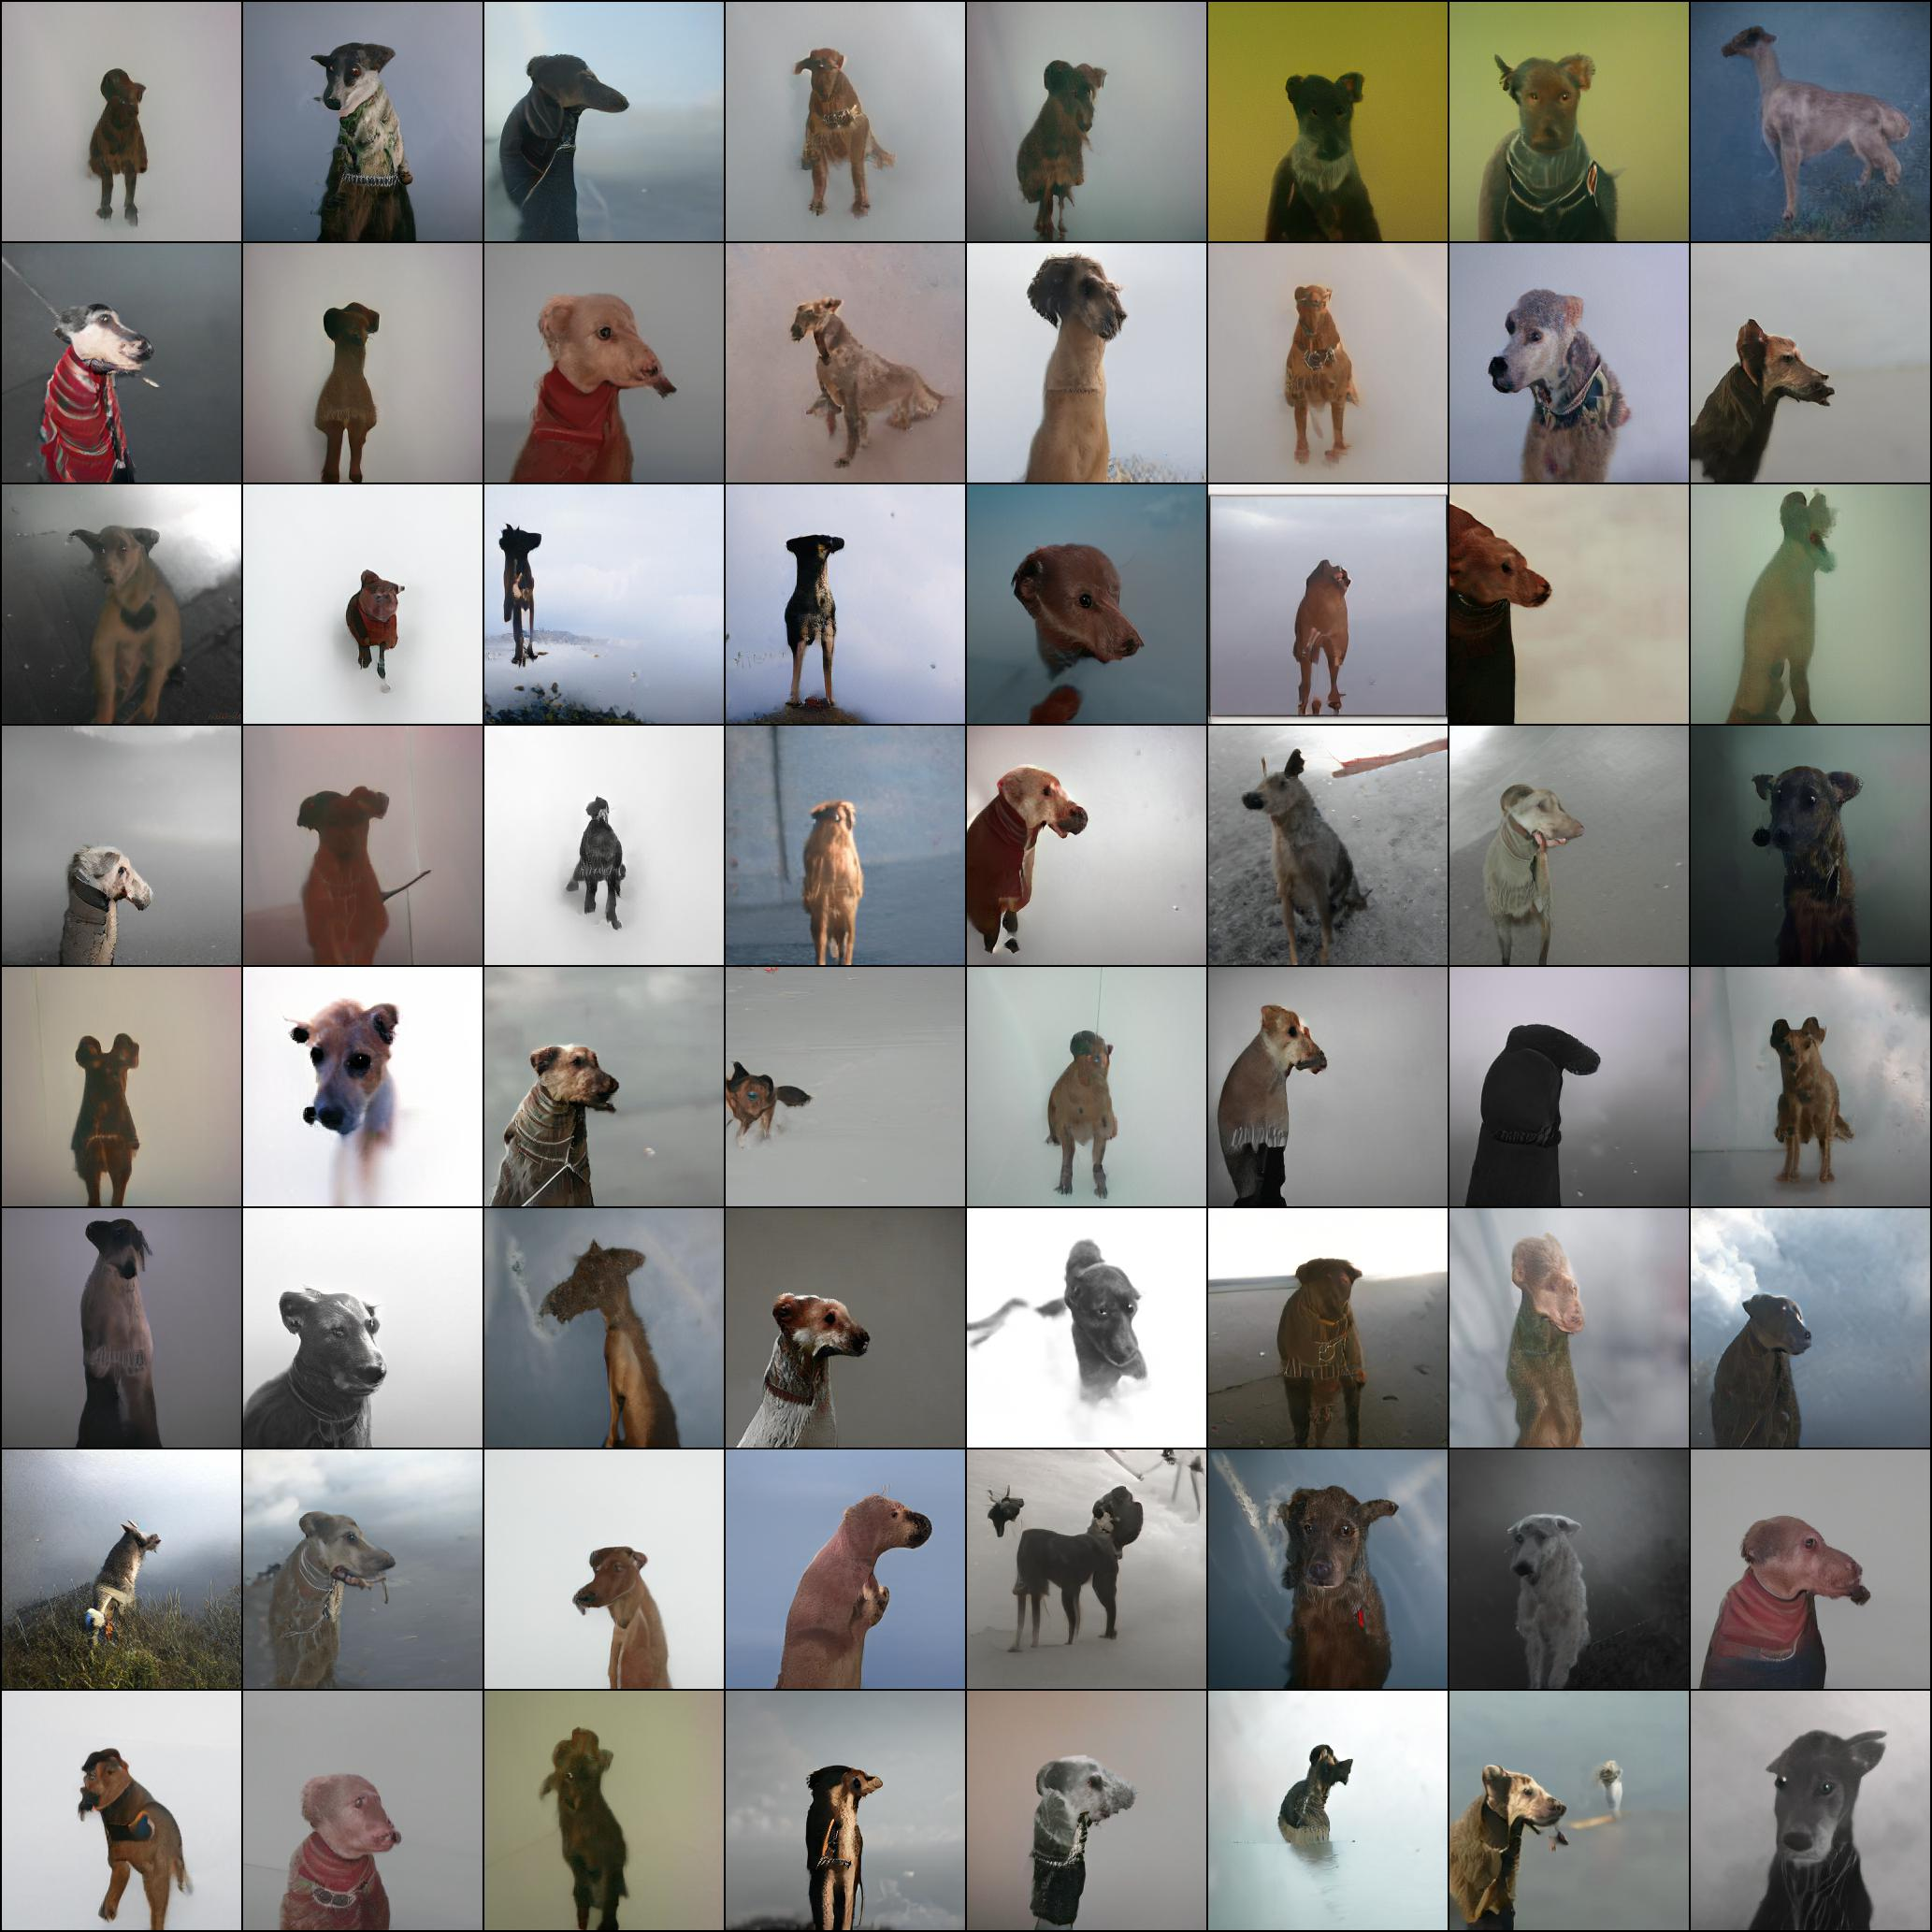

   51 |    3264 |  0.00000E+00 |  0.00000E+00 |       -0.379 |       -0.362
   52 |    3328 |  0.00000E+00 |  0.00000E+00 |       -0.379 |       -0.363
   53 |    3392 |  0.00000E+00 |  0.00000E+00 |       -0.379 |      -0.3638
   54 |    3456 |  0.00000E+00 |  0.00000E+00 |       -0.379 |       -0.364
   55 |    3520 |  0.00000E+00 |  0.00000E+00 |       -0.379 |      -0.3645
   56 |    3584 |  0.00000E+00 |  0.00000E+00 |       -0.379 |       -0.365
   57 |    3648 |  0.00000E+00 |  0.00000E+00 |       -0.379 |      -0.3655
   58 |    3712 |  0.00000E+00 |  0.00000E+00 |       -0.379 |       -0.366
   59 |    3776 |  0.00000E+00 |  0.00000E+00 |       -0.379 |      -0.3665
   60 |    3840 |  0.00000E+00 |  0.00000E+00 |       -0.379 |      -0.3667
After 60 iterations...


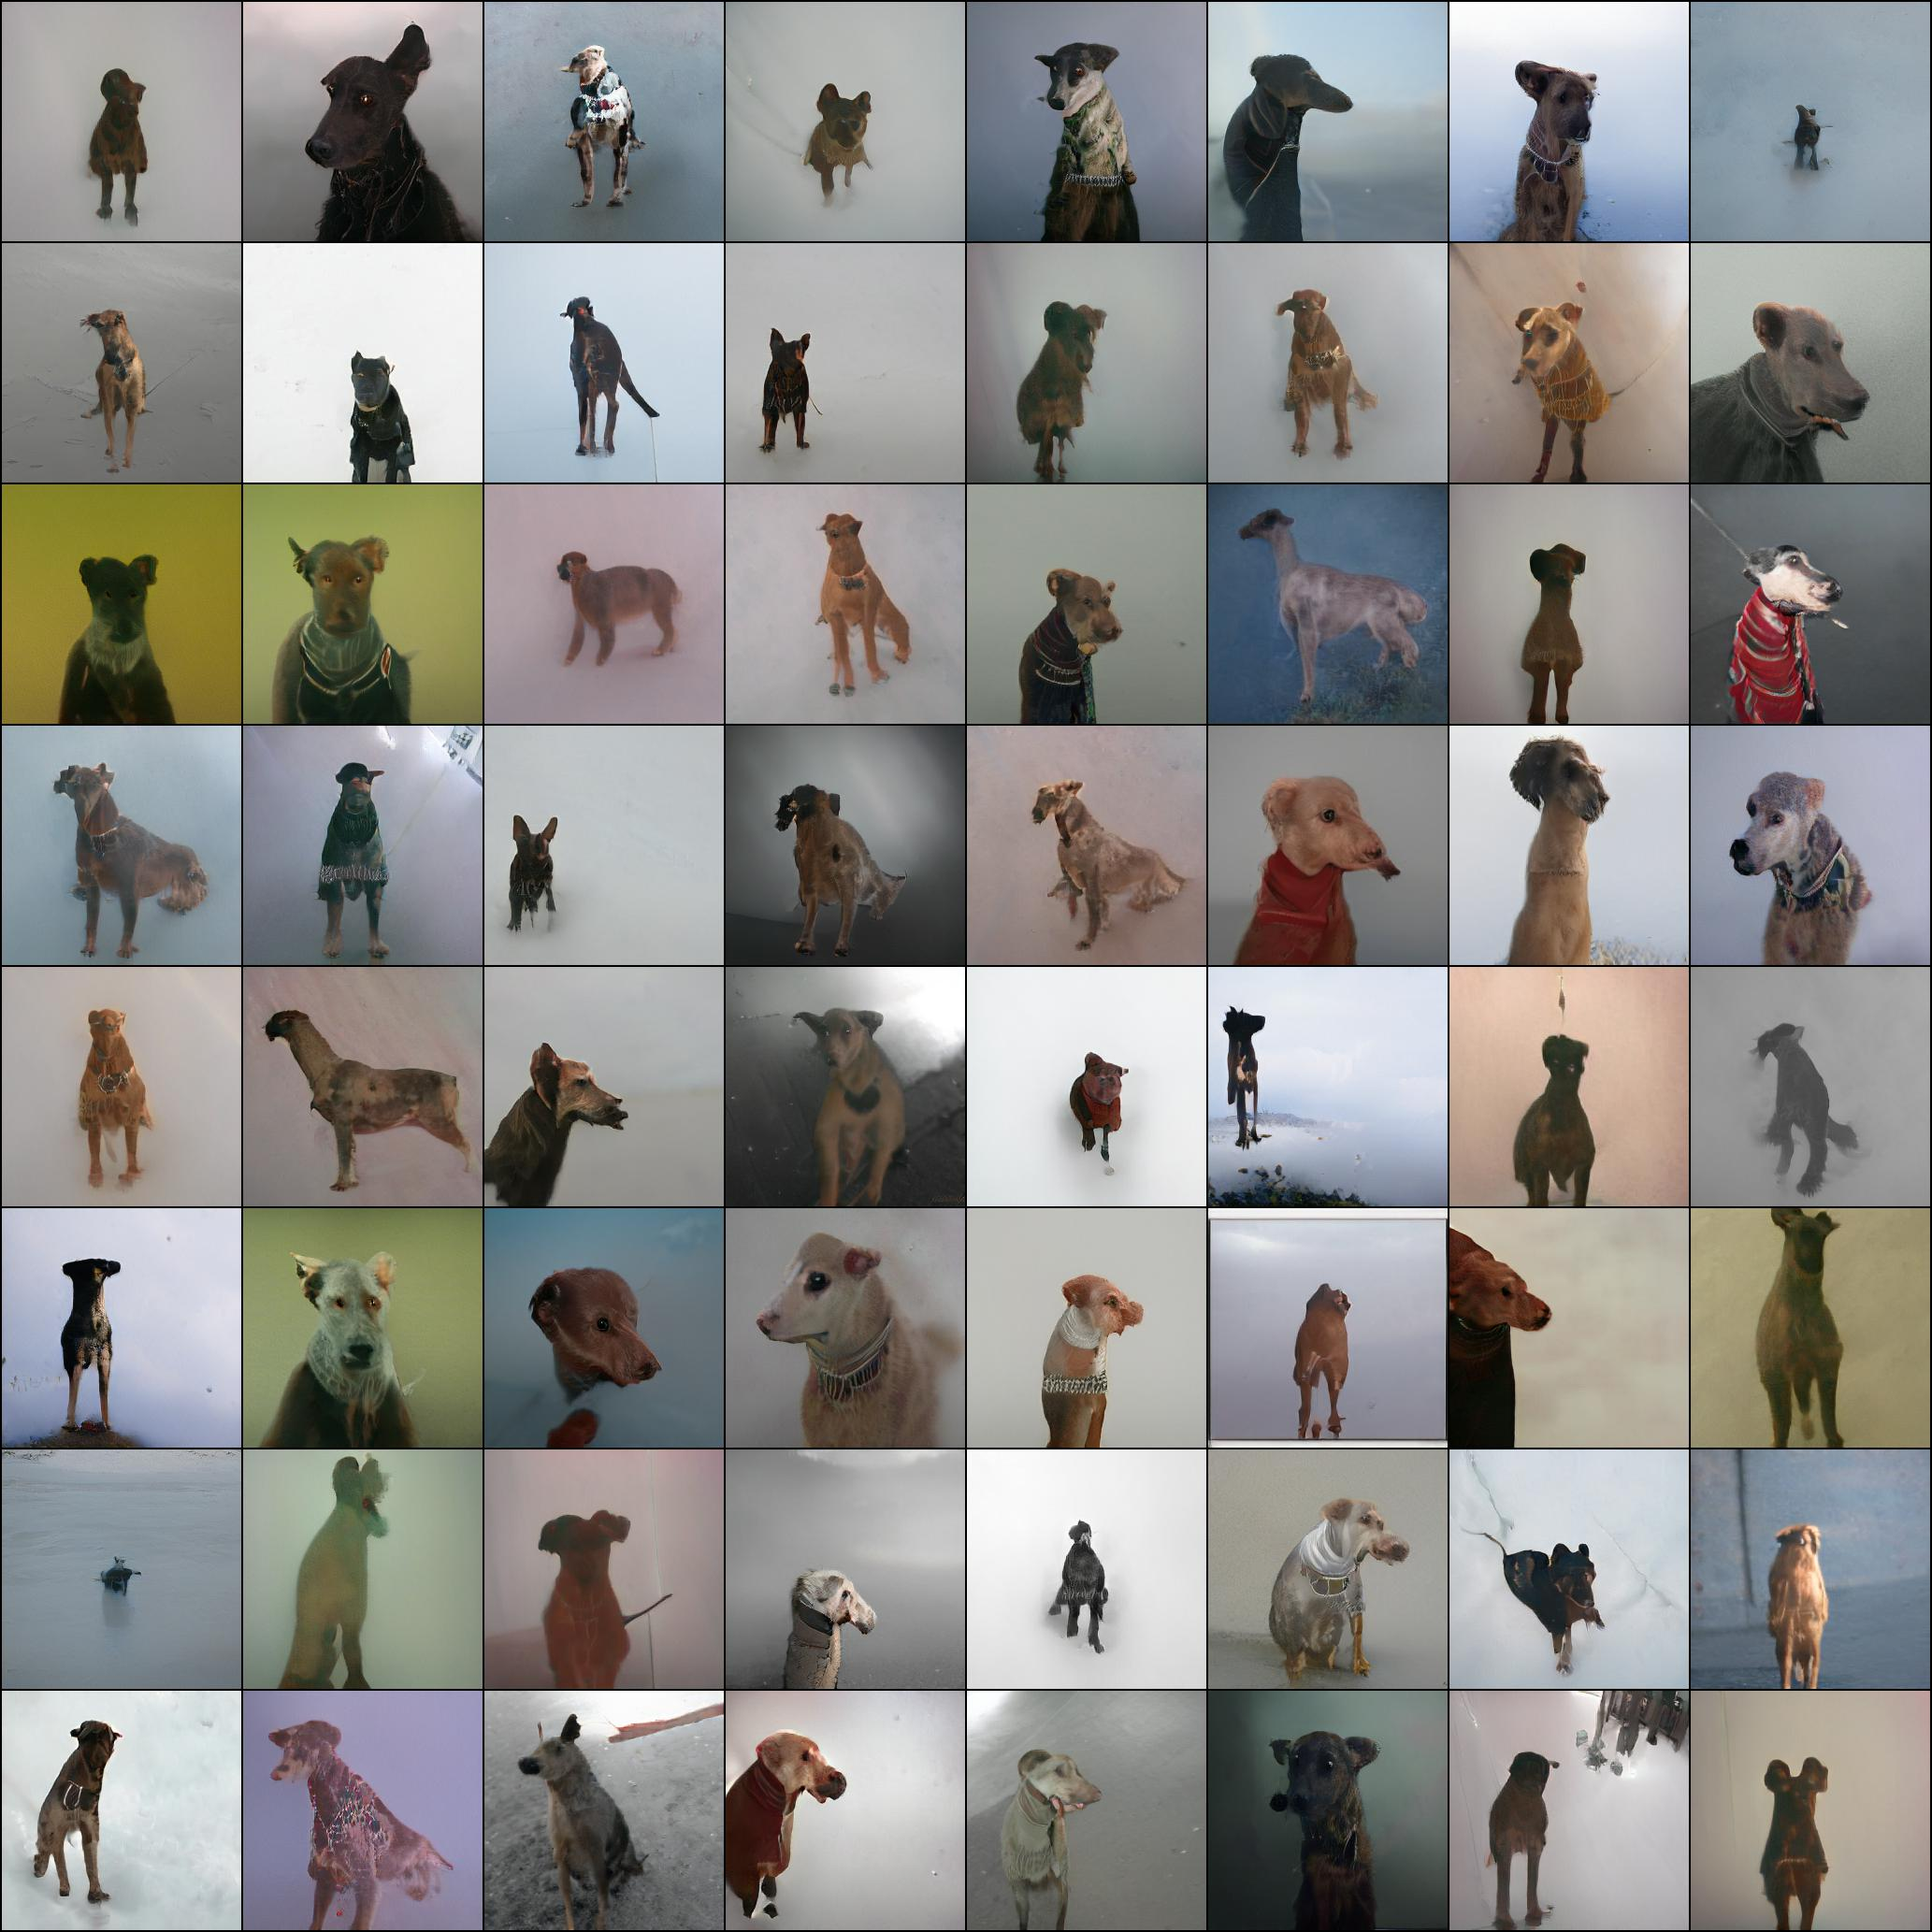

   61 |    3904 |  0.00000E+00 |  0.00000E+00 |       -0.379 |       -0.367
   62 |    3968 |  0.00000E+00 |  0.00000E+00 |       -0.379 |      -0.3672
   63 |    4032 |  0.00000E+00 |  0.00000E+00 |       -0.379 |      -0.3677
   64 |    4096 |  0.00000E+00 |  0.00000E+00 |       -0.379 |      -0.3682
   65 |    4160 |  0.00000E+00 |  0.00000E+00 |       -0.379 |      -0.3684
   66 |    4224 |  0.00000E+00 |  0.00000E+00 |      -0.3813 |       -0.369
   67 |    4288 |  0.00000E+00 |  0.00000E+00 |      -0.3813 |      -0.3694
   68 |    4352 |  0.00000E+00 |  0.00000E+00 |      -0.3813 |      -0.3699
   69 |    4416 |  0.00000E+00 |  0.00000E+00 |      -0.3813 |        -0.37
   70 |    4480 |  0.00000E+00 |  0.00000E+00 |      -0.3813 |      -0.3704
After 70 iterations...


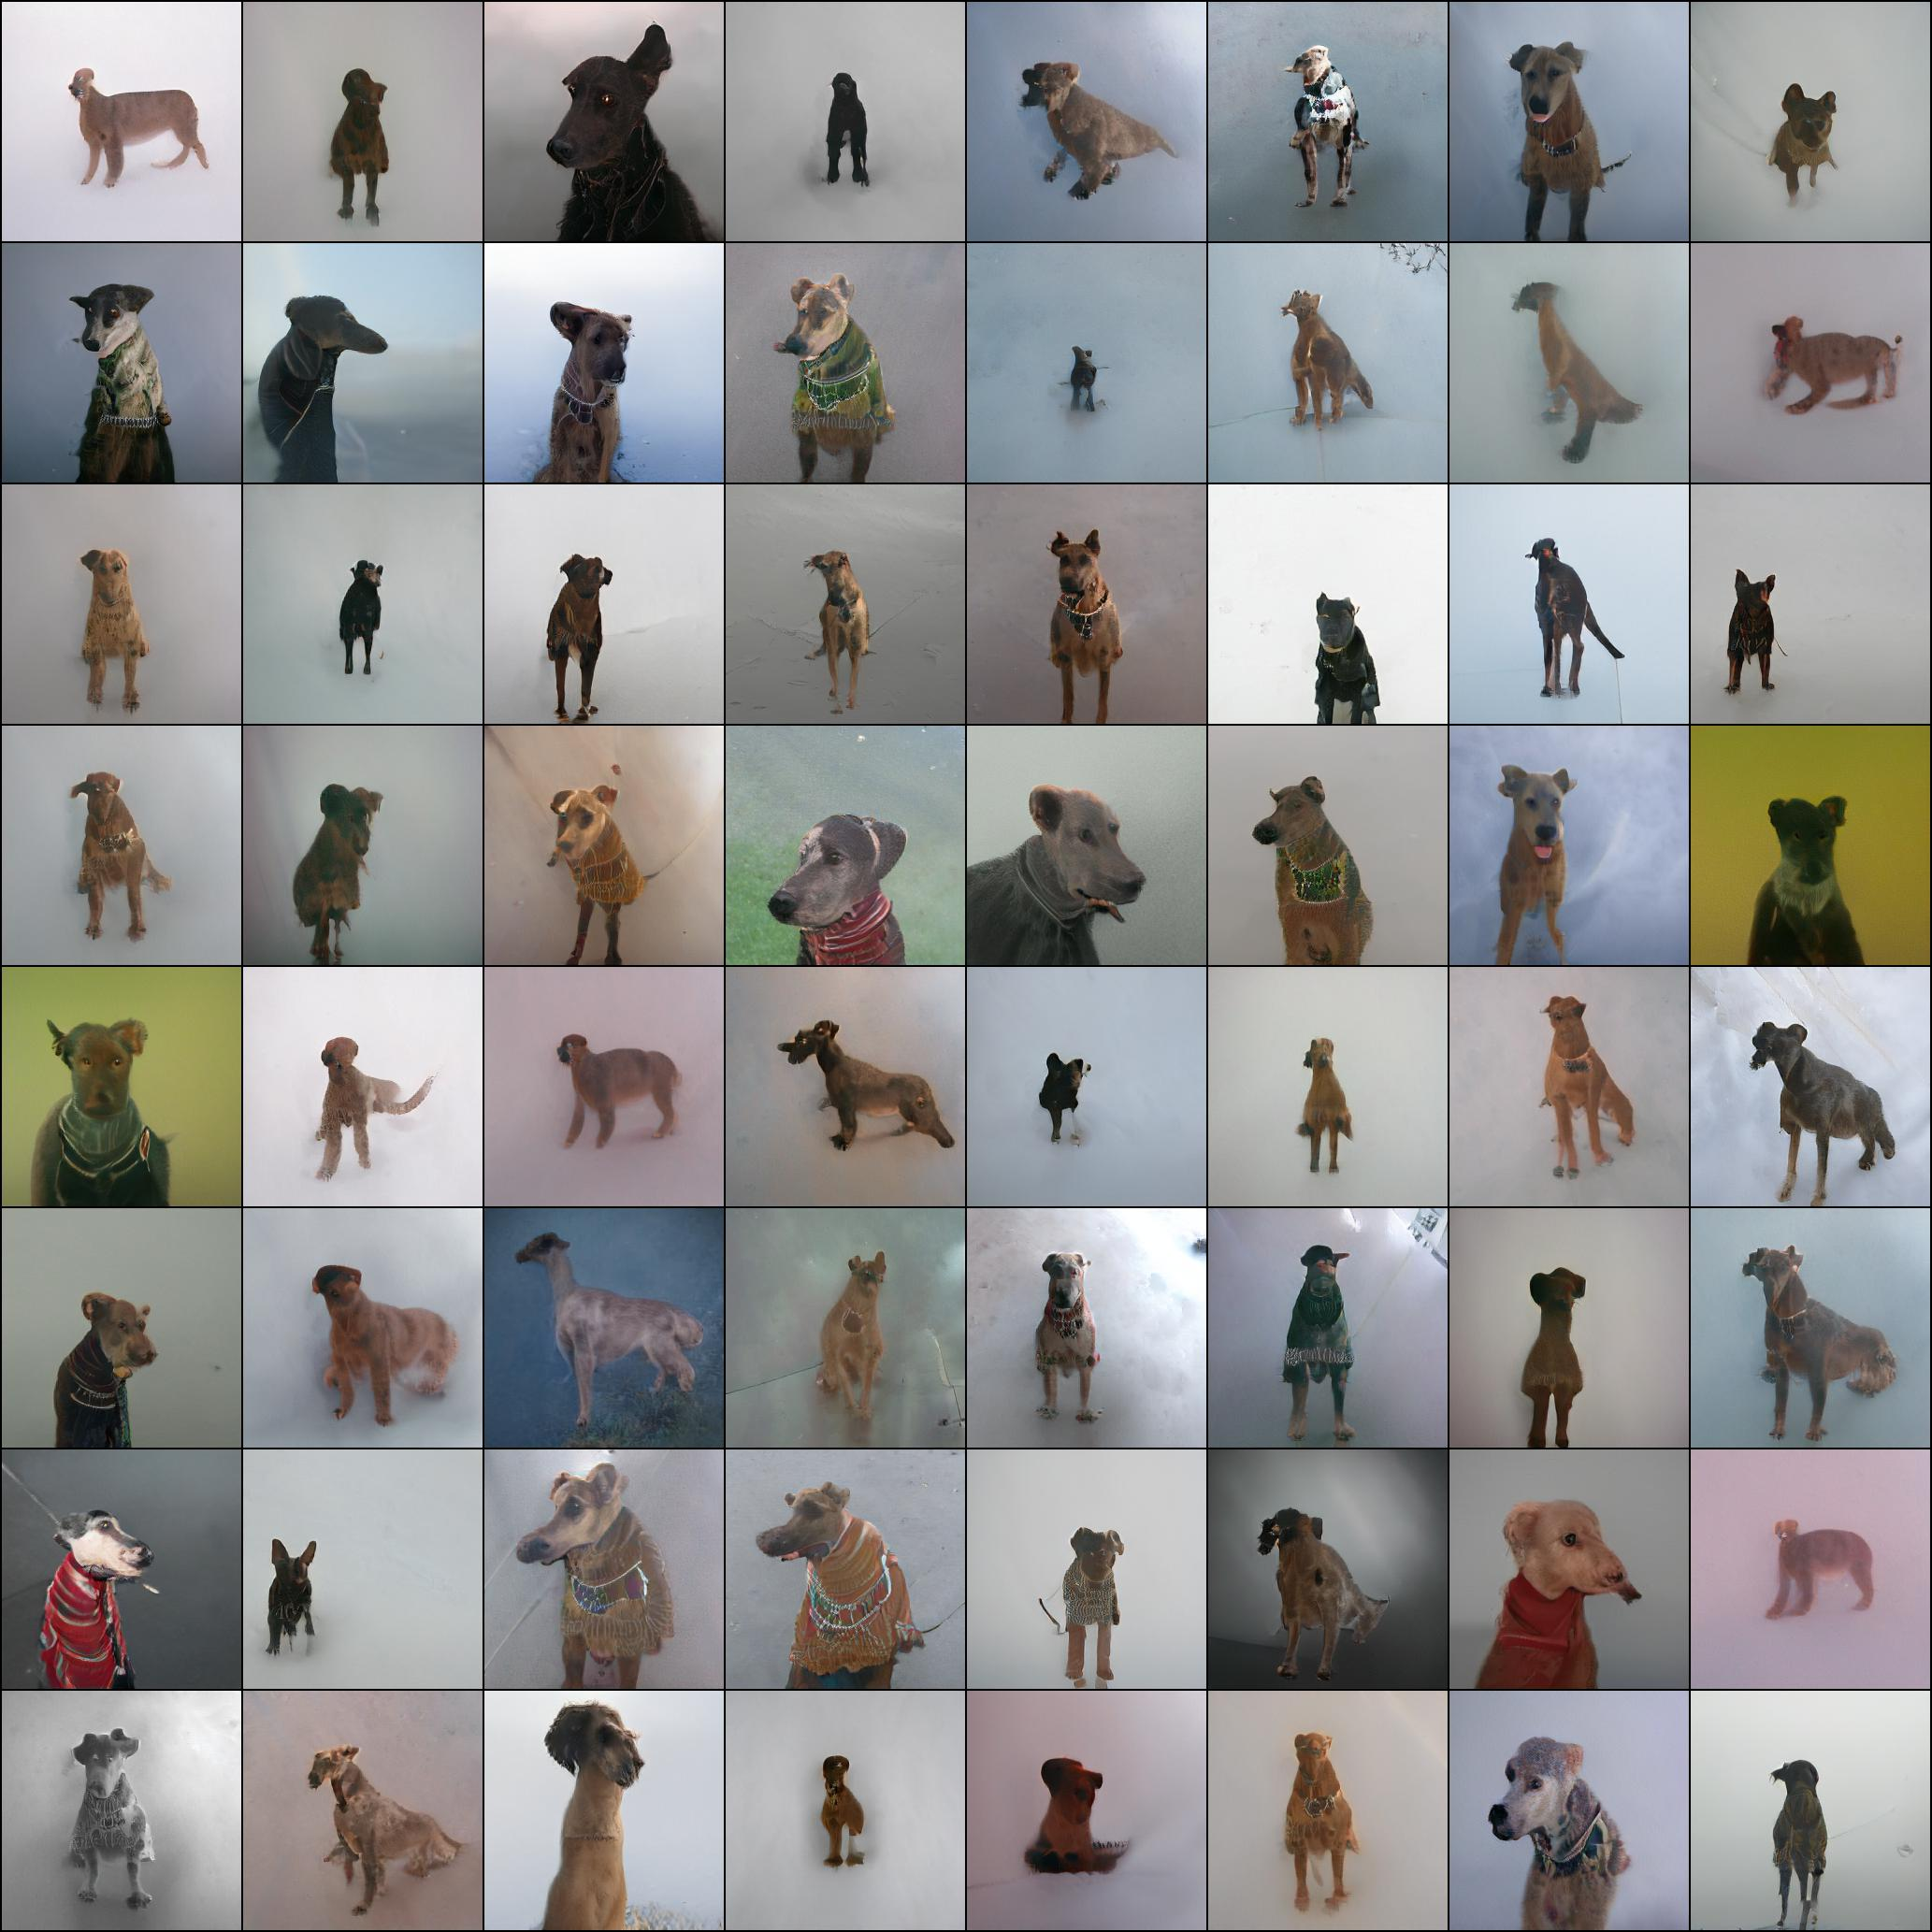

   71 |    4544 |  0.00000E+00 |  0.00000E+00 |      -0.3813 |      -0.3706
   72 |    4608 |  0.00000E+00 |  0.00000E+00 |      -0.3813 |       -0.371
   73 |    4672 |  0.00000E+00 |  0.00000E+00 |      -0.3813 |       -0.371
   74 |    4736 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3718
   75 |    4800 |  0.00000E+00 |  0.00000E+00 |       -0.396 |       -0.372
   76 |    4864 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3723
   77 |    4928 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3726
   78 |    4992 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3728
   79 |    5056 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3728
   80 |    5120 |  0.00000E+00 |  0.00000E+00 |       -0.396 |       -0.373
After 80 iterations...


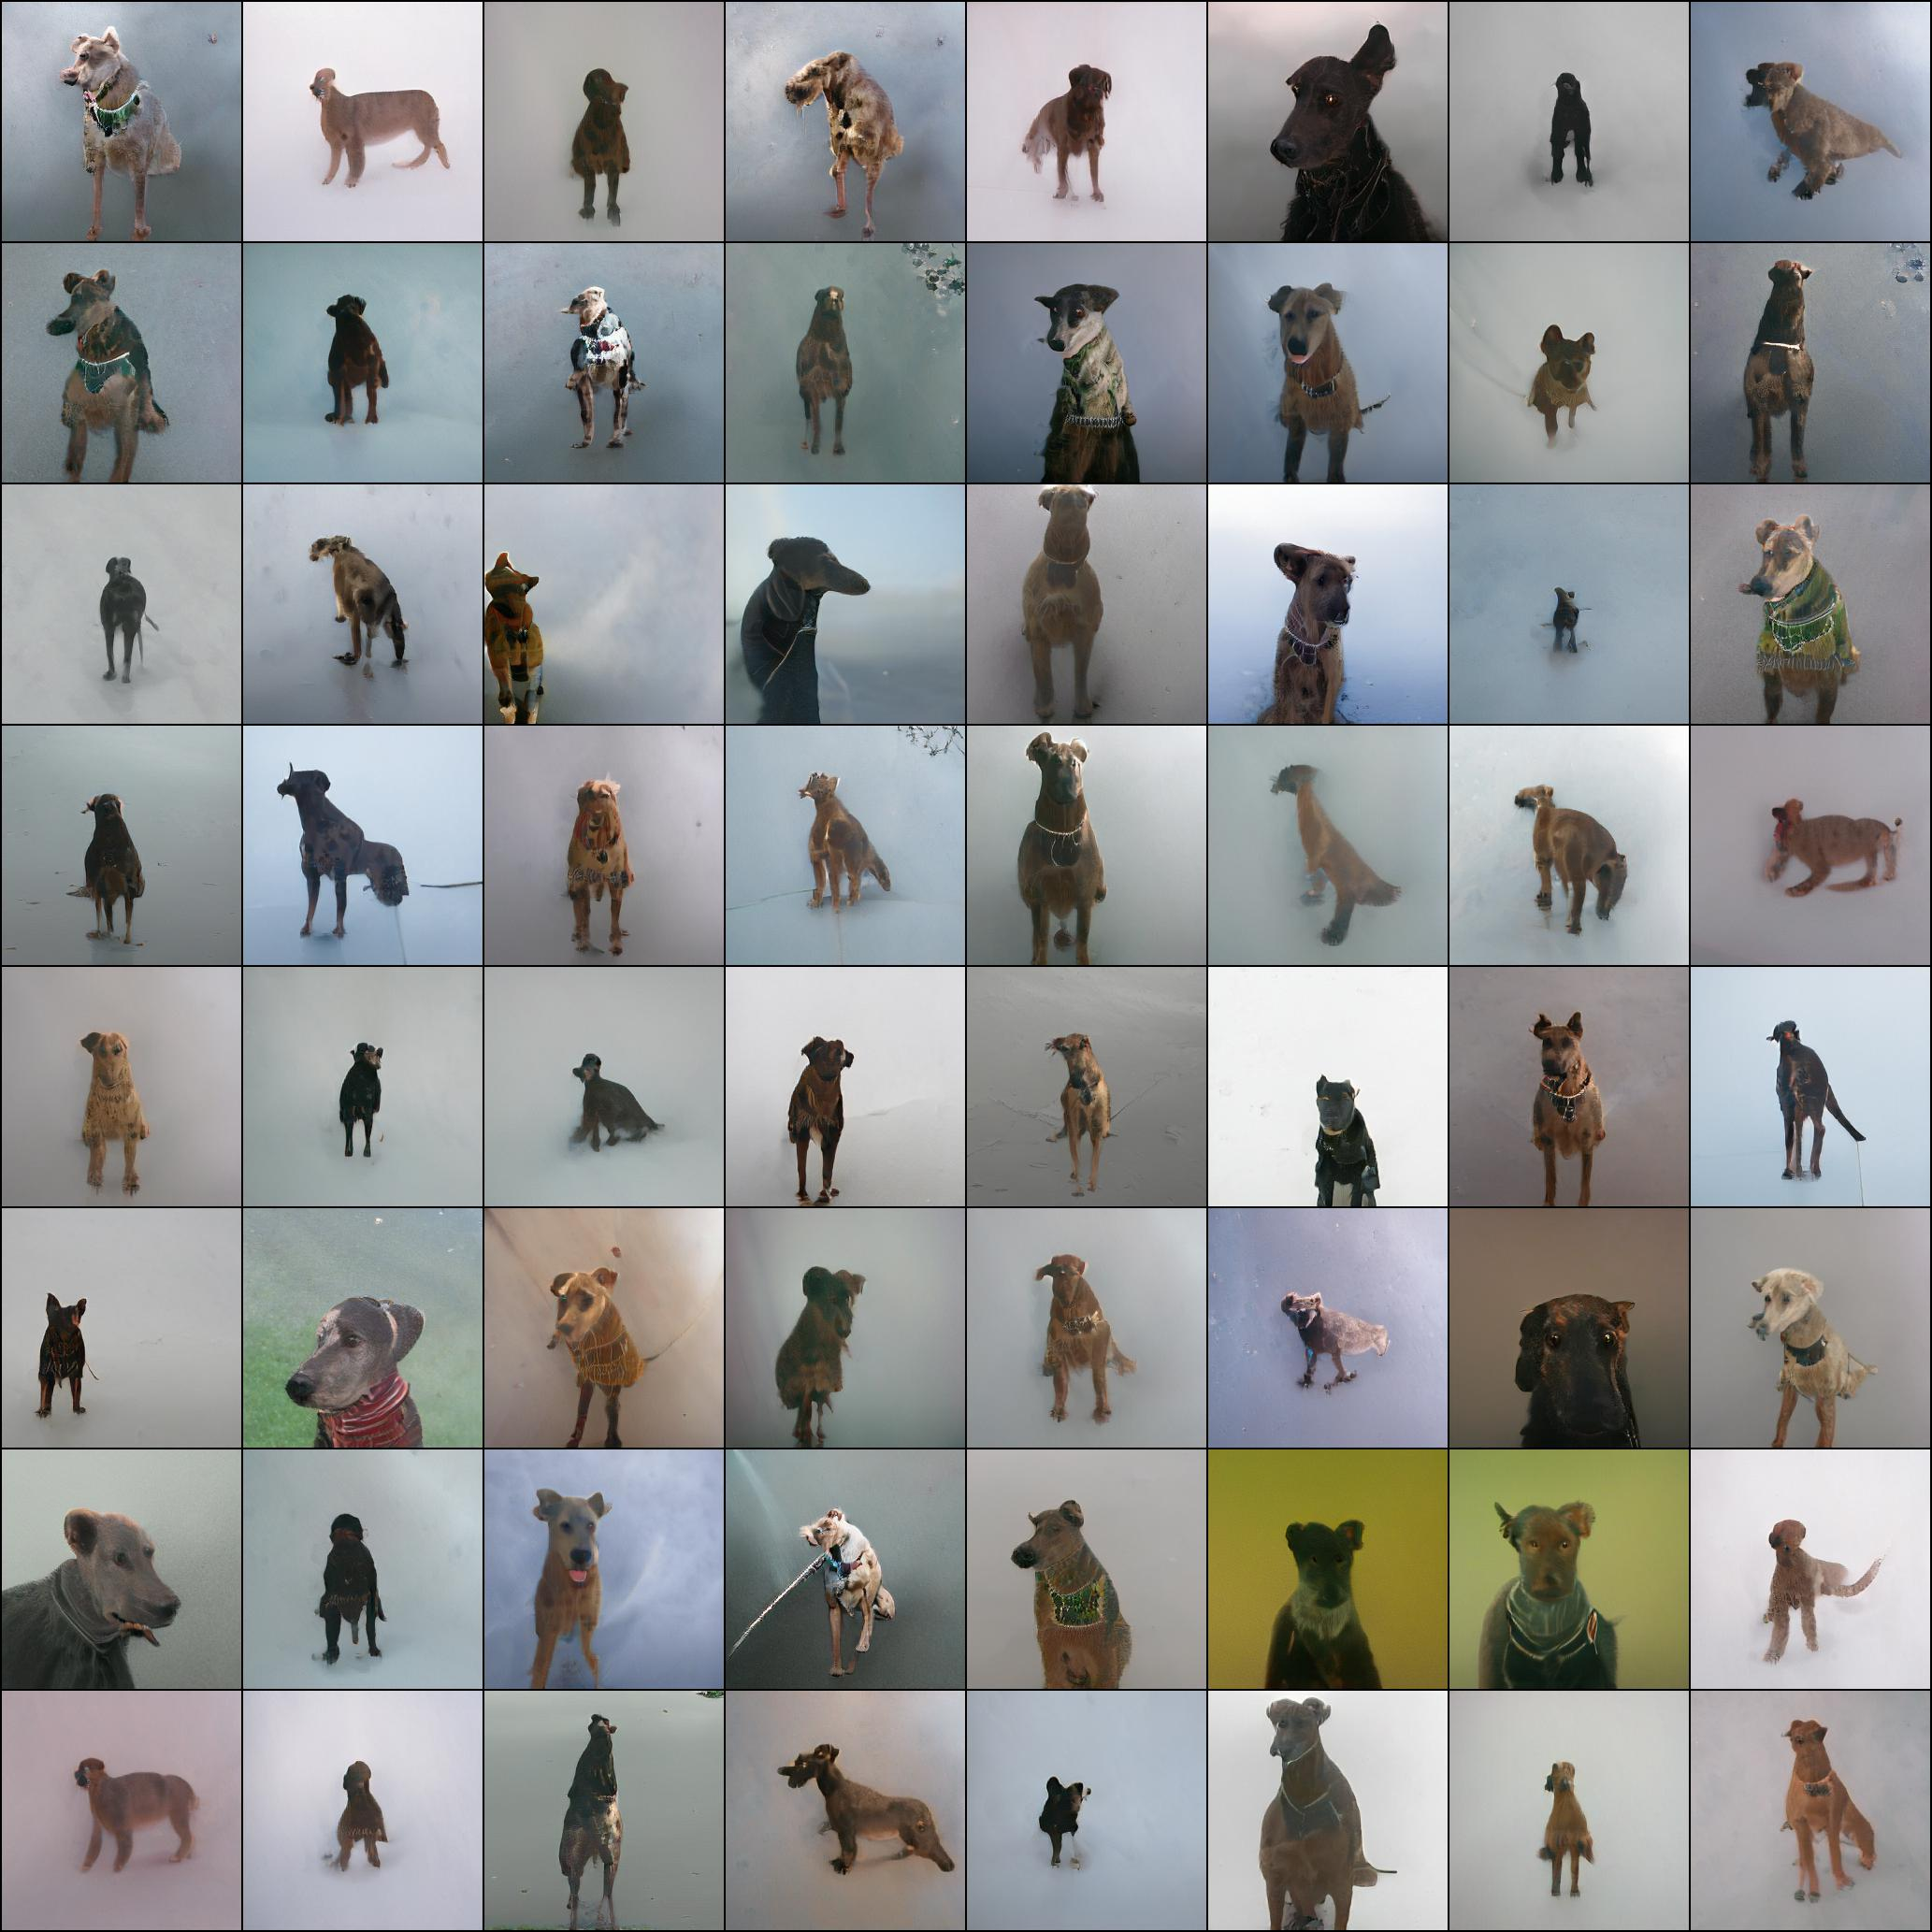

   81 |    5184 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3735
   82 |    5248 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3735
   83 |    5312 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3738
   84 |    5376 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3738
   85 |    5440 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3738
   86 |    5504 |  0.00000E+00 |  0.00000E+00 |       -0.396 |       -0.374
   87 |    5568 |  0.00000E+00 |  0.00000E+00 |       -0.396 |       -0.374
   88 |    5632 |  0.00000E+00 |  0.00000E+00 |       -0.396 |       -0.374
   89 |    5696 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3743
   90 |    5760 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3745
After 90 iterations...


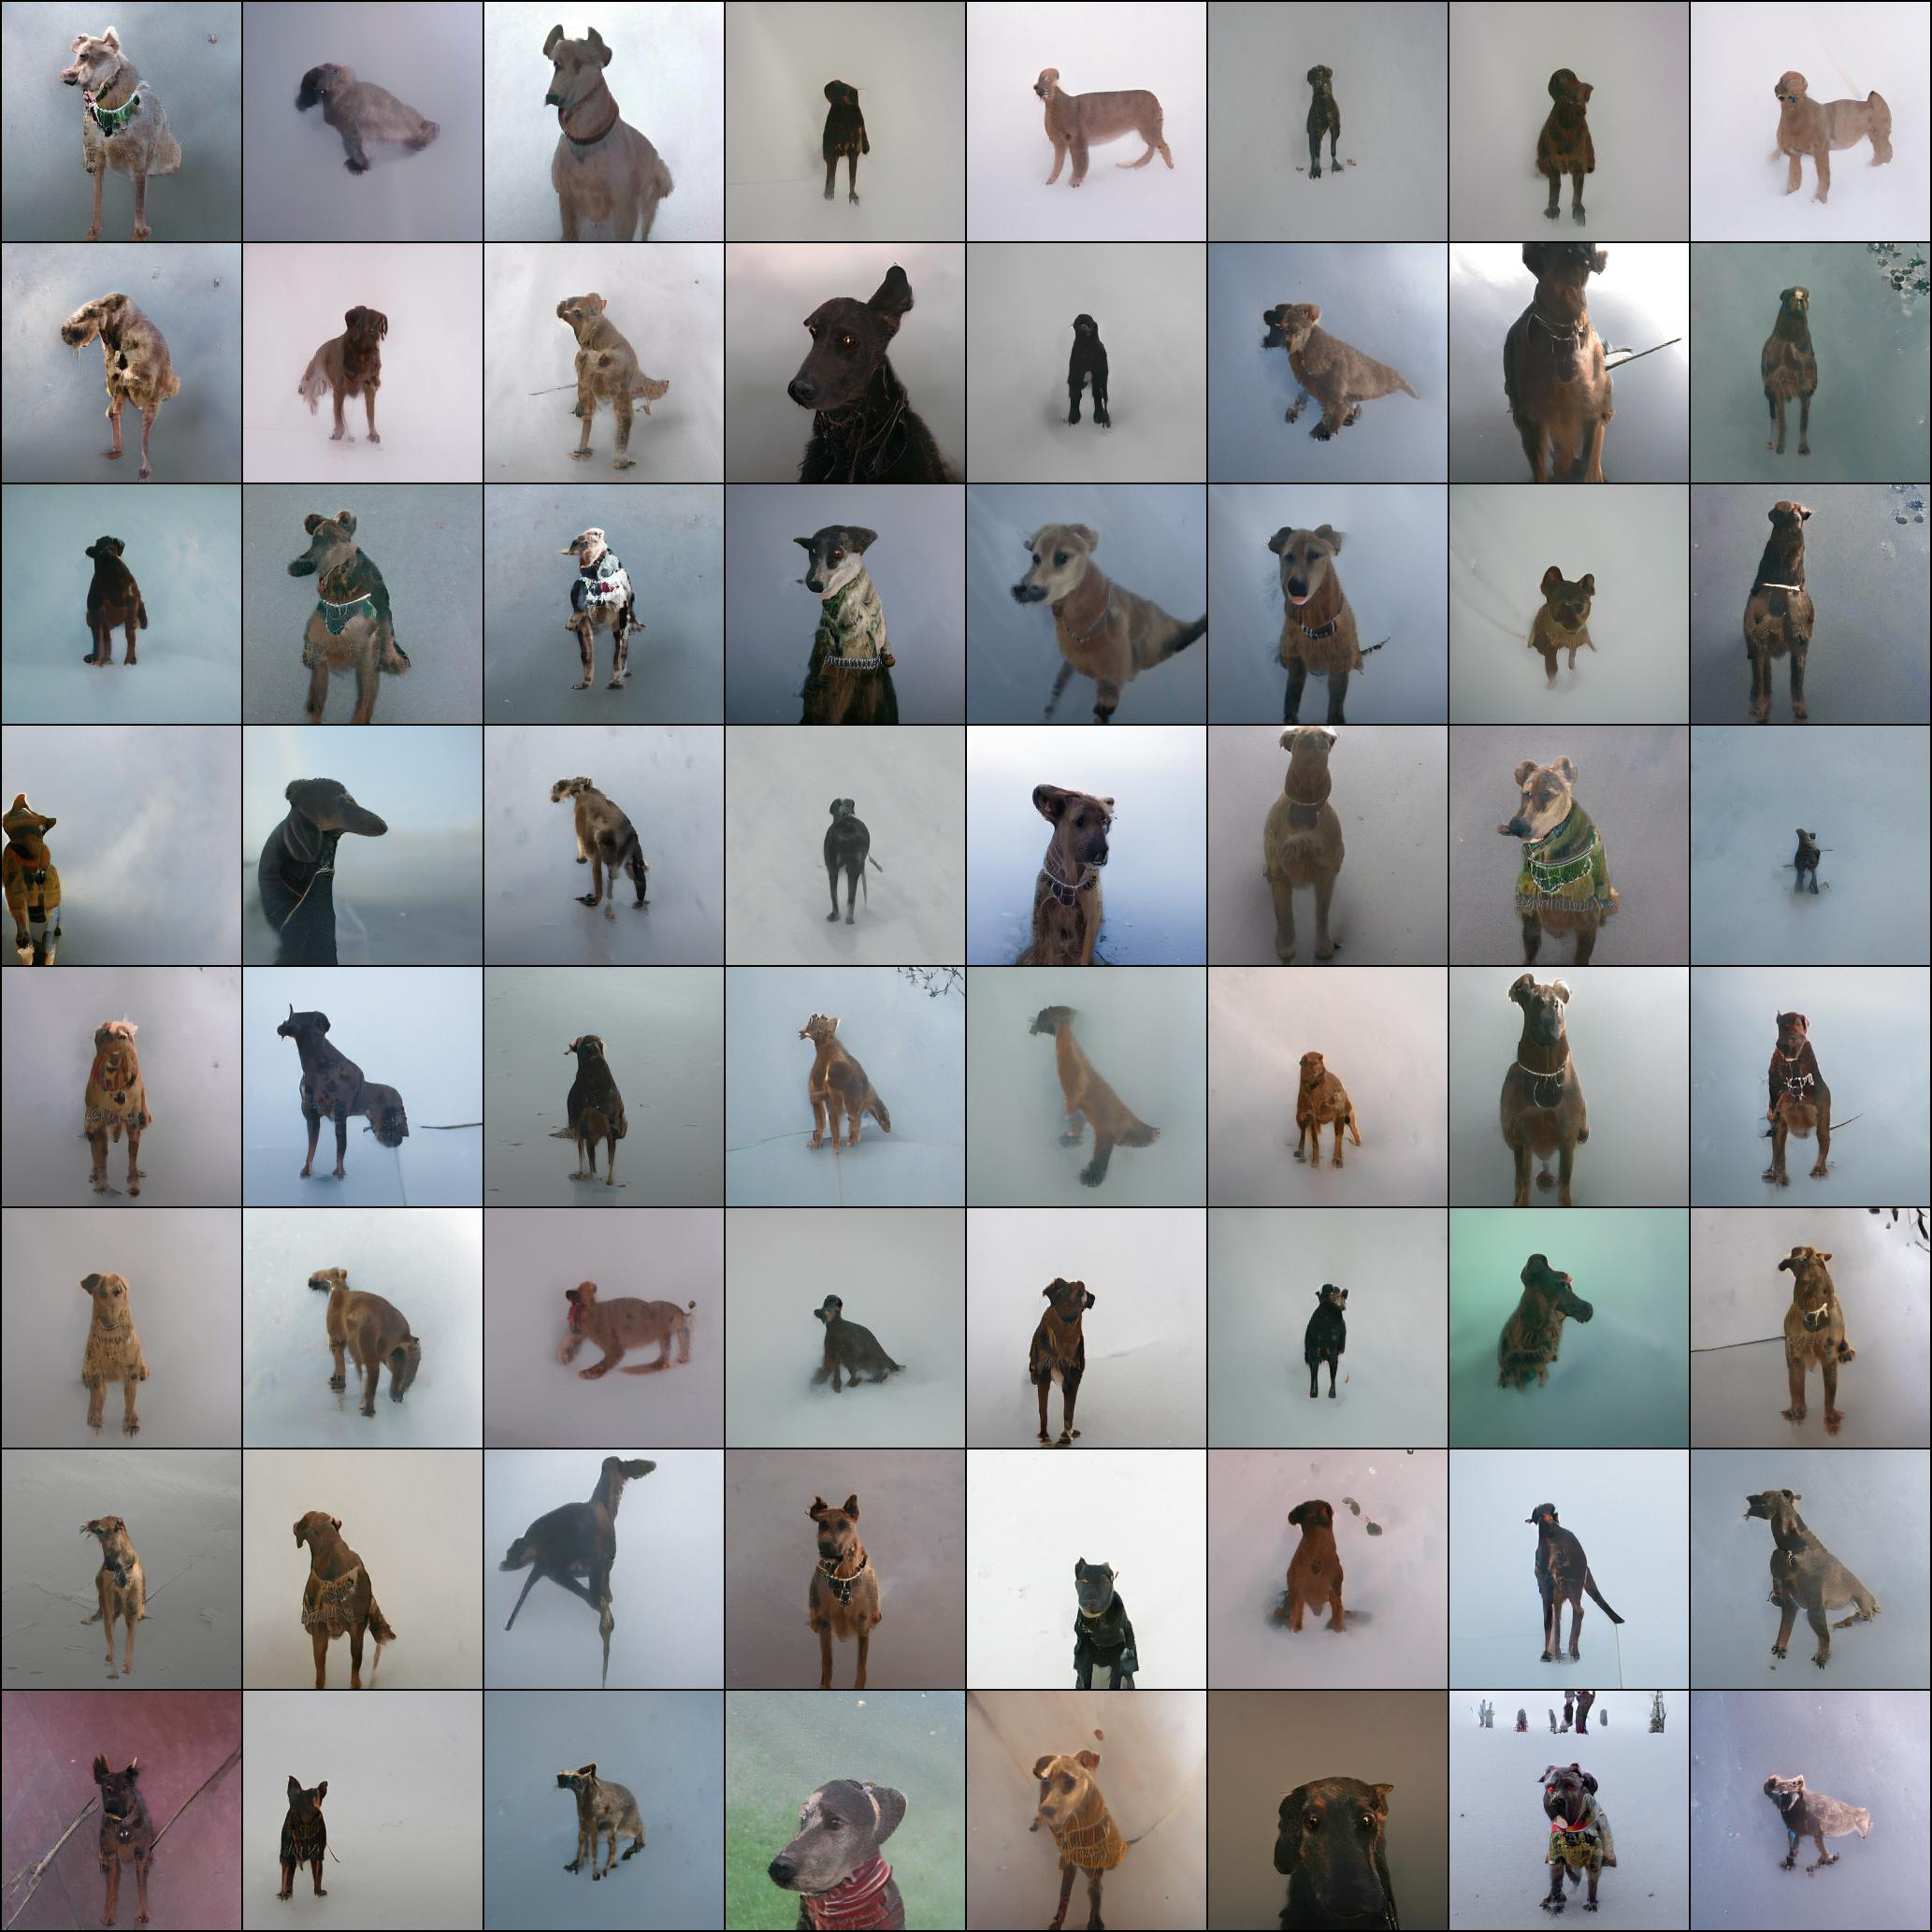

   91 |    5824 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3745
   92 |    5888 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3748
   93 |    5952 |  0.00000E+00 |  0.00000E+00 |       -0.396 |       -0.375
   94 |    6016 |  0.00000E+00 |  0.00000E+00 |       -0.396 |       -0.375
   95 |    6080 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3752
   96 |    6144 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3755
   97 |    6208 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3755
   98 |    6272 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3757
   99 |    6336 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3757
  100 |    6400 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3757
After 100 iterations...


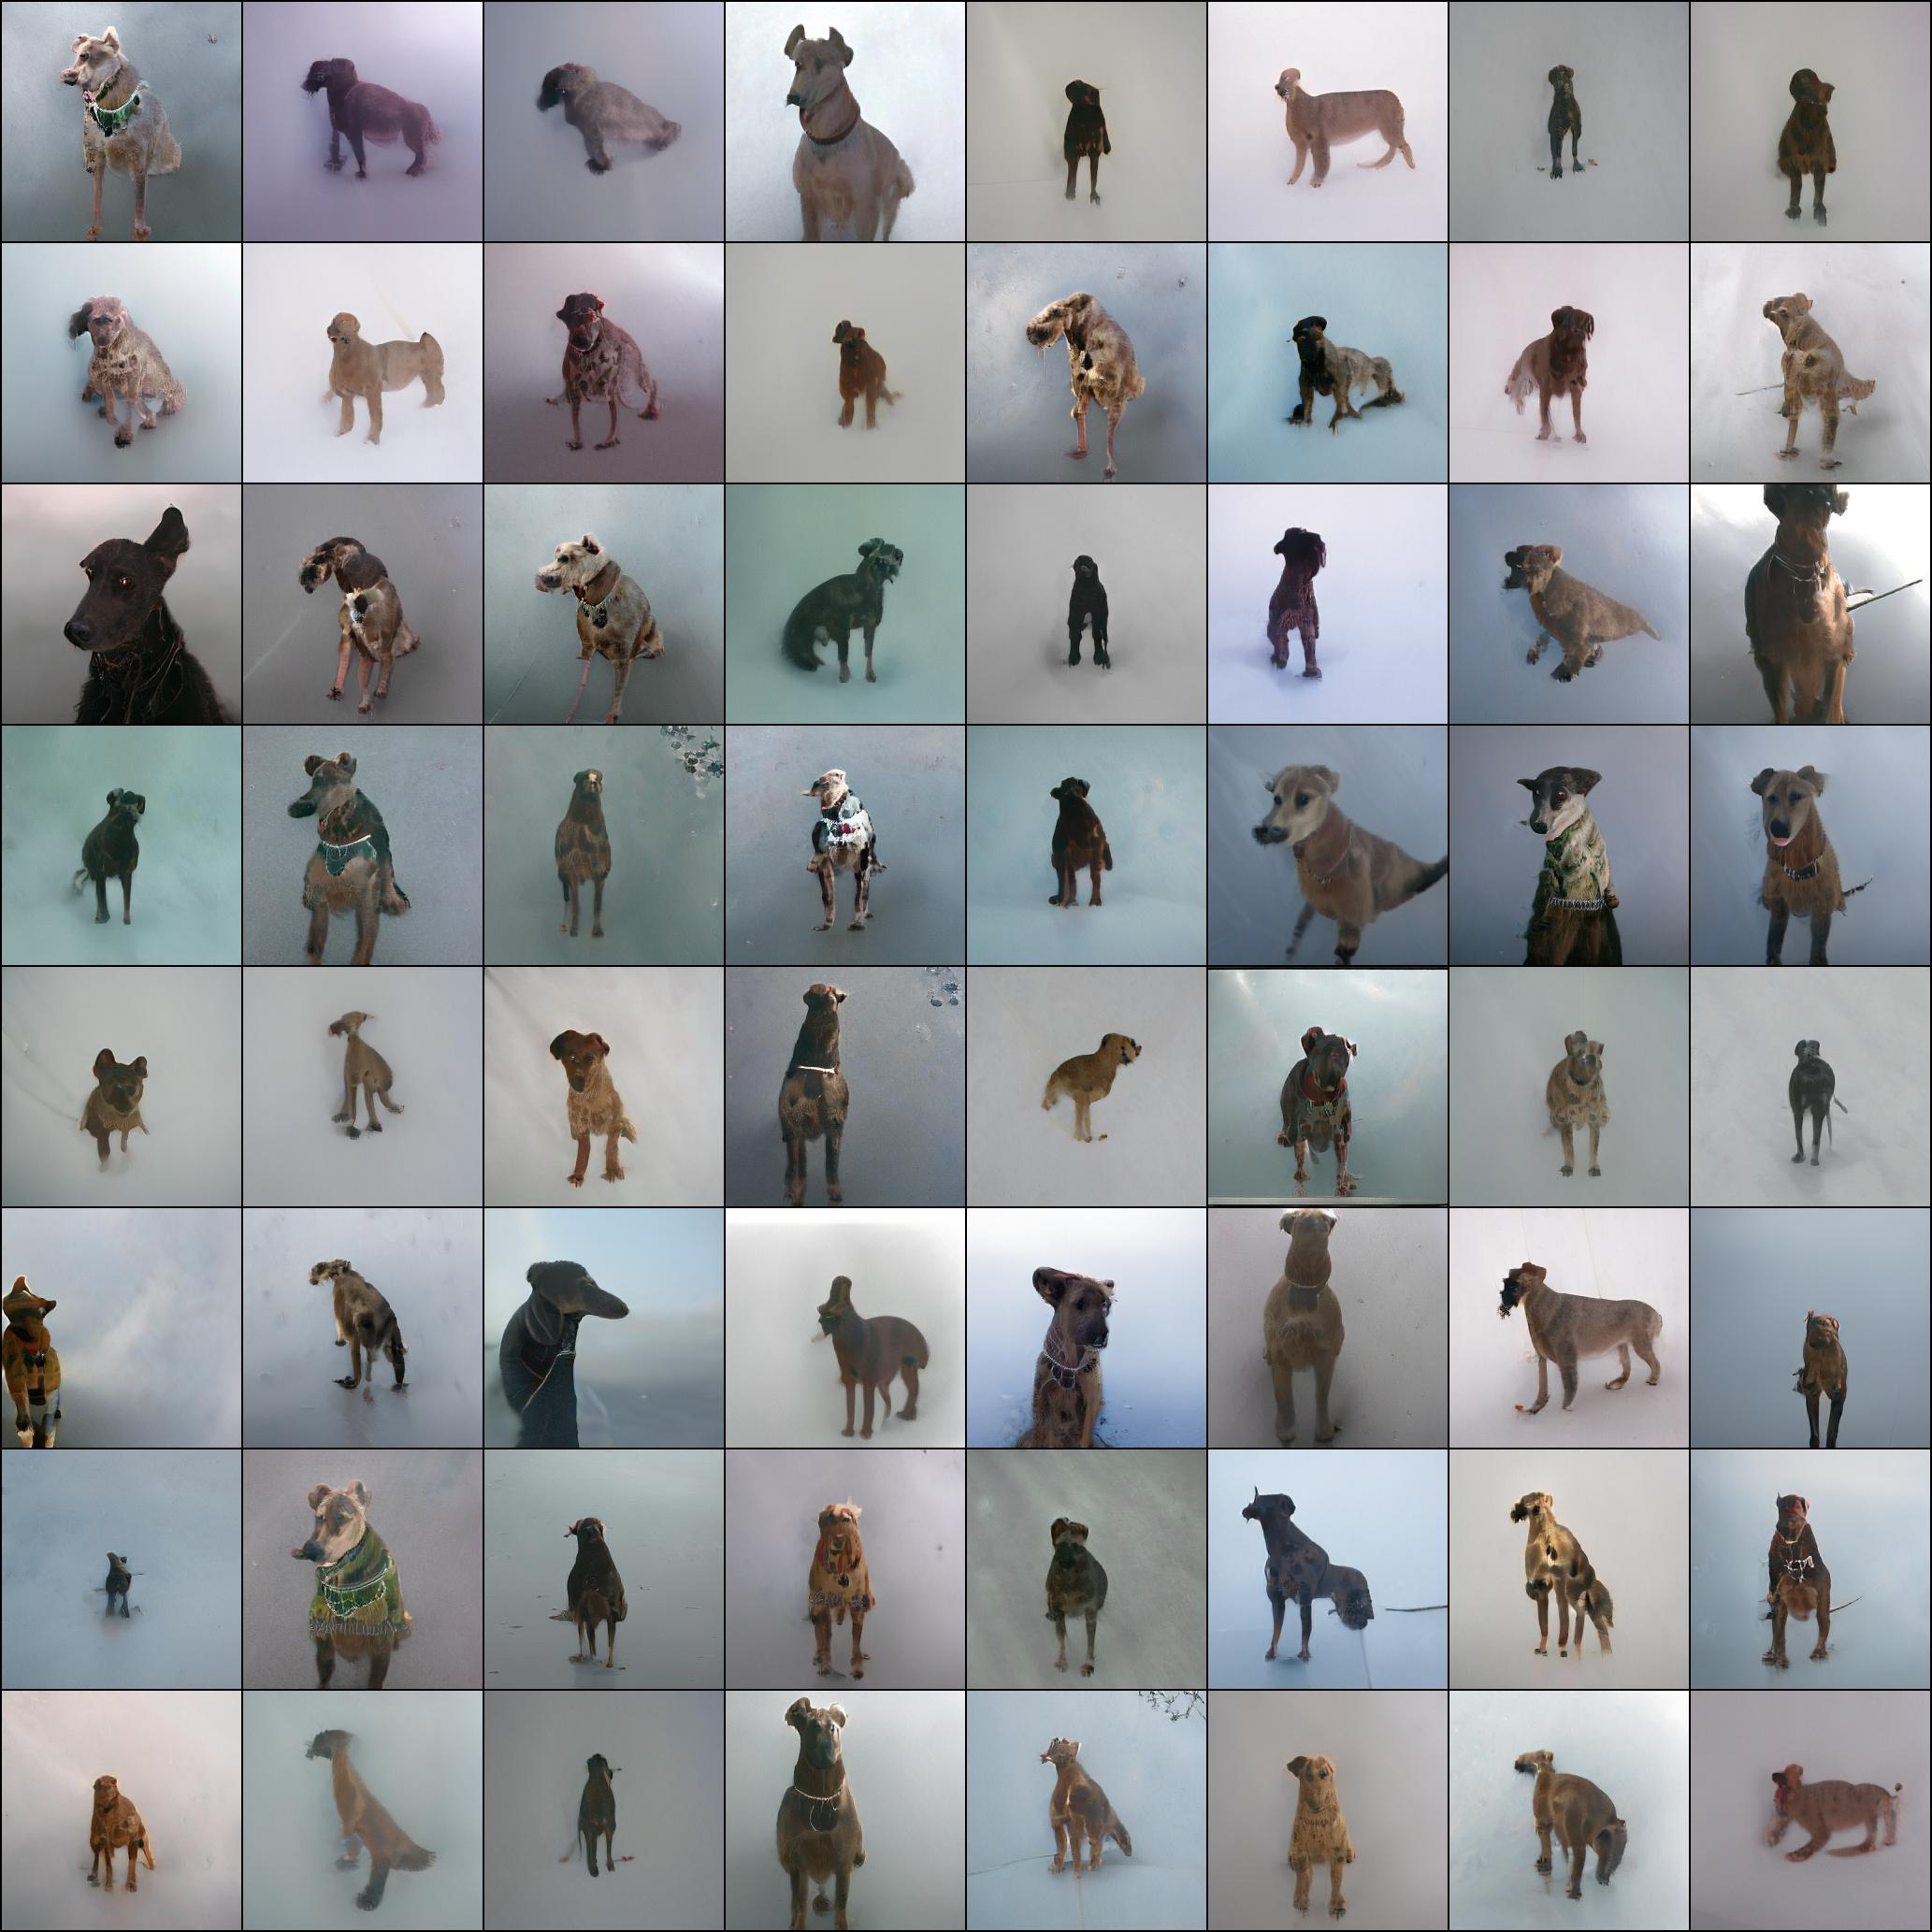

  101 |    6464 |  0.00000E+00 |  0.00000E+00 |       -0.396 |       -0.376
  102 |    6528 |  0.00000E+00 |  0.00000E+00 |       -0.396 |       -0.376
  103 |    6592 |  0.00000E+00 |  0.00000E+00 |       -0.396 |       -0.376
  104 |    6656 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3762
  105 |    6720 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3762
  106 |    6784 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3765
  107 |    6848 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3767
  108 |    6912 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3767
  109 |    6976 |  0.00000E+00 |  0.00000E+00 |       -0.396 |       -0.377
  110 |    7040 |  0.00000E+00 |  0.00000E+00 |       -0.396 |       -0.377
After 110 iterations...


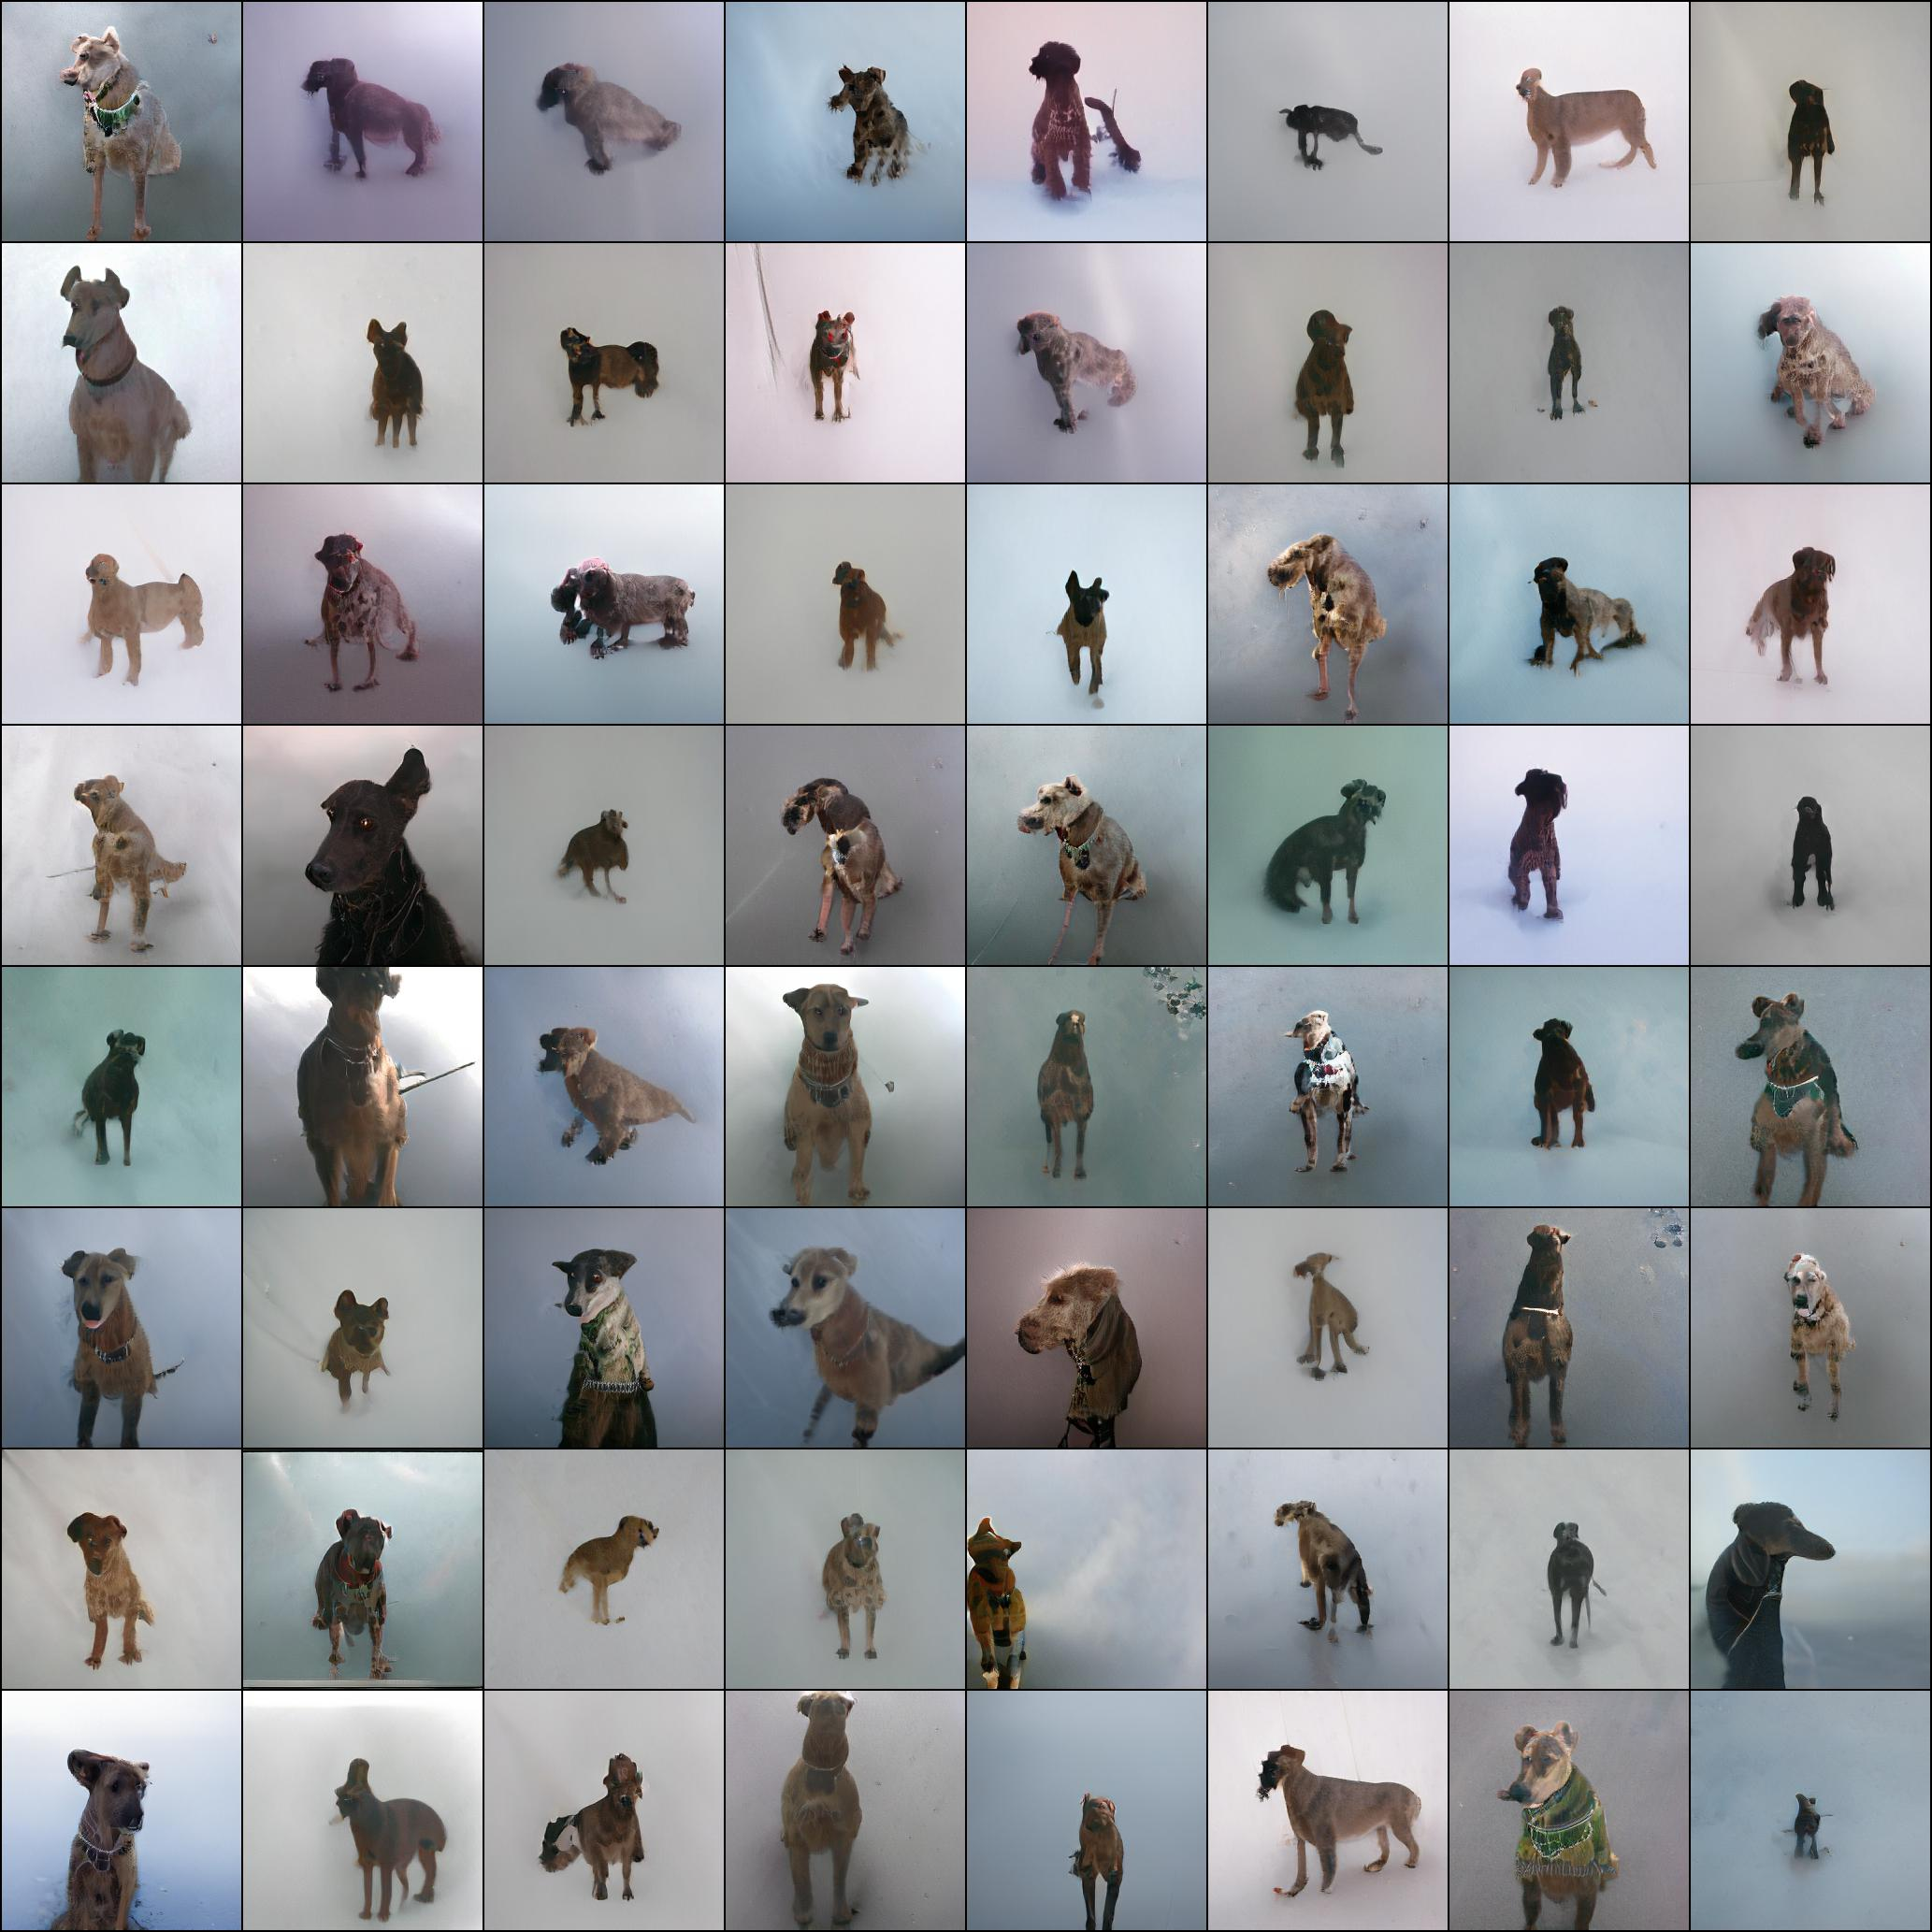

  111 |    7104 |  0.00000E+00 |  0.00000E+00 |       -0.396 |       -0.377
  112 |    7168 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3772
  113 |    7232 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3772
  114 |    7296 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3774
  115 |    7360 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3774
  116 |    7424 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3774
  117 |    7488 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3777
  118 |    7552 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3777
  119 |    7616 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3777
  120 |    7680 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3777
After 120 iterations...


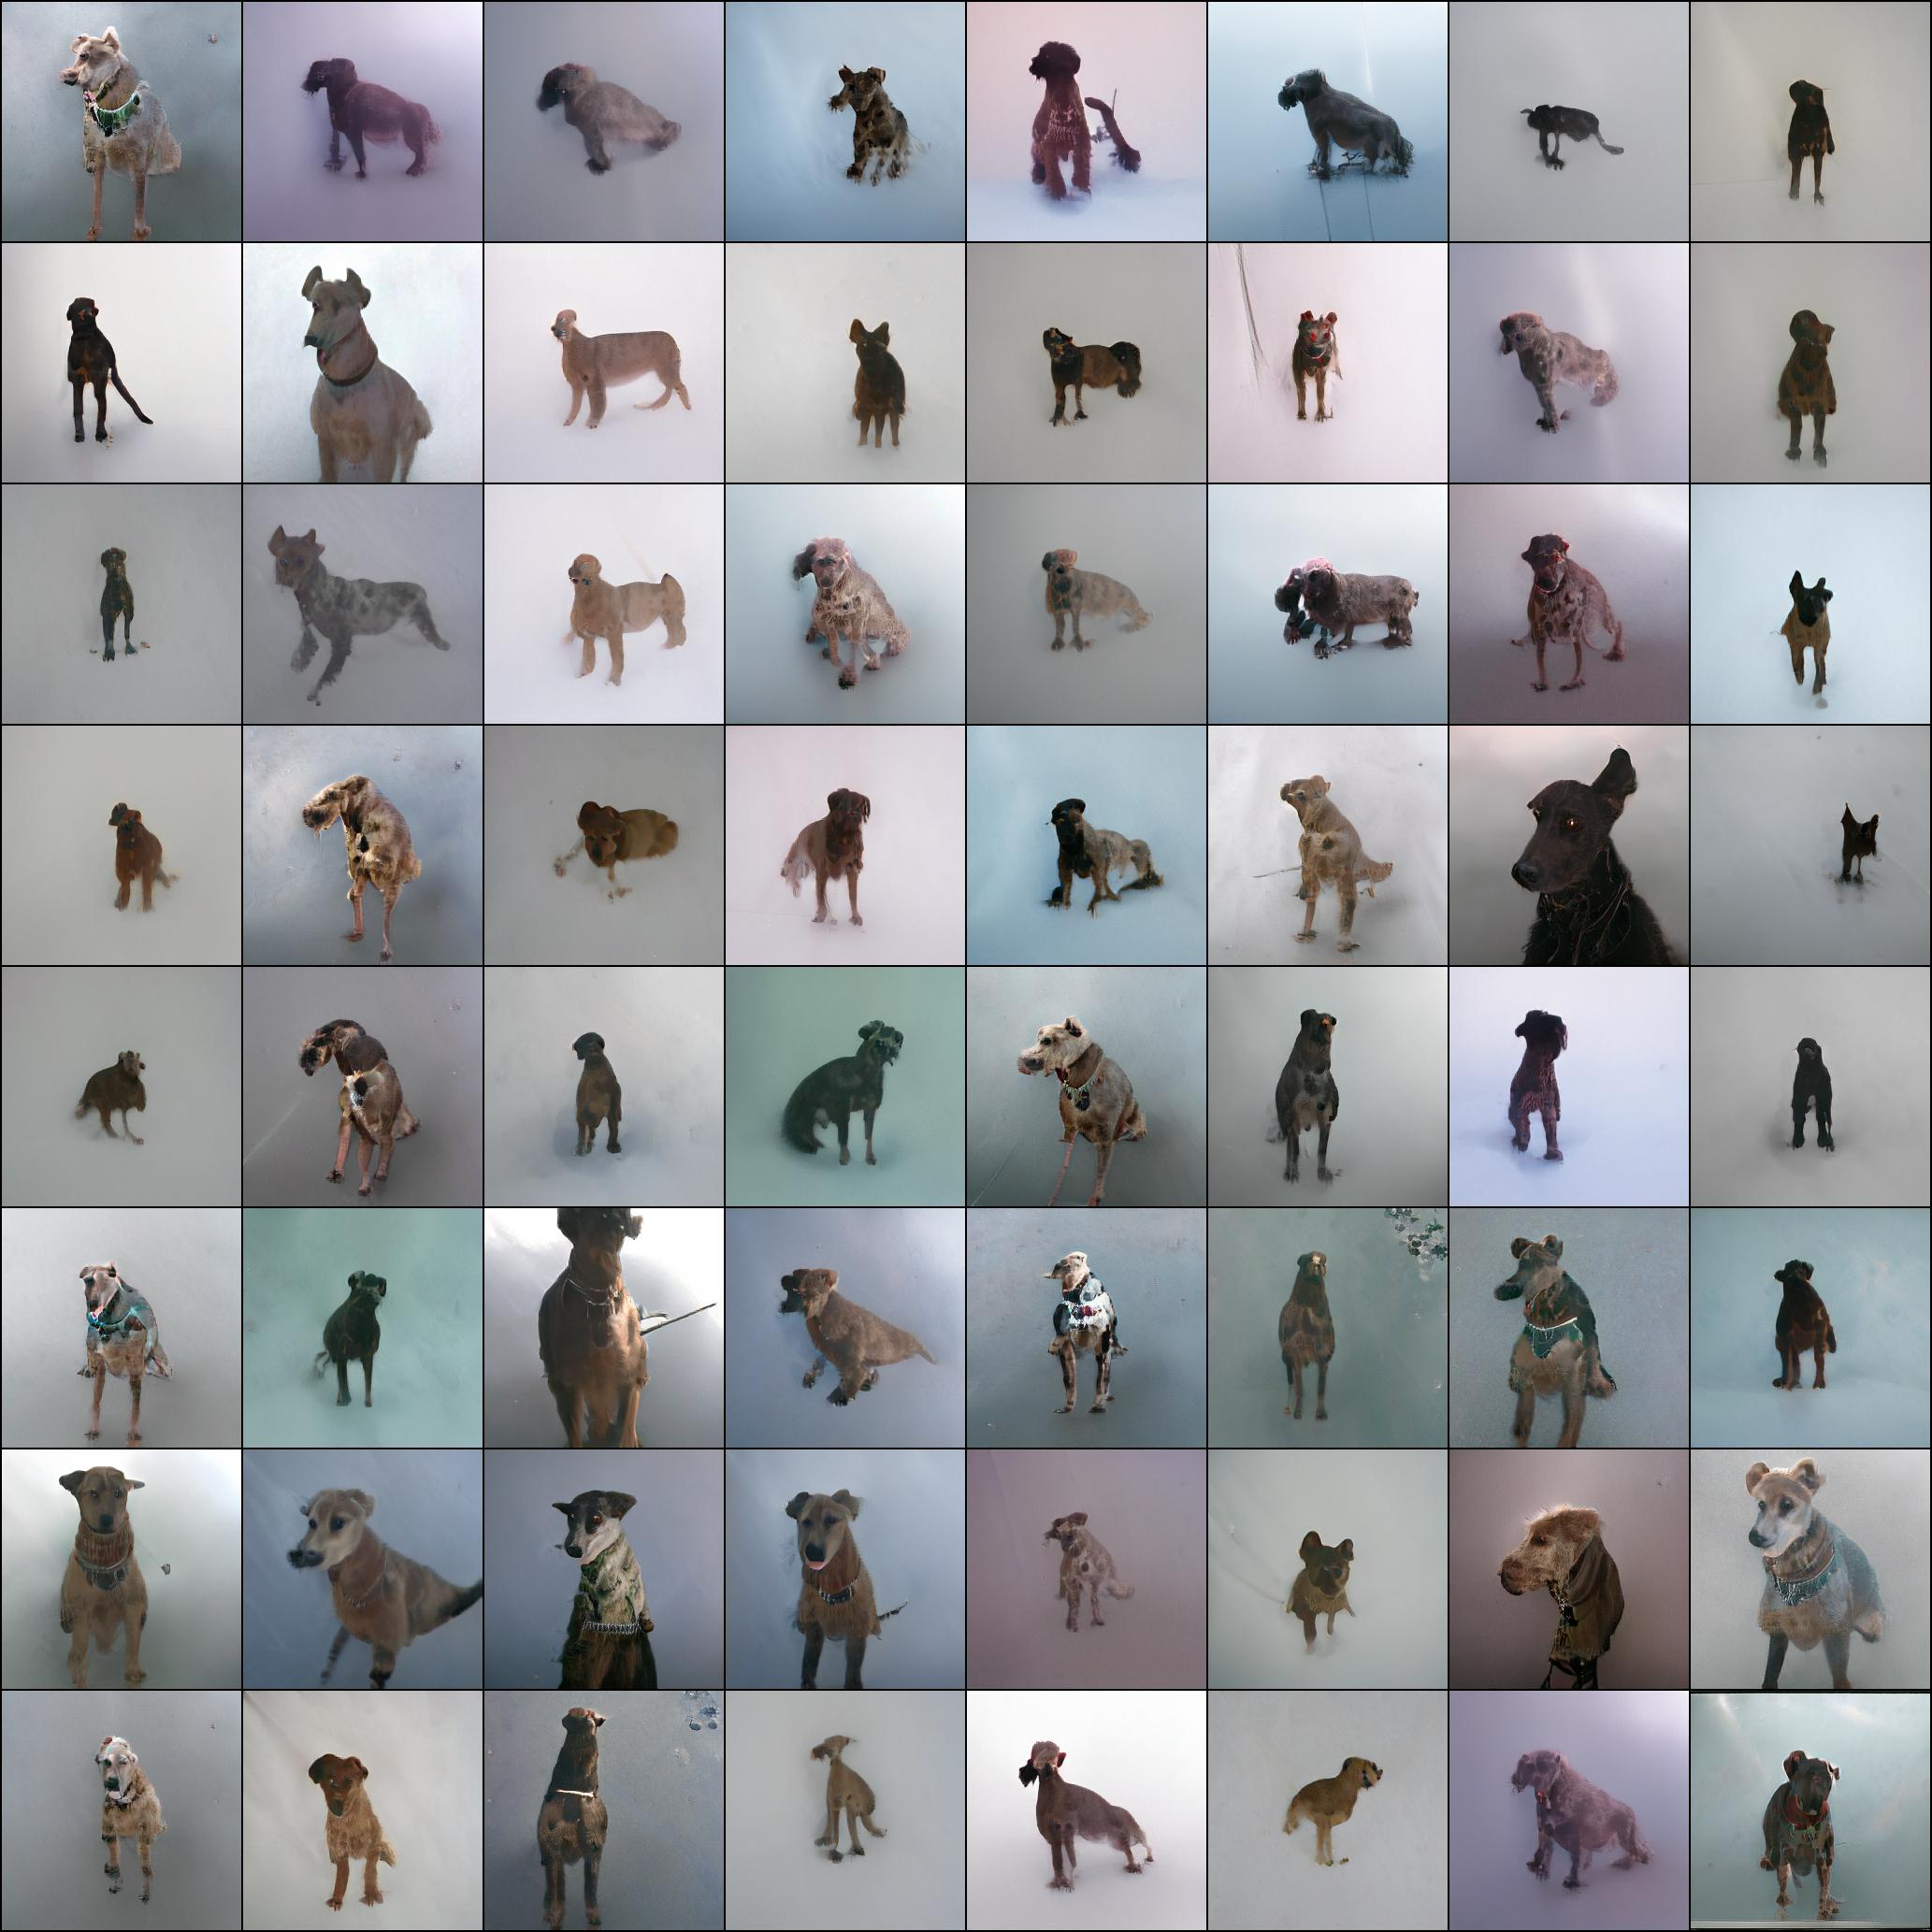

  121 |    7744 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3777
  122 |    7808 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3777
  123 |    7872 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3777
  124 |    7936 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3777
  125 |    8000 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3782
  126 |    8064 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3782
  127 |    8128 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3782
  128 |    8192 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3782
  129 |    8256 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3784
  130 |    8320 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3784
After 130 iterations...


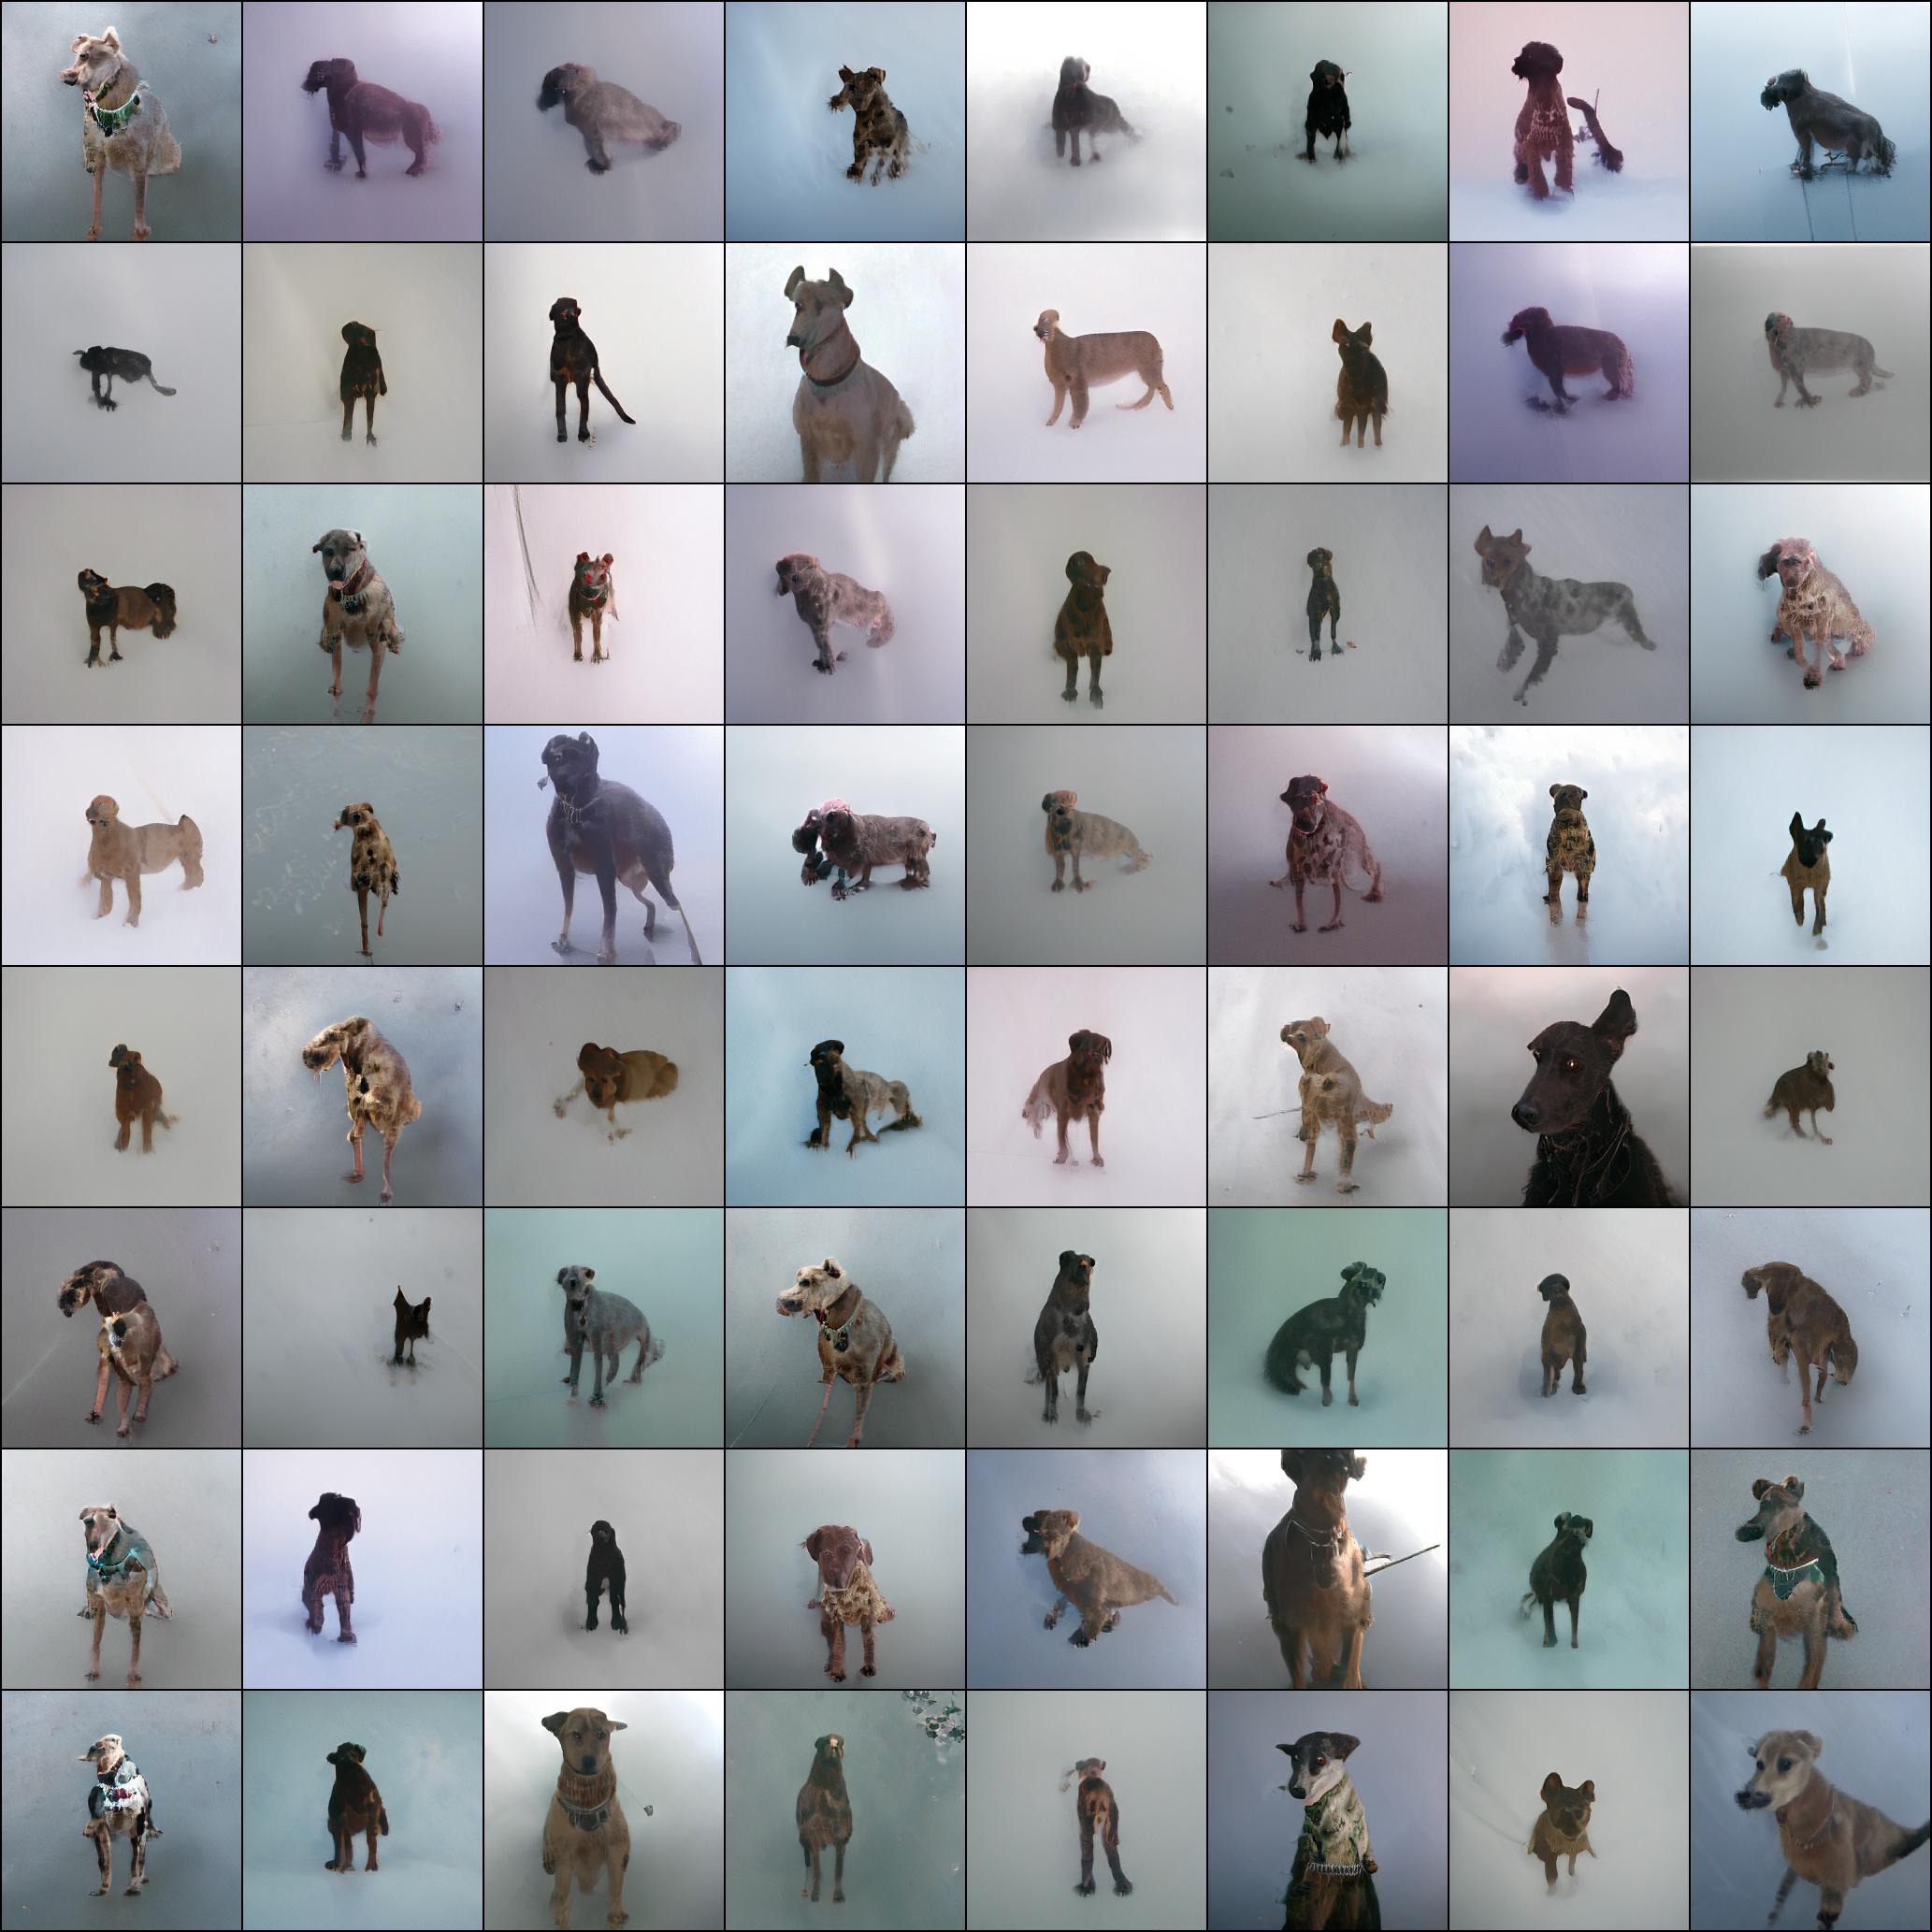

  131 |    8384 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3784
  132 |    8448 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3787
  133 |    8512 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3787
  134 |    8576 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3787
  135 |    8640 |  0.00000E+00 |  0.00000E+00 |       -0.396 |       -0.379
  136 |    8704 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3792
  137 |    8768 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3792
  138 |    8832 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3794
  139 |    8896 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3794
  140 |    8960 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3794
After 140 iterations...


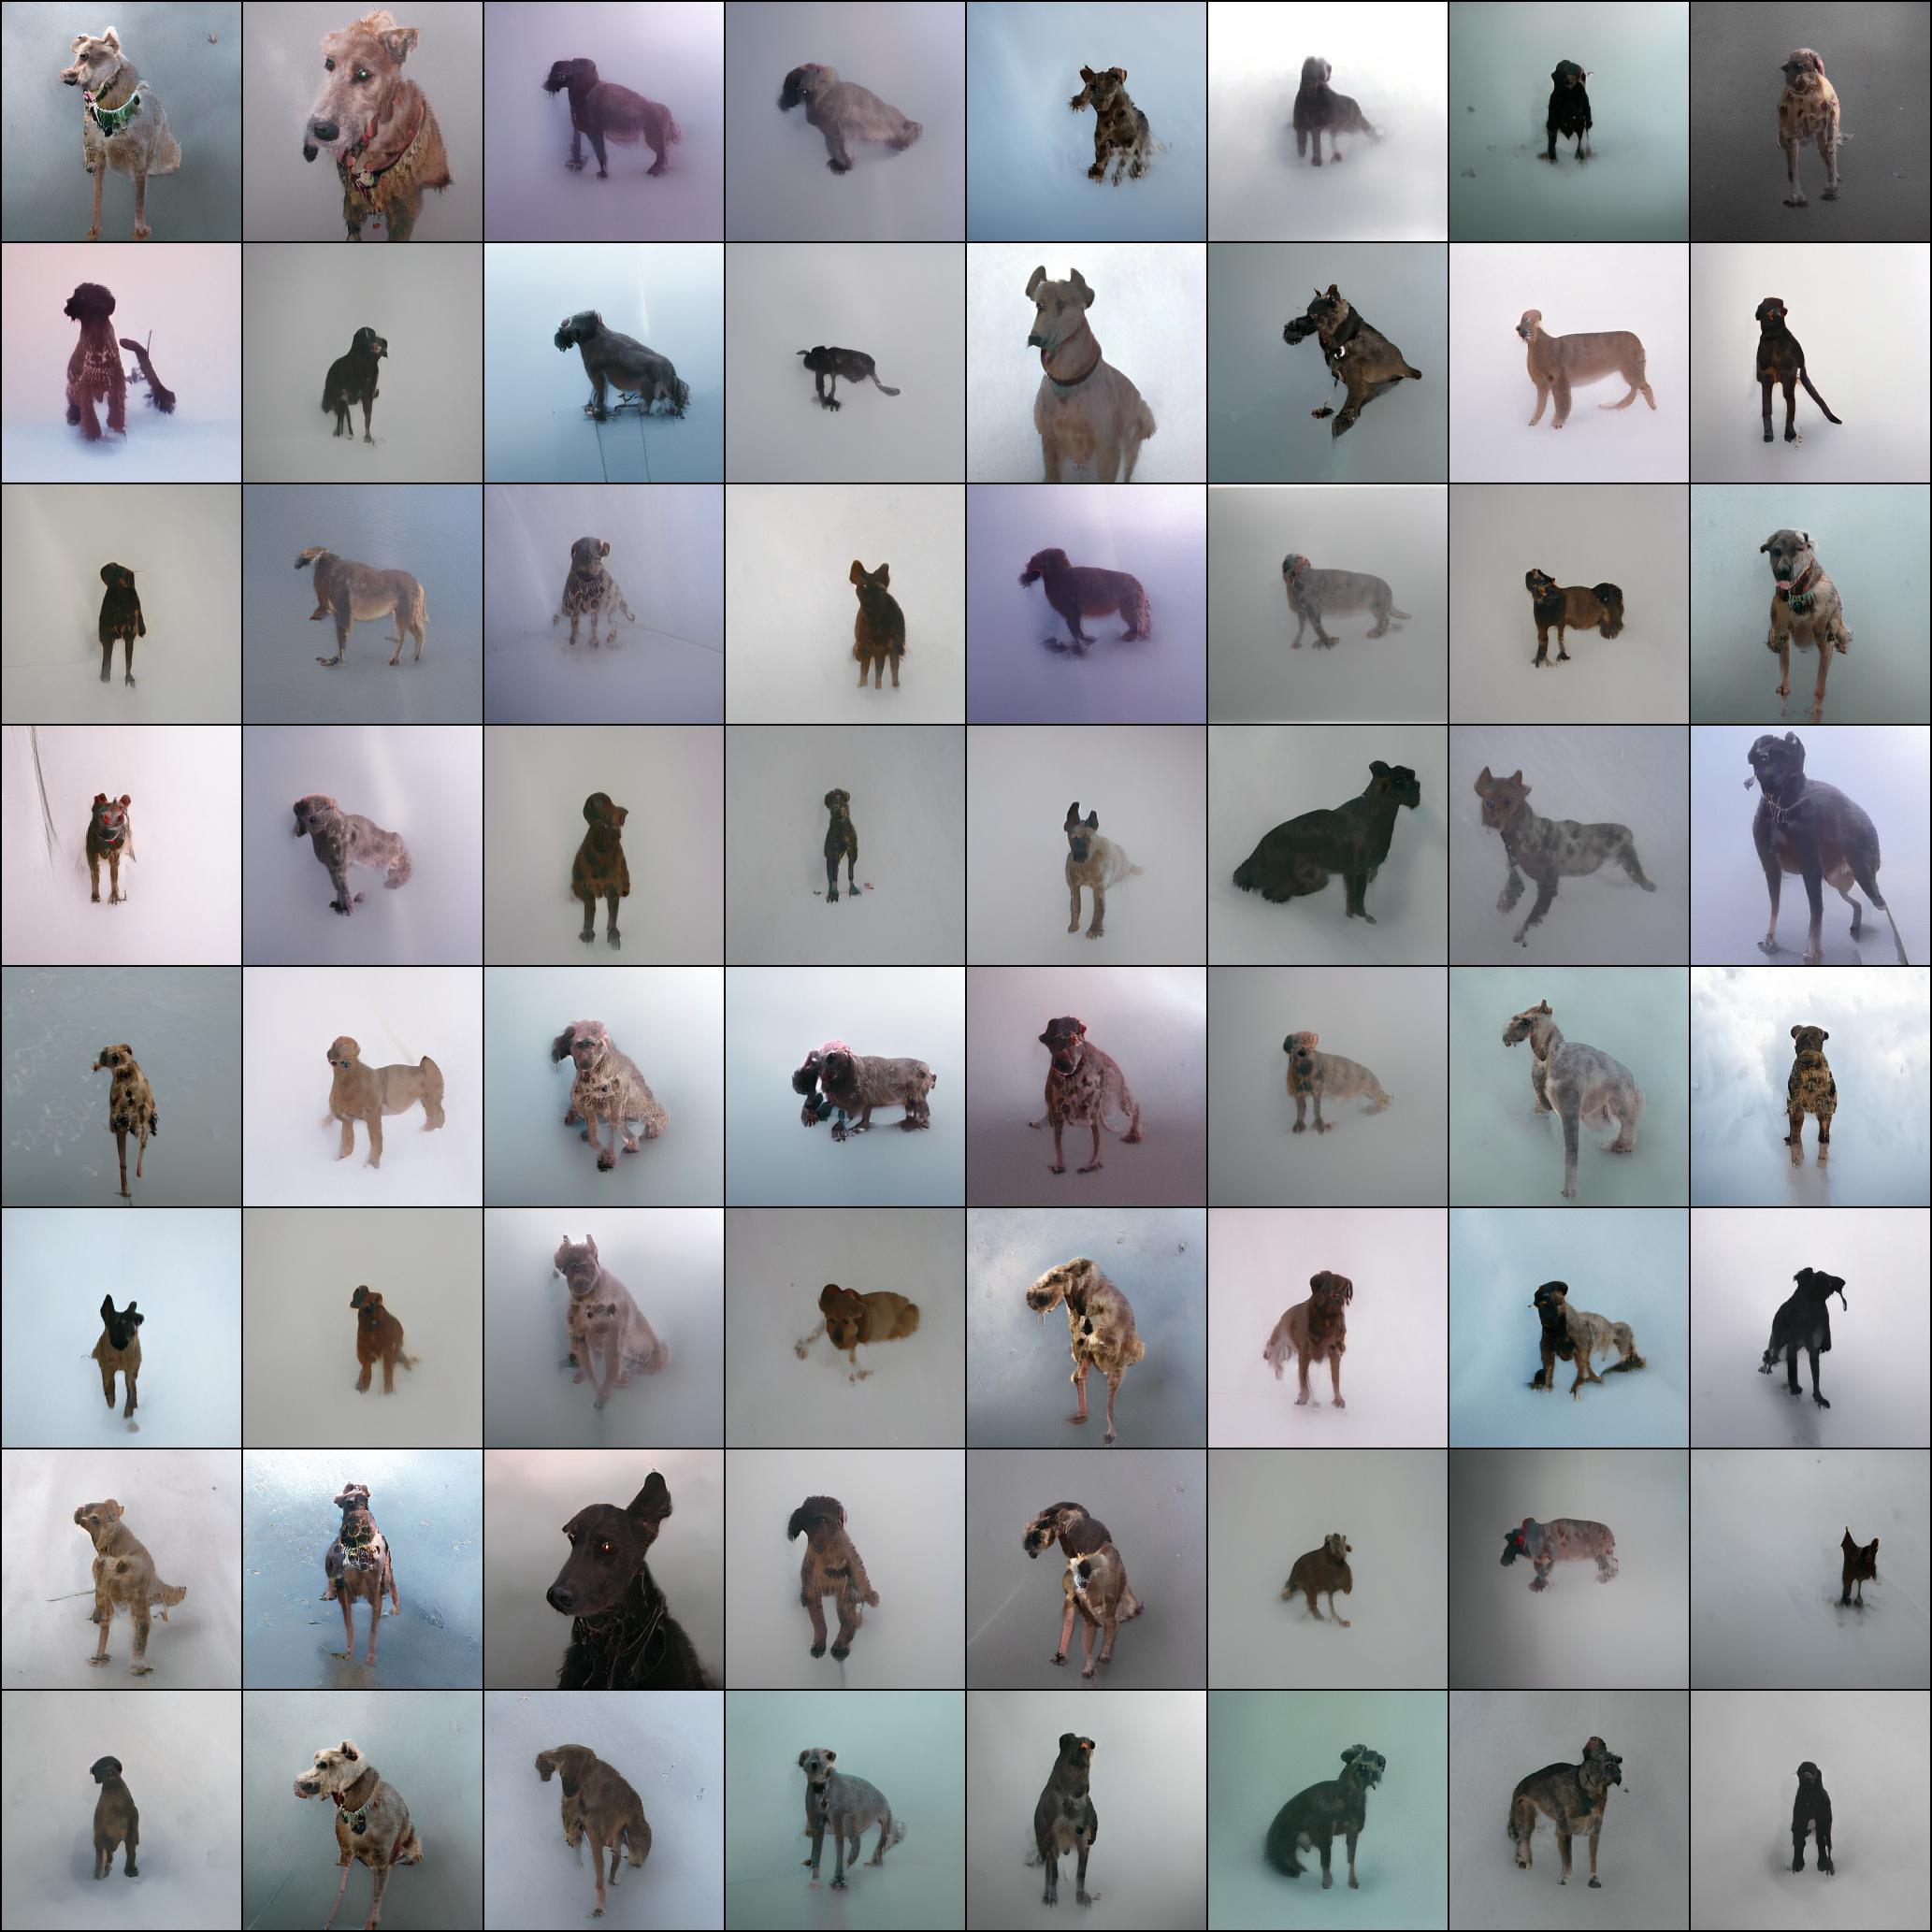

  141 |    9024 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3794
  142 |    9088 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3796
  143 |    9152 |  0.00000E+00 |  0.00000E+00 |       -0.396 |        -0.38
  144 |    9216 |  0.00000E+00 |  0.00000E+00 |       -0.396 |        -0.38
  145 |    9280 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3801
  146 |    9344 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3801
  147 |    9408 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3801
  148 |    9472 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3801
  149 |    9536 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3801
  150 |    9600 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3801
After 150 iterations...


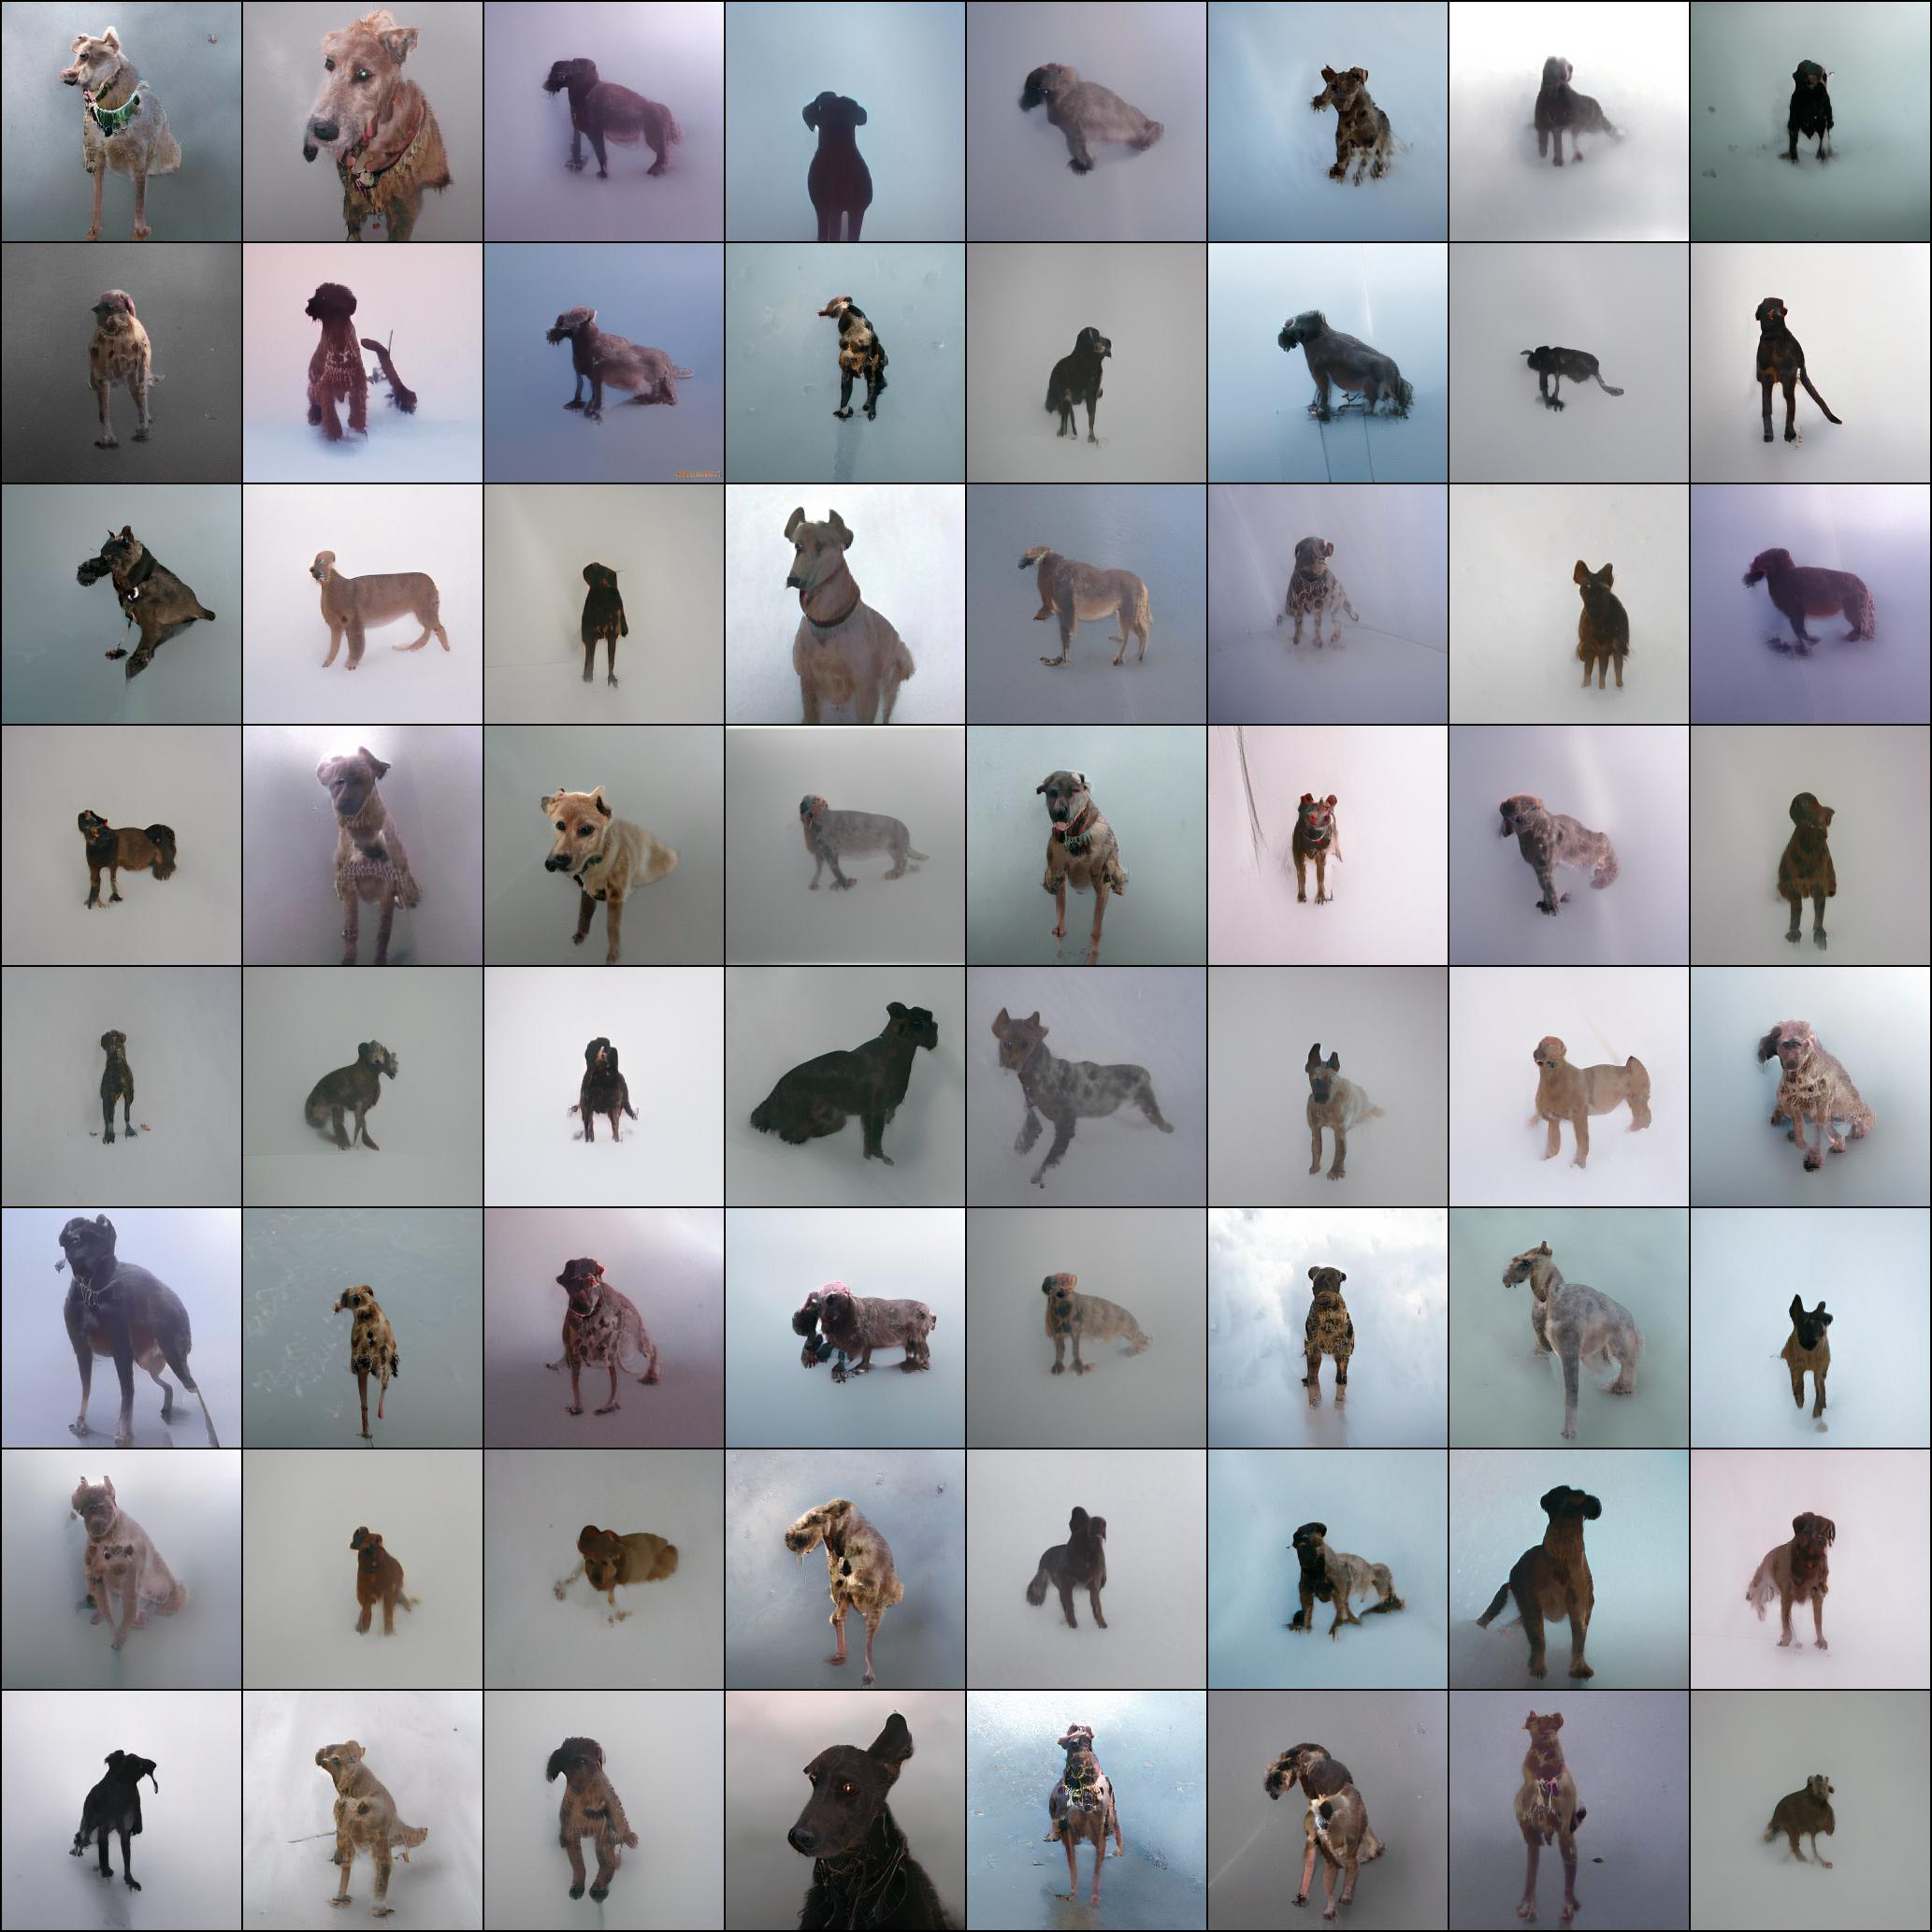

  151 |    9664 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3801
  152 |    9728 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3804
  153 |    9792 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3804
  154 |    9856 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3804
  155 |    9920 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3806
  156 |    9984 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3806
  157 |   10048 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3809
  158 |   10112 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3809
  159 |   10176 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3809
  160 |   10240 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3809
After 160 iterations...


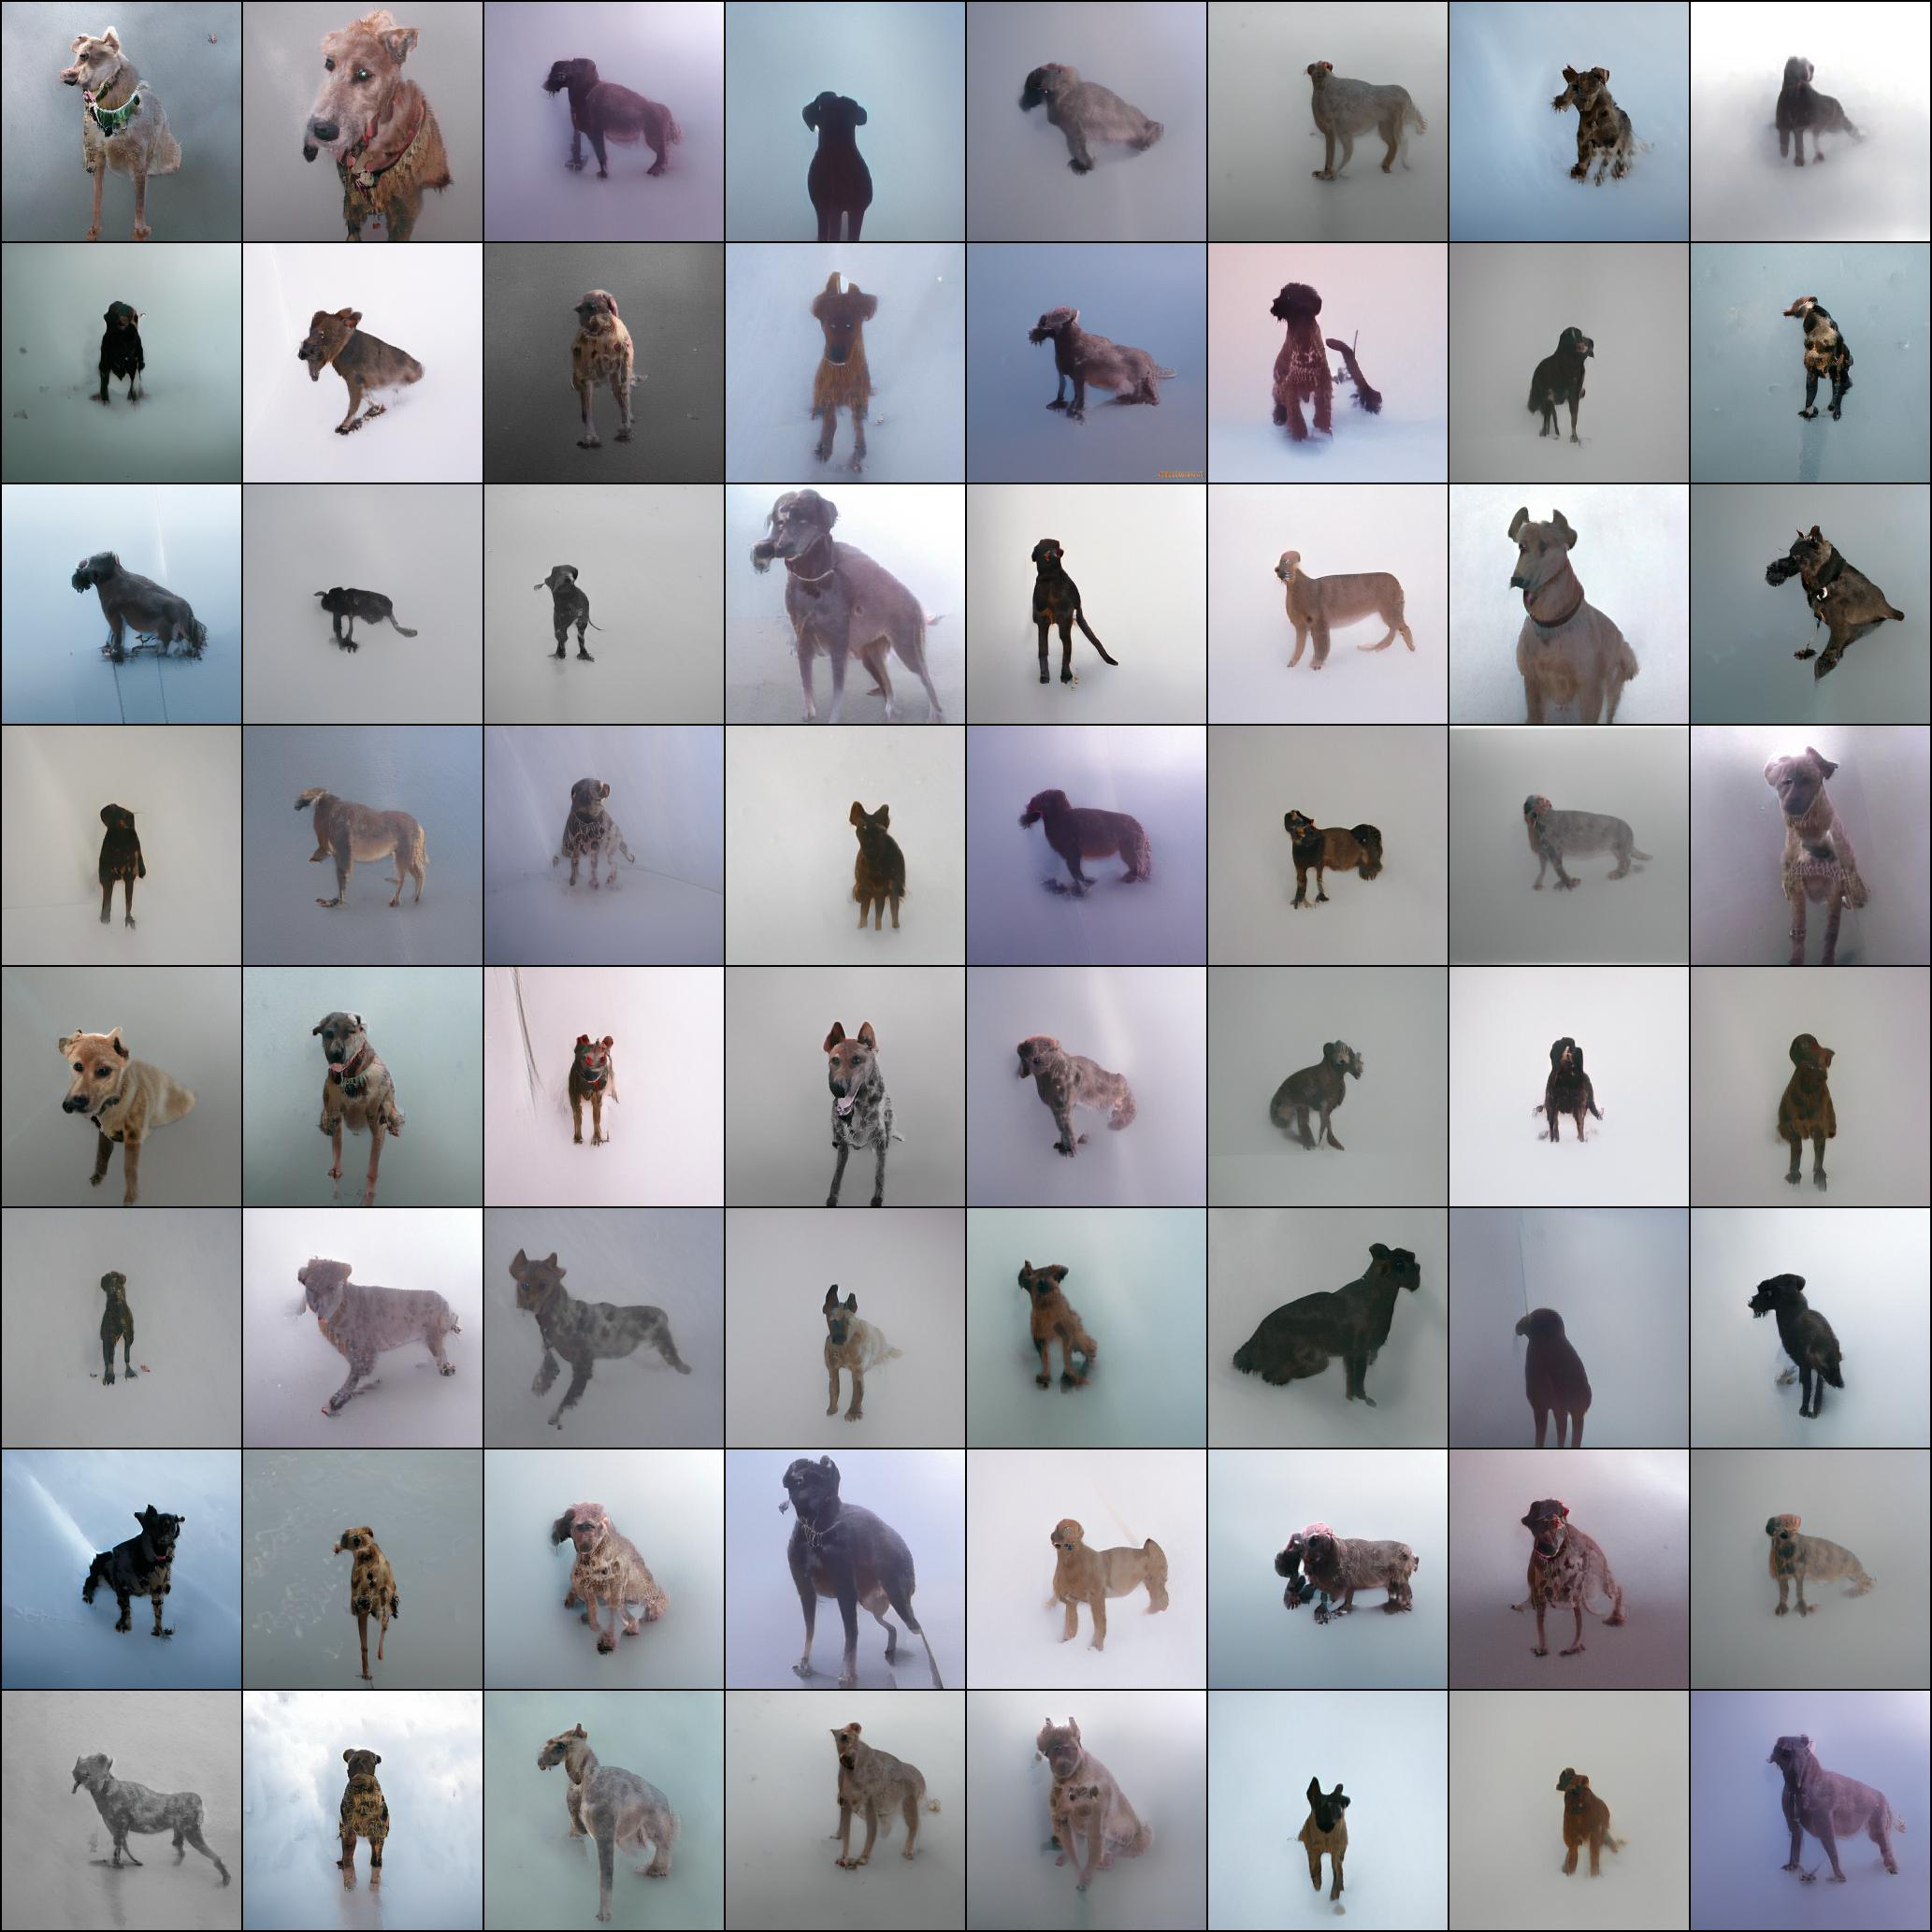

  161 |   10304 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3809
  162 |   10368 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3809
  163 |   10432 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3809
  164 |   10496 |  0.00000E+00 |  0.00000E+00 |       -0.396 |       -0.381
  165 |   10560 |  0.00000E+00 |  0.00000E+00 |       -0.396 |       -0.381
  166 |   10624 |  0.00000E+00 |  0.00000E+00 |       -0.396 |       -0.381
  167 |   10688 |  0.00000E+00 |  0.00000E+00 |       -0.396 |       -0.381
  168 |   10752 |  0.00000E+00 |  0.00000E+00 |       -0.396 |       -0.381
  169 |   10816 |  0.00000E+00 |  0.00000E+00 |       -0.396 |       -0.381
  170 |   10880 |  0.00000E+00 |  0.00000E+00 |       -0.396 |       -0.381
After 170 iterations...


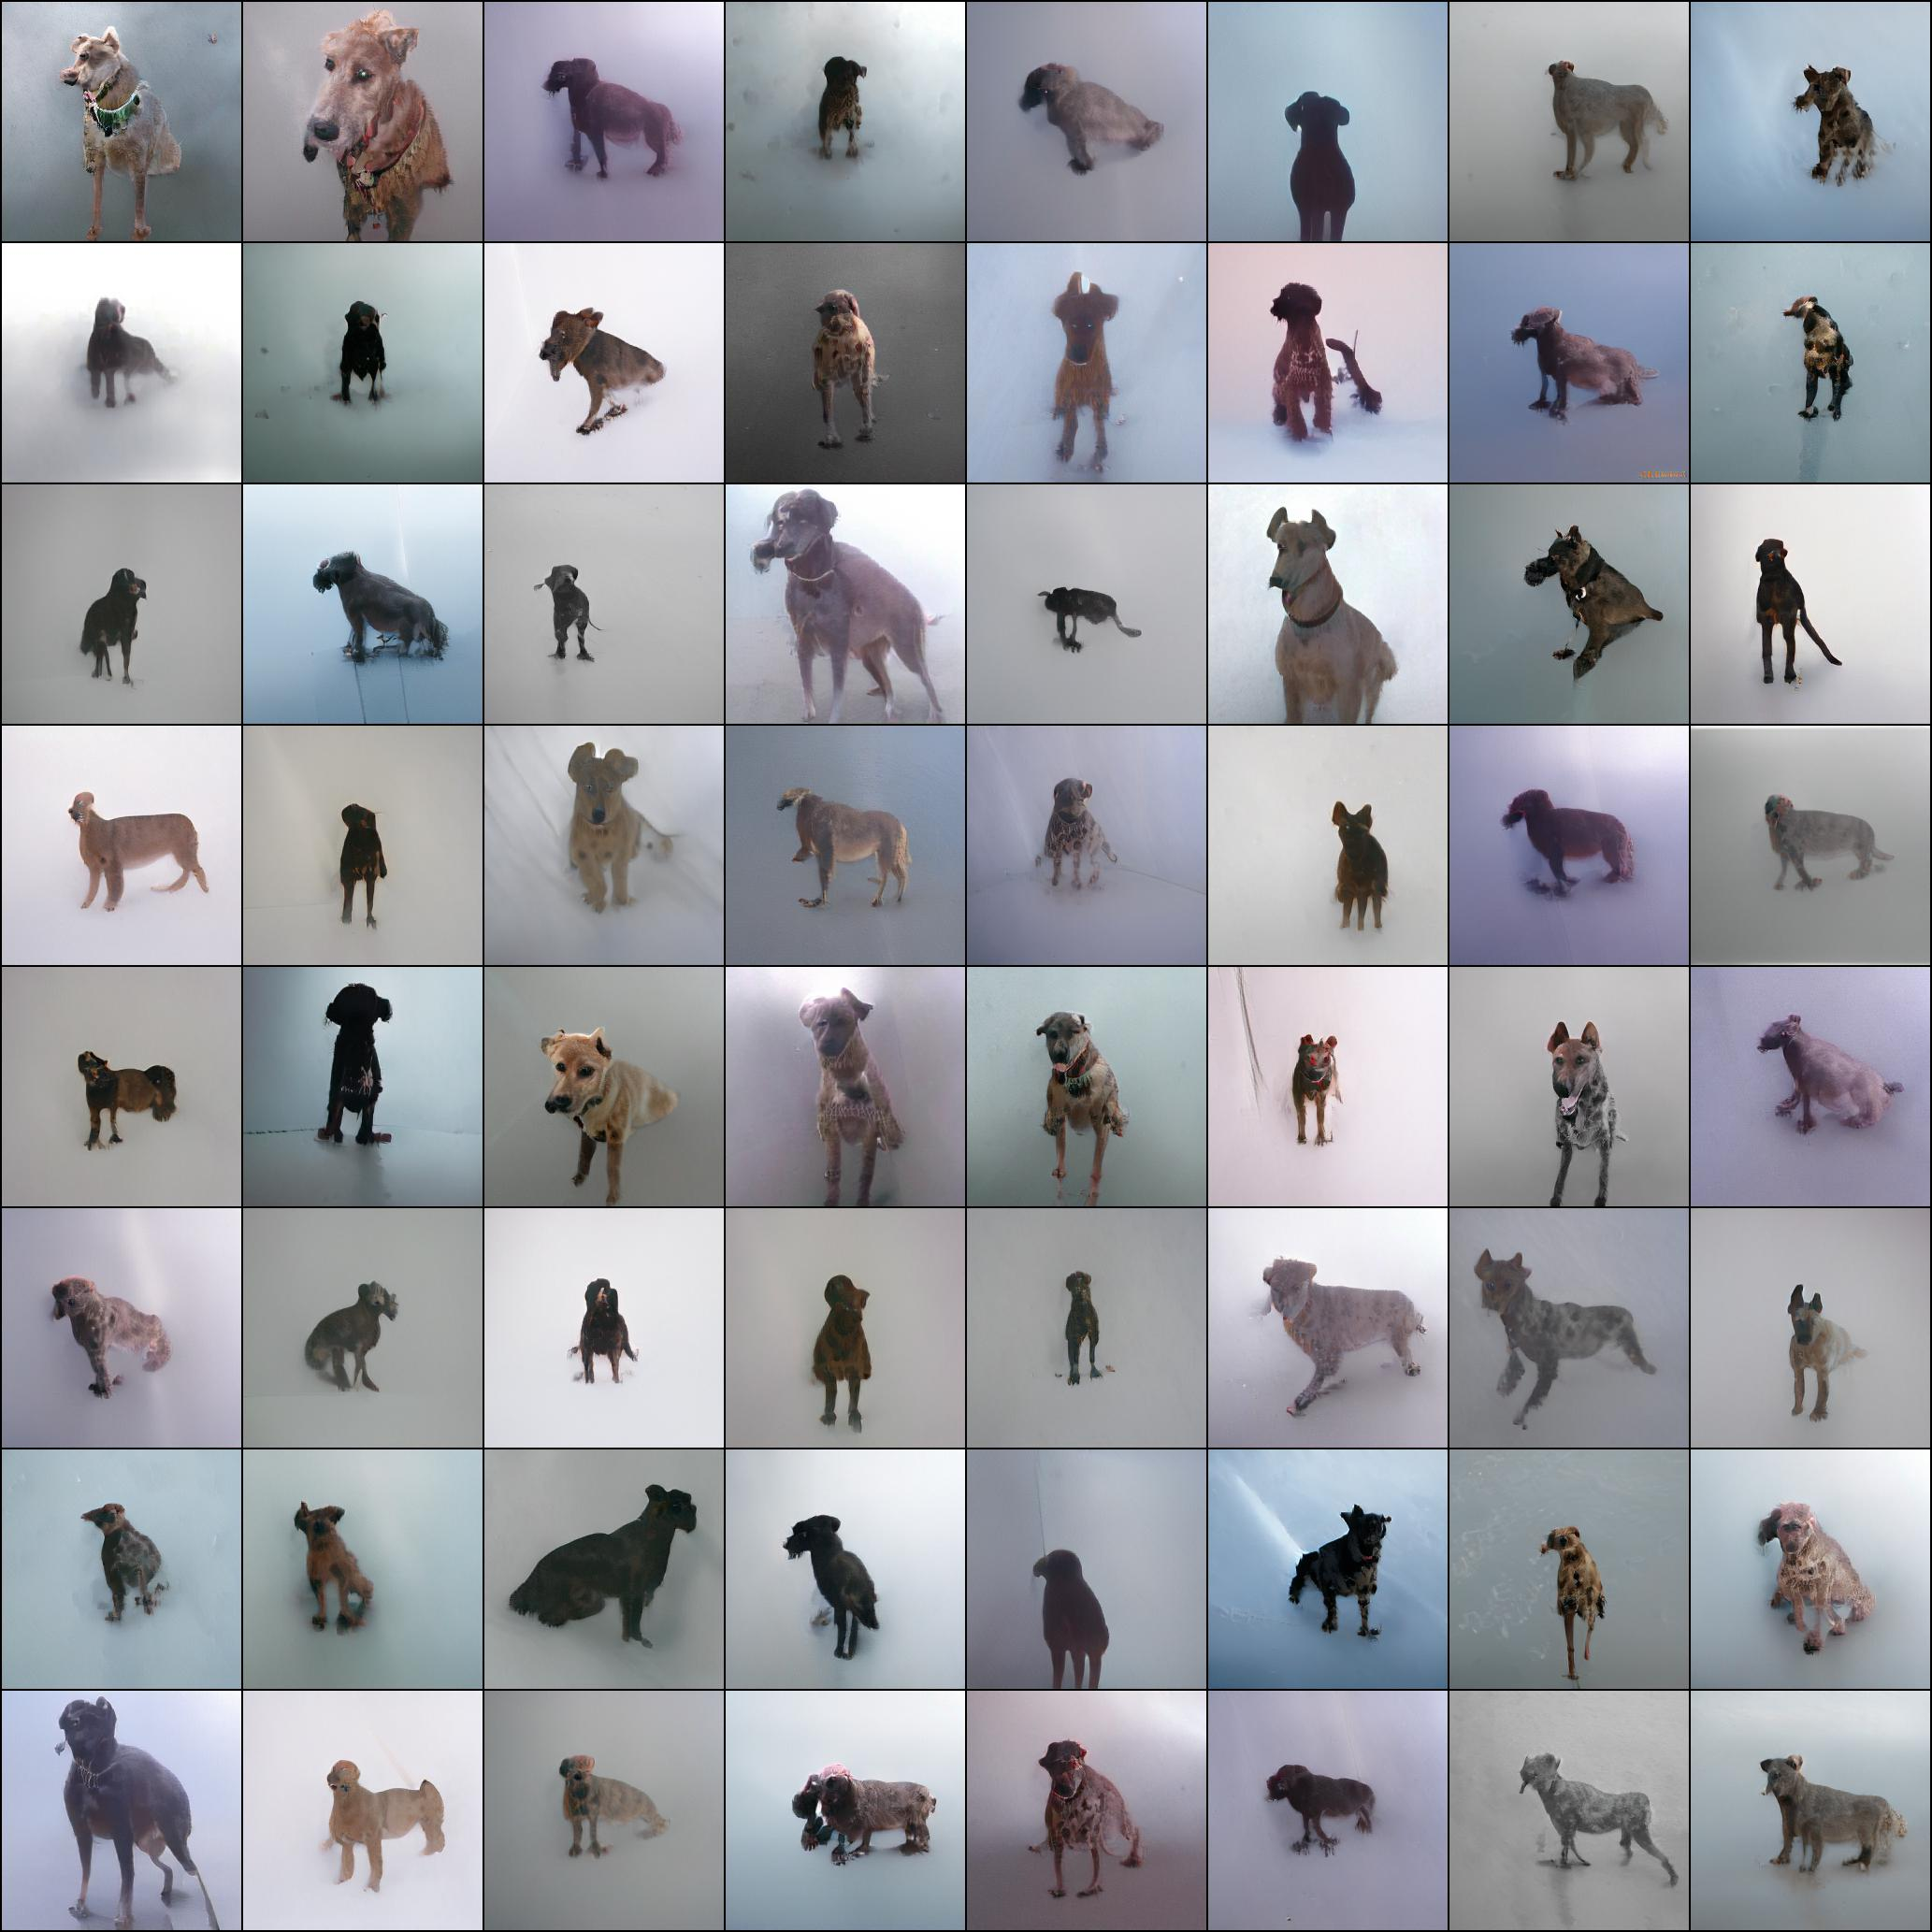

  171 |   10944 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3813
  172 |   11008 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3816
  173 |   11072 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3816
  174 |   11136 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3816
  175 |   11200 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3816
  176 |   11264 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3816
  177 |   11328 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3818
  178 |   11392 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3818
  179 |   11456 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3818
  180 |   11520 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3818
After 180 iterations...


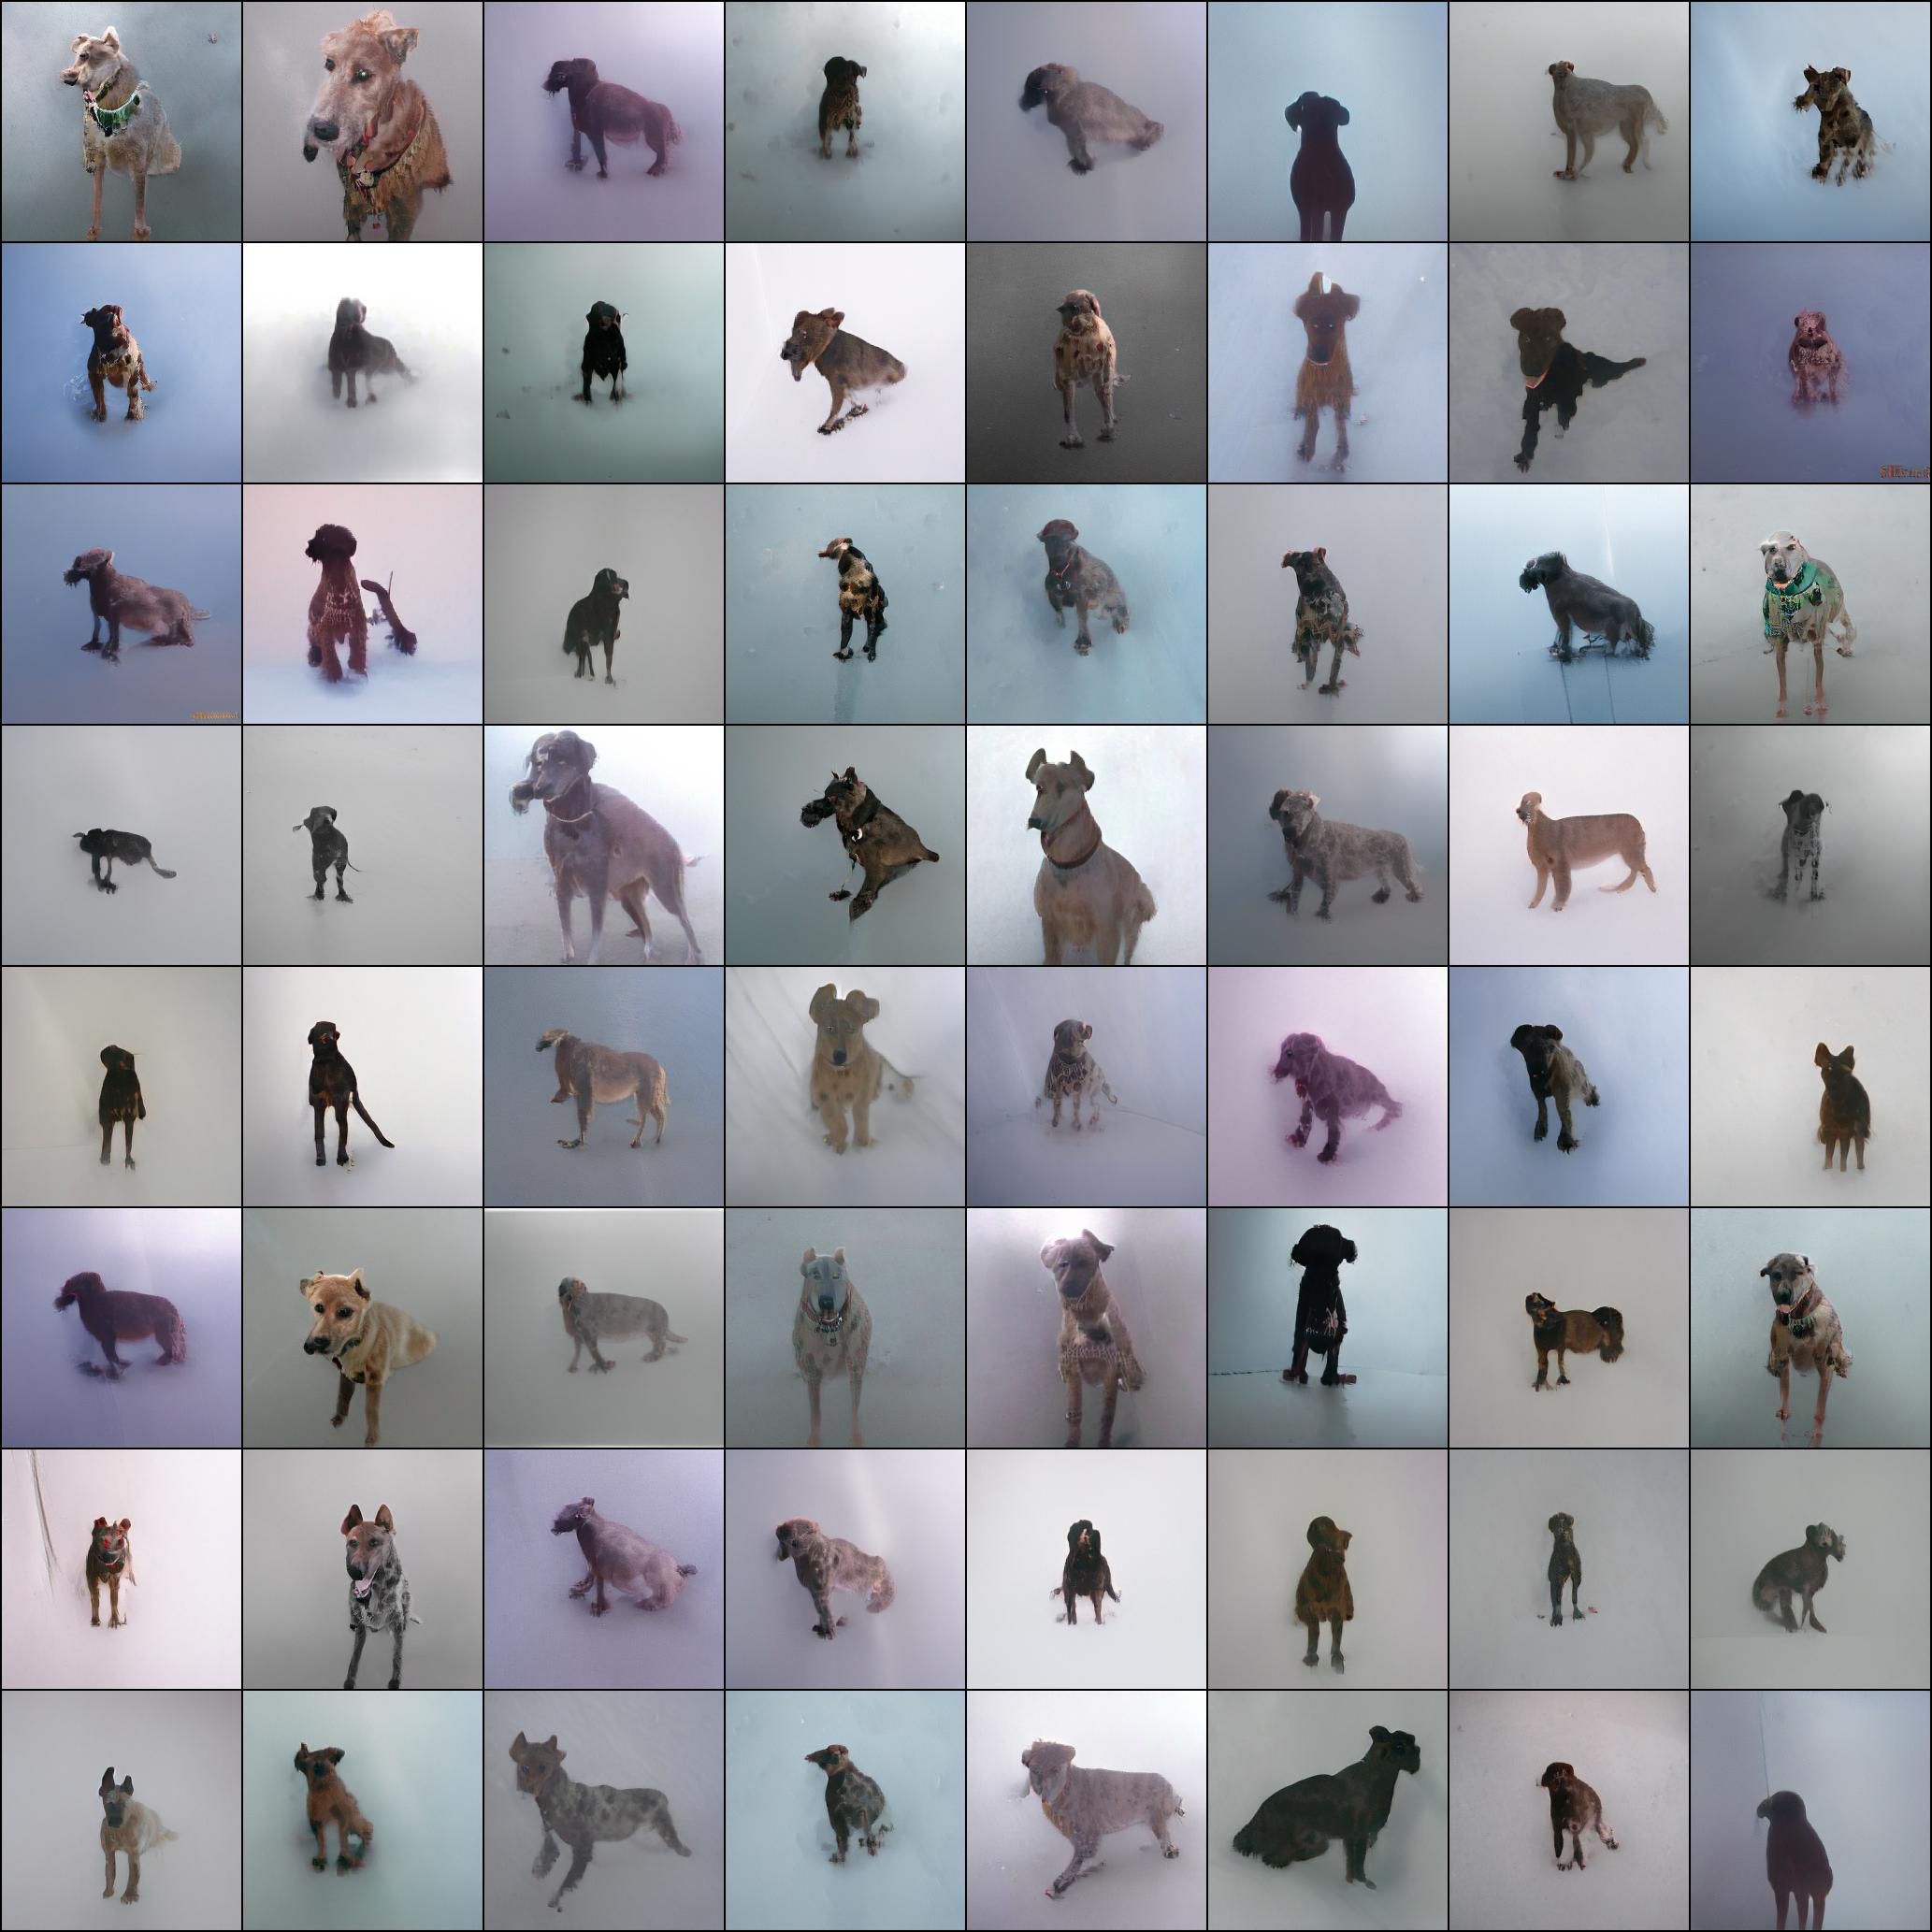

  181 |   11584 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3818
  182 |   11648 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3818
  183 |   11712 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3818
  184 |   11776 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3818
  185 |   11840 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3818
  186 |   11904 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3818
  187 |   11968 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3818
  188 |   12032 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3818
  189 |   12096 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3818
  190 |   12160 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3818
After 190 iterations...


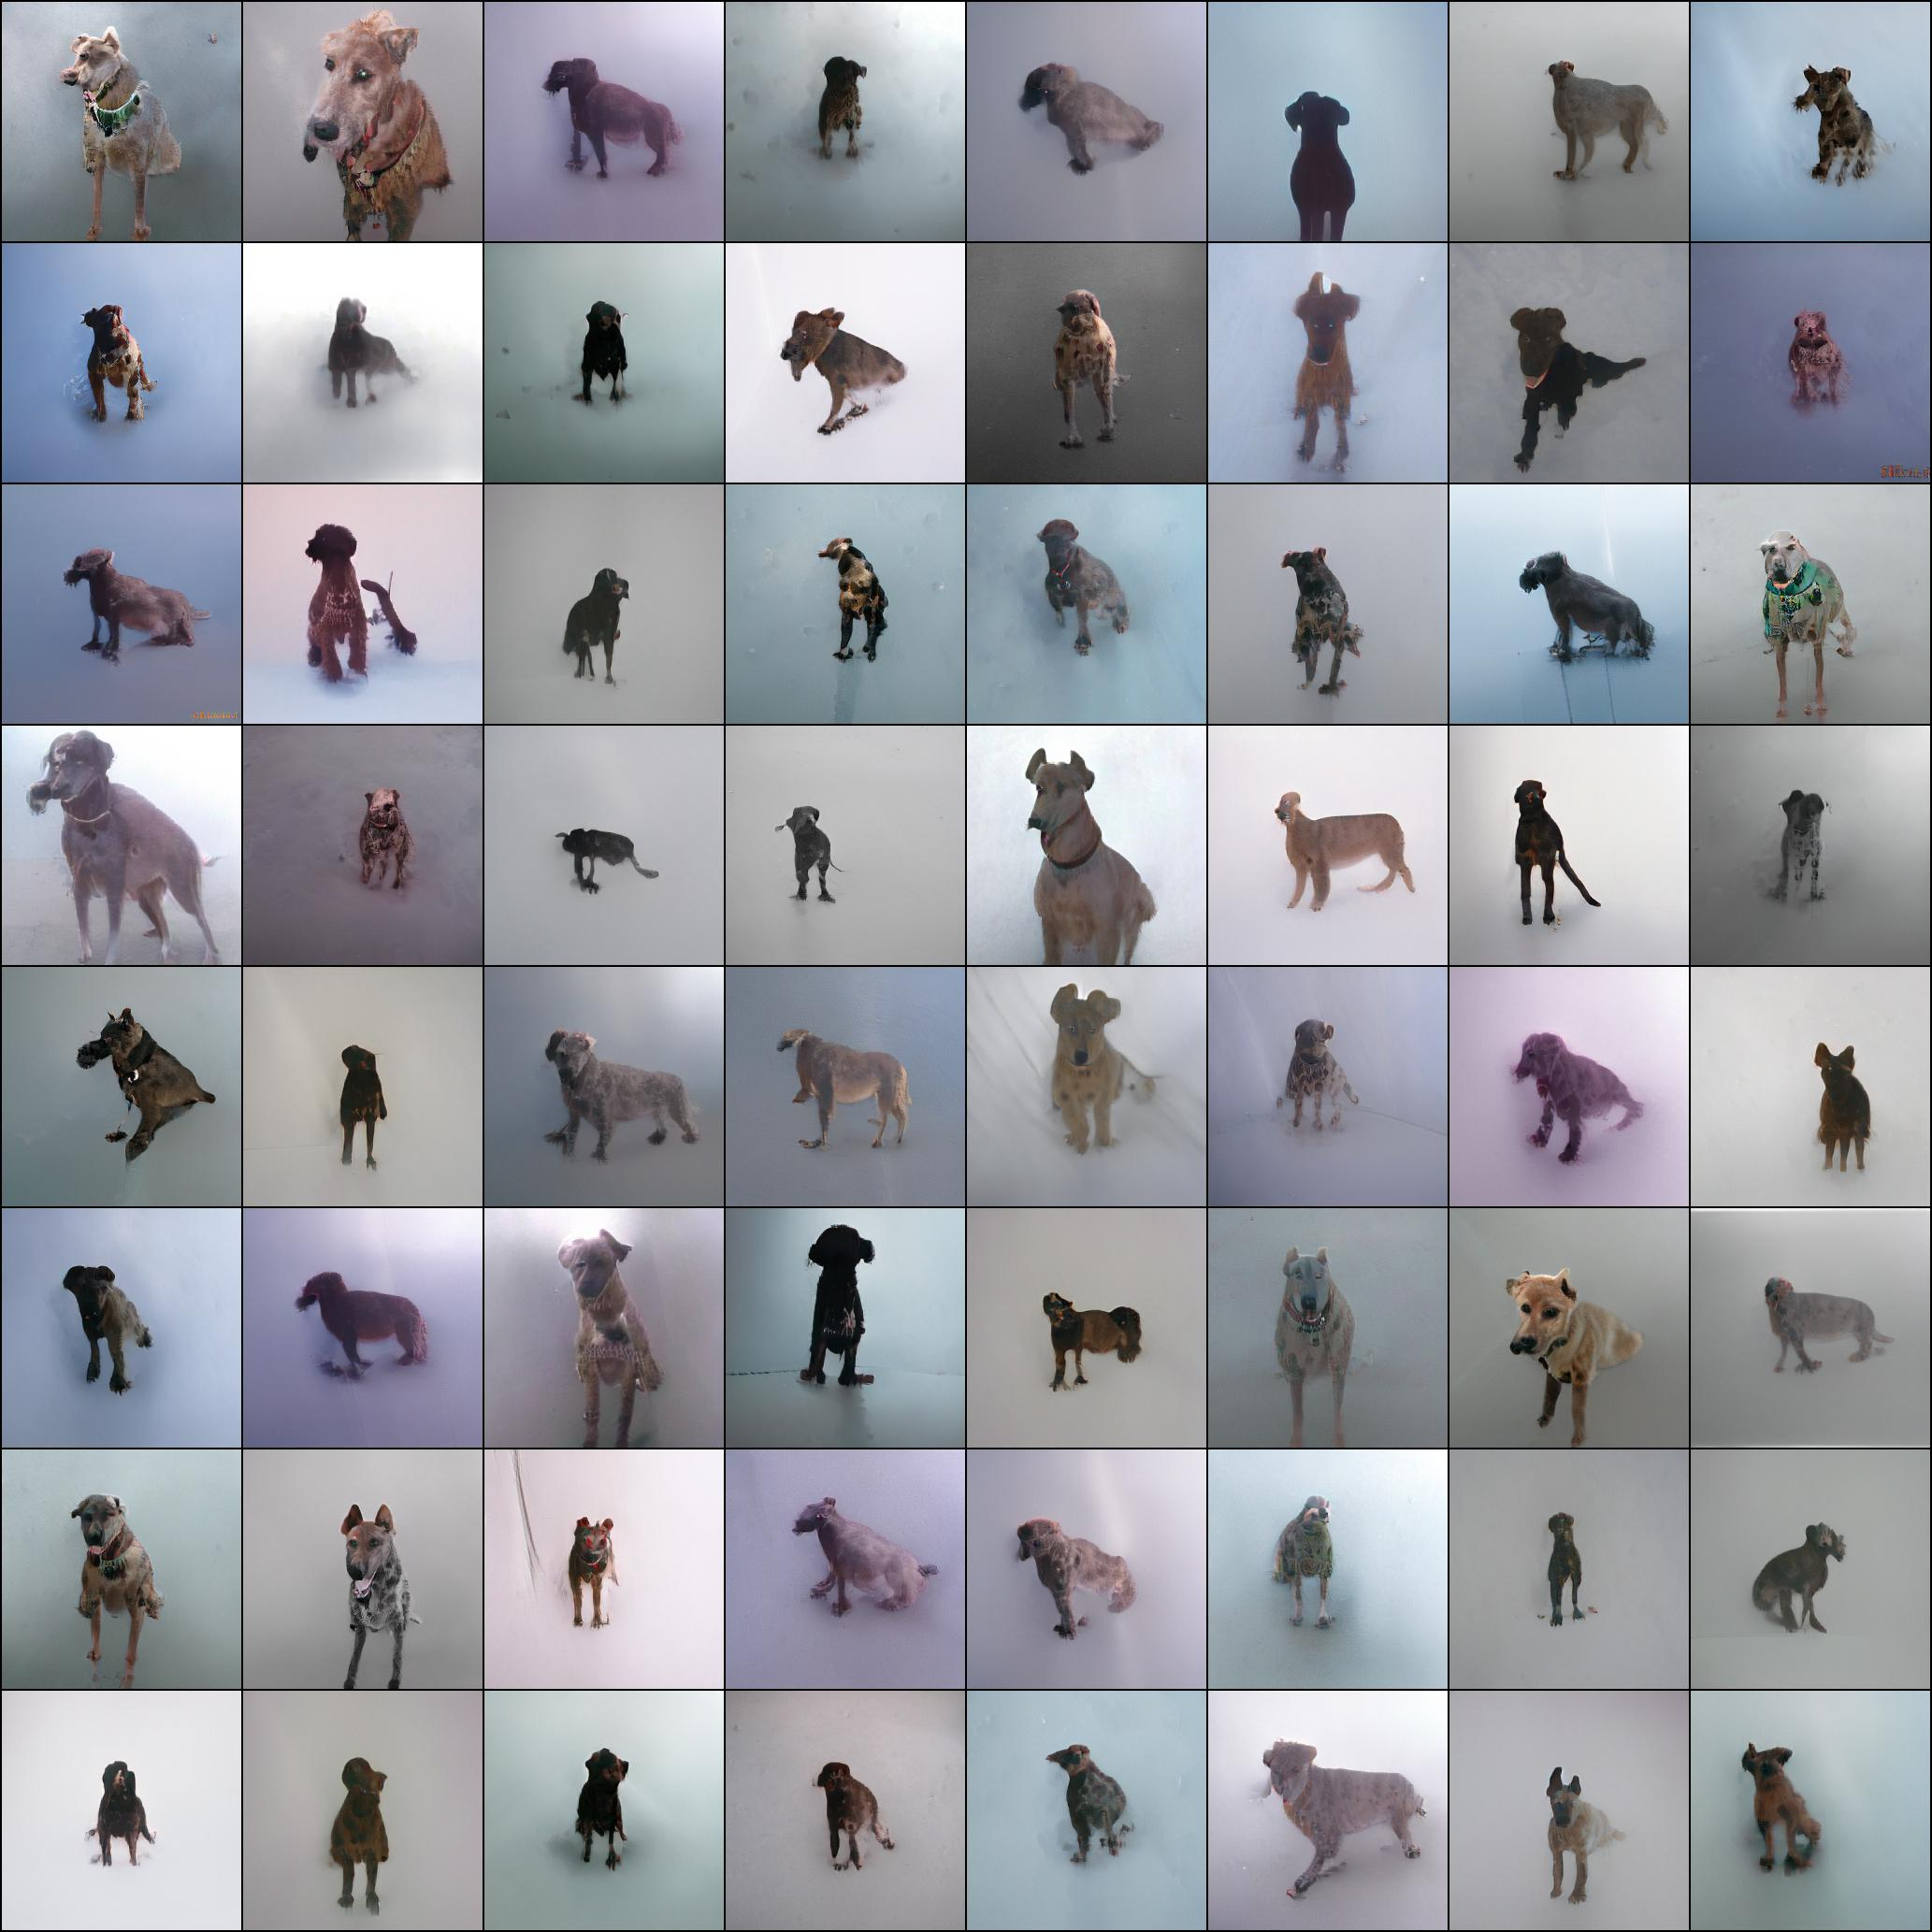

  191 |   12224 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3818
  192 |   12288 |  0.00000E+00 |  0.00000E+00 |       -0.396 |       -0.382
  193 |   12352 |  0.00000E+00 |  0.00000E+00 |       -0.396 |       -0.382
  194 |   12416 |  0.00000E+00 |  0.00000E+00 |       -0.396 |       -0.382
  195 |   12480 |  0.00000E+00 |  0.00000E+00 |       -0.396 |       -0.382
  196 |   12544 |  0.00000E+00 |  0.00000E+00 |       -0.396 |       -0.382
  197 |   12608 |  0.00000E+00 |  0.00000E+00 |       -0.396 |       -0.382
  198 |   12672 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3823
  199 |   12736 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3823
  200 |   12800 |  0.00000E+00 |  0.00000E+00 |       -0.396 |      -0.3823
After 200 iterations...


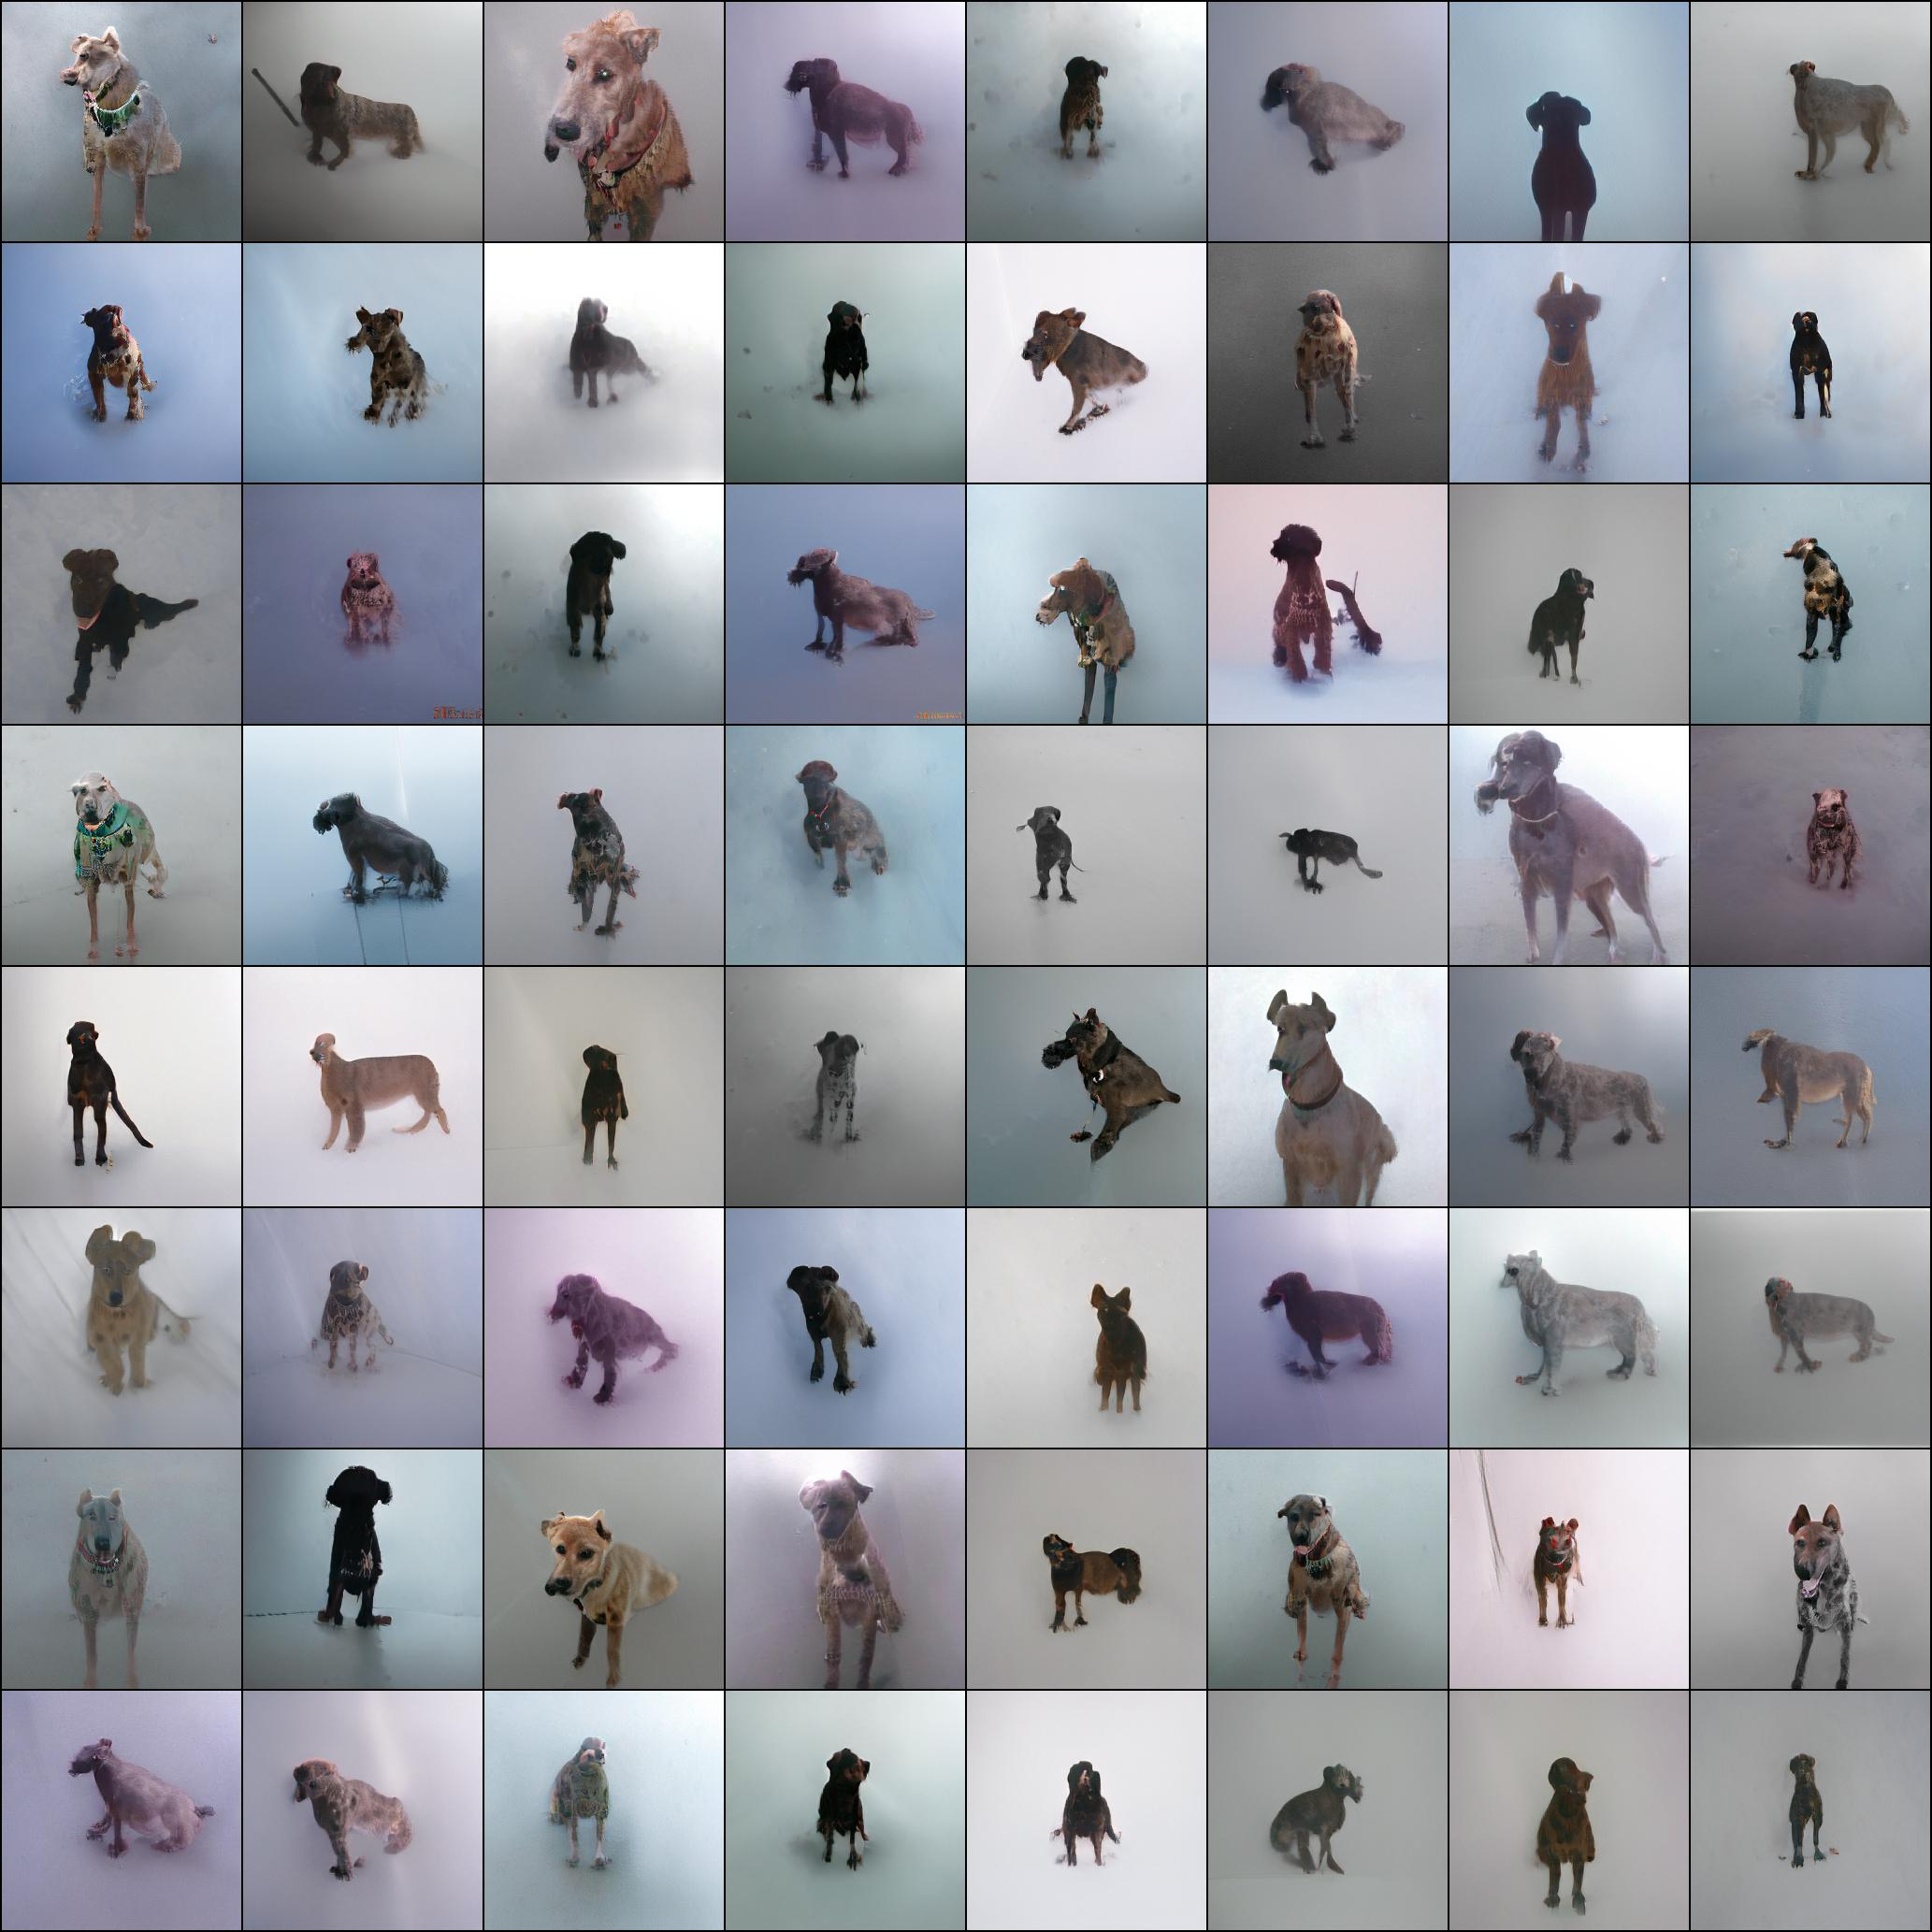

In RESULT
favg
[-0.2211, -0.2451, -0.2563, -0.2651, -0.272, -0.2798, -0.2844, -0.2883, -0.2935, -0.2976, -0.2998, -0.3013, -0.3052, -0.3086, -0.3113, -0.3145, -0.317, -0.3179, -0.3198, -0.322, -0.3232, -0.326, -0.328, -0.3293, -0.3315, -0.3345, -0.3347, -0.3367, -0.3374, -0.3406, -0.342, -0.344, -0.3452, -0.3464, -0.3486, -0.3503, -0.3523, -0.3538, -0.3545, -0.3547, -0.3557, -0.356, -0.357, -0.3577, -0.3584, -0.359, -0.3596, -0.3606, -0.3613, -0.3618, -0.362, -0.363, -0.3638, -0.364, -0.3645, -0.365, -0.3655, -0.366, -0.3665, -0.3667, -0.367, -0.3672, -0.3677, -0.3682, -0.3684, -0.369, -0.3694, -0.3699, -0.37, -0.3704, -0.3706, -0.371, -0.371, -0.3718, -0.372, -0.3723, -0.3726, -0.3728, -0.3728, -0.373, -0.3735, -0.3735, -0.3738, -0.3738, -0.3738, -0.374, -0.374, -0.374, -0.3743, -0.3745, -0.3745, -0.3748, -0.375, -0.375, -0.3752, -0.3755, -0.3755, -0.3757, -0.3757, -0.3757, -0.376, -0.376, -0.376, -0.3762, -0.3762, -0.3765, -0.3767, -0.3767, -0.377, -0.377, -0.377, -0.3772, -0.3772, -

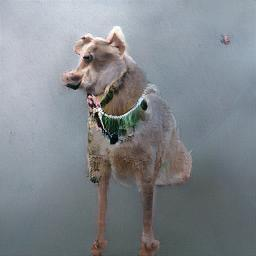

In [ ]:
 #@title RUN (GENERATE IMAGES)

iteration=0
res = generate_image(0)

In [ ]:
print(res.fopt_values)

[-0.3223, -0.3223, -0.3223, -0.3223, -0.3242, -0.3503, -0.3503, -0.3503, -0.3503, -0.3503, -0.3503, -0.3503, -0.3503, -0.3503, -0.3503, -0.3523, -0.3552, -0.3552, -0.3552, -0.3552, -0.3552, -0.3552, -0.3552, -0.3552, -0.3552, -0.356, -0.356, -0.3662, -0.3662, -0.37, -0.37, -0.37, -0.37, -0.3748, -0.3748, -0.3748, -0.3748, -0.379, -0.379, -0.379, -0.379, -0.379, -0.379, -0.379, -0.379, -0.379, -0.379, -0.379, -0.379, -0.379, -0.379, -0.379, -0.379, -0.379, -0.379, -0.379, -0.379, -0.379, -0.379, -0.379, -0.379, -0.379, -0.379, -0.379, -0.379, -0.3813, -0.3813, -0.3813, -0.3813, -0.3813, -0.3813, -0.3813, -0.3813, -0.396, -0.396, -0.396, -0.396, -0.396, -0.396, -0.396, -0.396, -0.396, -0.396, -0.396, -0.396, -0.396, -0.396, -0.396, -0.396, -0.396, -0.396, -0.396, -0.396, -0.396, -0.396, -0.396, -0.396, -0.396, -0.396, -0.396, -0.396, -0.396, -0.396, -0.396, -0.396, -0.396, -0.396, -0.396, -0.396, -0.396, -0.396, -0.396, -0.396, -0.396, -0.396, -0.396, -0.396, -0.396, -0.396, -0.396, -0.3

In [ ]:
print(res.favg_values)

[-0.2211, -0.2451, -0.2563, -0.2651, -0.272, -0.2798, -0.2844, -0.2883, -0.2935, -0.2976, -0.2998, -0.3013, -0.3052, -0.3086, -0.3113, -0.3145, -0.317, -0.3179, -0.3198, -0.322, -0.3232, -0.326, -0.328, -0.3293, -0.3315, -0.3345, -0.3347, -0.3367, -0.3374, -0.3406, -0.342, -0.344, -0.3452, -0.3464, -0.3486, -0.3503, -0.3523, -0.3538, -0.3545, -0.3547, -0.3557, -0.356, -0.357, -0.3577, -0.3584, -0.359, -0.3596, -0.3606, -0.3613, -0.3618, -0.362, -0.363, -0.3638, -0.364, -0.3645, -0.365, -0.3655, -0.366, -0.3665, -0.3667, -0.367, -0.3672, -0.3677, -0.3682, -0.3684, -0.369, -0.3694, -0.3699, -0.37, -0.3704, -0.3706, -0.371, -0.371, -0.3718, -0.372, -0.3723, -0.3726, -0.3728, -0.3728, -0.373, -0.3735, -0.3735, -0.3738, -0.3738, -0.3738, -0.374, -0.374, -0.374, -0.3743, -0.3745, -0.3745, -0.3748, -0.375, -0.375, -0.3752, -0.3755, -0.3755, -0.3757, -0.3757, -0.3757, -0.376, -0.376, -0.376, -0.3762, -0.3762, -0.3765, -0.3767, -0.3767, -0.377, -0.377, -0.377, -0.3772, -0.3772, -0.3774, -0.3774

In [ ]:
import seaborn as sns
sns.set(rc={'figure.figsize':(14,10)})
sns.color_palette("rocket", as_cmap=True)
palette = sns.color_palette("mako_r", 6)

import pandas as pd

In [ ]:
data_for_plots = {'Cos-sim average values for generations': res.favg_values, 'Cos-sim values for best samples in generations': res.fopt_values}
dataframe_for_plots = pd.DataFrame.from_dict(data_for_plots)
dataframe_for_plots['Generation'] = np.arange(len(dataframe_for_plots))

In [ ]:
dataframe_for_plots.head()

Cos-sim average values for generations  ...  Generation
0                               -0.221069  ...           0
1                               -0.245117  ...           1
2                               -0.256348  ...           2
3                               -0.265137  ...           3
4                               -0.271973  ...           4

[5 rows x 3 columns]

In [ ]:
dataframe_for_plots.describe()

Cos-sim average values for generations  ...  Generation
count                              200.000000  ...  200.000000
mean                                -0.363740  ...   99.500000
std                                  0.028569  ...   57.879185
min                                 -0.382324  ...    0.000000
25%                                 -0.380127  ...   49.750000
50%                                 -0.375854  ...   99.500000
75%                                 -0.362000  ...  149.250000
max                                 -0.221069  ...  199.000000

[8 rows x 3 columns]

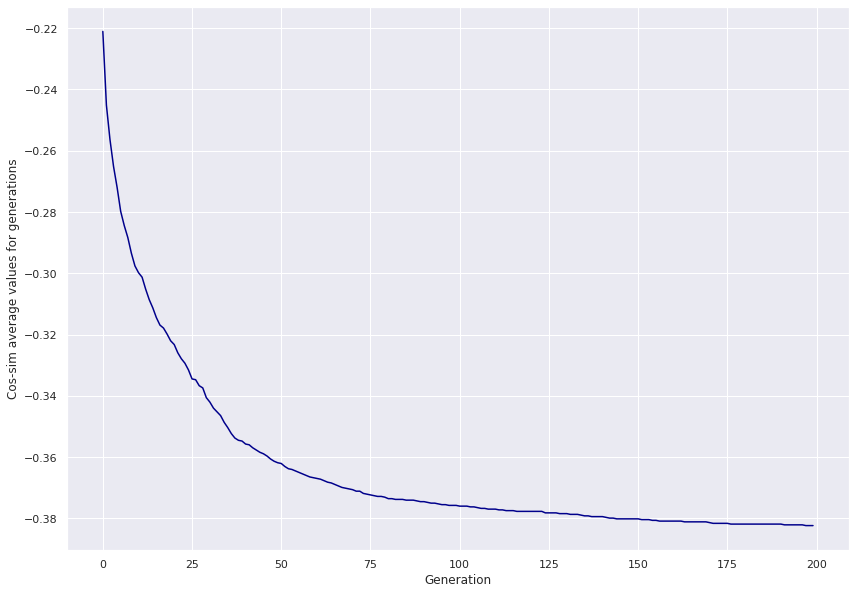

In [ ]:
plt = sns.lineplot(data=dataframe_for_plots, x = 'Generation', y = 'Cos-sim average values for generations', palette=palette, color = 'darkblue')

In [ ]:
plt.figure.savefig('avgsincos.jpg')

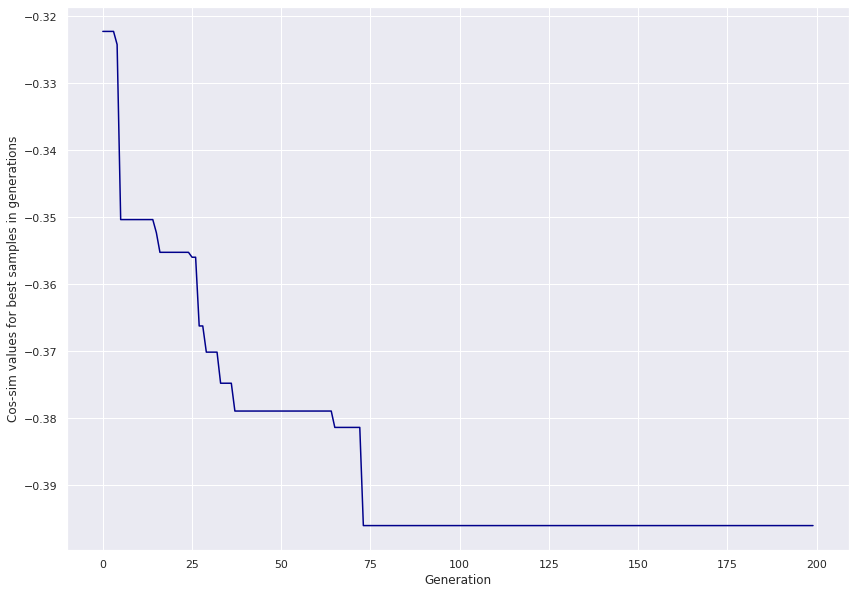

In [ ]:
plt = sns.lineplot(data=dataframe_for_plots, x = 'Generation', y = 'Cos-sim values for best samples in generations', palette=palette, color = 'darkblue')

In [ ]:
plt.figure.savefig('bestsincos.jpg')

In [ ]:
!cp -R ./results /content/drive/MyDrive/exps/results/"a dog in the fog"/GA

In [ ]:
!cp -R avgsincos.jpg /content/drive/MyDrive/exps/results/"a dog in the fog"/GA

In [ ]:
!cp -R bestsincos.jpg /content/drive/MyDrive/exps/results/"a dog in the fog"/GA

In [ ]:
save_for_next = dataframe_for_plots

In [ ]:
save_for_next.head()

Cos-sim average values for generations  ...  Generation
0                               -0.202148  ...           0
1                               -0.218750  ...           1
2                               -0.234009  ...           2
3                               -0.238892  ...           3
4                               -0.243164  ...           4

[5 rows x 3 columns]

In [ ]:
names = ['Cos-sim average values for generations for DE', 'Cos-sim values for best samples in generations for DE', 'Generation']

In [ ]:
dataframe_for_plots.columns = names

In [ ]:
names = ['Cos-sim average values for generations for GA', 'Cos-sim values for best samples in generations for GA', 'Generation']

In [ ]:
save_for_next.columns = names

In [ ]:
concat_df = pd.concat([save_for_next, dataframe_for_plots], axis=1)

In [ ]:
concat_df.head()

Cos-sim average values for generations for GA  ...  Generation
0                                      -0.202148  ...           0
1                                      -0.218750  ...           1
2                                      -0.234009  ...           2
3                                      -0.238892  ...           3
4                                      -0.243164  ...           4

[5 rows x 6 columns]

In [ ]:
df_avg = concat_df[['Cos-sim average values for generations for GA', 'Cos-sim average values for generations for DE']]
df_best = concat_df[['Cos-sim values for best samples in generations for GA', 'Cos-sim values for best samples in generations for DE']]

KeyError: ignored

In [ ]:
plt_avg = sns.lineplot(data=df_avg)

In [ ]:
plt_avg.figure.savefig('avg_both.jpg')

In [ ]:
plt_best = sns.lineplot(data=df_best)

In [ ]:
plt_best.figure.savefig('best_both.jpg')

In [ ]:
!cp -R best_both.jpg /content/drive/MyDrive/exps/results/"a dog in the fog"
!cp -R avg_both.jpg /content/drive/MyDrive/exps/results/"a dog in the fog"